> # From Notes to Networks: Decoding the Musical DNA of Classical Composers through Symbolic Sequence Learning
>
> ### Composer Classification Using Deep Learning
>
> ![Composer Classification Using Deep Learning](data/header.png)


**University of San Diego**
AAI-511: Neural Networks and Deep Learning

---

**Professor**: Rod Albuyeh 

**Section**: 5  
**Group**: 2  
**Contributors**:

- Ashley Moore
- Kevin Pooler
- Swapnil Patil

August, 2025

---


<a id='Index'></a>

# Index

1. [Introduction](#introduction)
1. [Objective](#objective)
1. [Dataset](#dataset)
1. [Data Cleaning and Preprocessing](#datacleaning)
1. [Feature Extraction](#featureextraction)
1. [Exploratory Data Analysis](#exploratory)
1. [Model Building](#modelbuilding):
   - [LSTM](#modelbuildinglstm)
   - [CNN](#modelbuildingcnn)
1. [Model Training](#modeltraining)
1. [Model Evaluation](#modelevaluation)
1. [Model Optimization](#modeloptimization)
1. [Deployment](#deployment)
1. [Conclusion](#conclusion)
1. [Recommendations](#recommendations)
1. [Next Steps](#nextsteps)
1. [References](#references)

### Streamlit Application

[Application URL](https://musicai.streamlit.app/)


<a id='introduction'></a>

# 1. Introduction: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.


<a id='objective'></a>

# 2. Objective: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


#### Problem Statement

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).


<a id='dataset'></a>

# 3. Dataset:

---


The project will use a dataset consisting of musical scores from various composers.

https://www.kaggle.com/datasets/blanderbuss/midi-classic-music

The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset should be labeled with the name of the composer for each score. Please only do your prediction only for below composers, therefore you need to select the required composers from the given dataset above.

1. Bach
1. Beethoven
1. Chopin
1. Mozart


<a id='datacleaning'></a>

# 4. Data Cleaning and Pre-processing: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


In [1]:
%pip install -q -r requirements.txt
%load_ext autoreload
%autoreload 2


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Toggle the following flags to control the behavior of the notebook
EXTRACT_FEATURES = False
SAMPLING = False
SAMPLING_FILES_PER_COMPOSER = 20

In [3]:
# System and utility imports
import sys
import os
import time
import warnings
import pickle
import hashlib
from functools import lru_cache
from collections import Counter, defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import cpu_count
from tqdm import tqdm

# Data processing libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Music processing libraries
import music21
from music21 import (
    converter, note, chord, roman, key, tempo, instrument, 
    interval, pitch, stream
)
import pypianoroll
import pretty_midi
import librosa
import librosa.display

# Deep learning libraries
import torch
import tensorflow as tf


# Add parent directory to path
sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

c:\Source\AIML\aai511_2proj\.venv\Lib\site-packages\pretty_midi\instrument.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Source\AIML\aai511_2proj\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Source\AIML\aai511_2proj\.venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility vi

In [4]:
class EnvironmentSetup:
    """
    Centralized environment configuration class for faster music classification.
    Handles all environment setup including GPU configuration, reproducibility, and optimization settings.
    """

    def __init__(self):
        self.random_seed = 42
        self.optimal_workers = None
        self.gpu_configured = False
        self.cuda_available = False
        self.config_summary = []
        self.force_gpu = True  # New flag to force GPU usage when available
        self.cuda_device_id = 0  # Default CUDA device ID to use
        self.color_pallete = "viridis"
        
    def configure_environment(self):
        """Configure all environment settings for optimal performance and reproducibility."""
        # Configure reproducibility
        self._configure_reproducibility()

        # Configure GPU and memory settings
        self._configure_gpu_and_memory()

        # Configure CPU workers
        self._configure_cpu_workers()

        # Configure visualization settings
        self._configure_visualization()

        # Configure pandas settings
        self._configure_pandas()

        # Configure warnings
        self._configure_warnings()

        # Print final configuration summary
        self._print_configuration_summary()

    def _configure_reproducibility(self):
        """Set random seeds for reproducible results."""
        np.random.seed(self.random_seed)
        tf.random.set_seed(self.random_seed)
        self.config_summary.append(f"Random seeds set to {self.random_seed} for reproducibility")

    def _configure_gpu_and_memory(self):
        """Configure GPU settings and memory management for optimal performance."""

        try:
            # Check for CUDA availability first
            self.cuda_available = torch.cuda.is_available()
            if self.cuda_available:
                cuda_version = torch.version.cuda
                device_count = torch.cuda.device_count()
                self.config_summary.append(f"CUDA is available (version: {cuda_version}, devices: {device_count})")

                # Set CUDA device
                if self.cuda_device_id < device_count:
                    torch.cuda.set_device(self.cuda_device_id)
                    self.config_summary.append(f"Set active CUDA device to: {torch.cuda.get_device_name(self.cuda_device_id)}")

                # Set seeds for reproducibility
                torch.cuda.manual_seed(self.random_seed)
                torch.cuda.manual_seed_all(self.random_seed)
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = True  # Enable for improved performance with fixed input sizes

                self.config_summary.append(f"CUDA random seed set to {self.random_seed}")
                self.config_summary.append(f"CUDA deterministic mode: enabled")
                self.config_summary.append(f"CUDA benchmark mode: enabled")

                # Export CUDA device for other libraries
                os.environ["CUDA_VISIBLE_DEVICES"] = str(self.cuda_device_id)
                self.config_summary.append(f"Set CUDA_VISIBLE_DEVICES={self.cuda_device_id}")
            else:
                self.config_summary.append("CUDA is not available")

            # Check for GPU availability in TensorFlow
            gpus = tf.config.experimental.list_physical_devices('GPU')

            if gpus:
                self.config_summary.append(f"Found {len(gpus)} GPU(s)")

                if self.force_gpu:
                    # Force TensorFlow to use GPU
                    tf.config.set_visible_devices(gpus, 'GPU')
                    self.config_summary.append("Forced TensorFlow to use GPU")

                    # Configure memory growth to prevent TensorFlow from allocating all GPU memory
                    for gpu in gpus:
                        tf.config.experimental.set_memory_growth(gpu, True)
                        self.config_summary.append(f"Configured memory growth for GPU: {gpu.name}")

                    # Set mixed precision for better performance on modern GPUs
                    tf.config.optimizer.set_jit(True)  # Enable XLA compilation
                    policy = tf.keras.mixed_precision.Policy('mixed_float16')
                    tf.keras.mixed_precision.set_global_policy(policy)
                    self.config_summary.append("Enabled mixed precision training (float16)")
                    self.config_summary.append("Enabled XLA compilation for faster execution")

                    # Configure GPU device placement
                    tf.config.experimental.set_device_policy('explicit')
                    self.config_summary.append("Set explicit device placement policy")

                    self.gpu_configured = True
                else:
                    self.config_summary.append("GPU available but not forced (force_gpu=False)")

            else:
                self.config_summary.append("No GPU found in TensorFlow. Using CPU for computation.")
                # Configure CPU optimizations
                tf.config.threading.set_intra_op_parallelism_threads(0)  # Use all available cores
                tf.config.threading.set_inter_op_parallelism_threads(0)  # Use all available cores
                self.config_summary.append("Configured CPU threading for optimal performance")

        except Exception as e:
            self.config_summary.append(f"Error configuring GPU: {e}")
            self.config_summary.append("Falling back to default CPU configuration")

    def set_cuda_device(self, device_id=0):
        self.cuda_device_id = device_id

    def toggle_force_gpu(self, force=True):
        self.force_gpu = force

    def _configure_cpu_workers(self):
        """Configure optimal number of CPU workers for parallel processing."""

        # Set optimal number of workers based on CPU cores
        self.optimal_workers = min(cpu_count(), 12)  # Cap at 12 to avoid memory issues

        # Make it globally accessible
        globals()['OPTIMAL_WORKERS'] = self.optimal_workers

        self.config_summary.append(f"Configured {self.optimal_workers} workers for parallel processing (CPU cores: {cpu_count()})")

    def _configure_visualization(self):
        """Configure matplotlib and seaborn settings."""
        sns.set(style='whitegrid')
        plt.style.use('default')
        plt.ioff()  # Turn off interactive mode for better performance
        self.config_summary.append("Visualization settings configured (seaborn whitegrid, matplotlib default)")
        self.color_pallete = sns.color_palette("viridis")

    def _configure_pandas(self):
        """Configure pandas display options."""
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.max_rows', 100)
        self.config_summary.append("Pandas display options configured (max_columns=None, max_rows=100)")

    def _configure_warnings(self):
        """Suppress unnecessary warnings."""
        warnings.filterwarnings('ignore')
        self.config_summary.append("Warning filters configured (suppressed for cleaner output)")

    def _print_configuration_summary(self):
        """Print a summary of the current configuration."""
        print("=" * 60)
        print("ENVIRONMENT CONFIGURATION SUMMARY")
        print("=" * 60)

        for item in self.config_summary:
            print(item)

        print("\nCONFIGURATION DETAILS:")
        print(f"Random Seed: {self.random_seed}")
        print(f"CPU Workers: {self.optimal_workers}")
        print(f"GPU Configured: {self.gpu_configured}")
        print(f"CUDA Available: {self.cuda_available}")
        print(f"Force GPU: {self.force_gpu}")

        if self.cuda_available:
            print(f"Active CUDA Device: {torch.cuda.get_device_name(self.cuda_device_id)}")
            print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(self.cuda_device_id) / 1024**2:.2f} MB")
            print(f"CUDA Memory Reserved: {torch.cuda.memory_reserved(self.cuda_device_id) / 1024**2:.2f} MB")

        if self.gpu_configured:
            gpus = tf.config.experimental.list_physical_devices('GPU')
            for i, gpu in enumerate(gpus):
                print(f"GPU {i}: {gpu.name}")

        print(f"TensorFlow Version: {tf.__version__}")
        print(f"PyTorch Version: {torch.__version__}")
        print(f"NumPy Version: {np.__version__}")
        print(f"Pandas Version: {pd.__version__}")
        print("=" * 60)

In [5]:
# Initialize and configure environment
env_config = EnvironmentSetup()
env_config.configure_environment()
OPTIMAL_WORKERS = env_config.optimal_workers

ENVIRONMENT CONFIGURATION SUMMARY
Random seeds set to 42 for reproducibility
CUDA is not available
No GPU found in TensorFlow. Using CPU for computation.
Configured CPU threading for optimal performance
Configured 12 workers for parallel processing (CPU cores: 20)
Visualization settings configured (seaborn whitegrid, matplotlib default)
Pandas display options configured (max_columns=None, max_rows=100)
Warning filters configured (suppressed for cleaner output)

CONFIGURATION DETAILS:
Random Seed: 42
CPU Workers: 12
GPU Configured: False
CUDA Available: False
Force GPU: True
TensorFlow Version: 2.20.0-rc0
PyTorch Version: 2.7.1+cpu
NumPy Version: 2.2.6
Pandas Version: 2.3.1


In [6]:
try:
    from google.colab import drive
    COLAB_DRIVE_PATH = '/content/drive'
    drive.mount(COLAB_DRIVE_PATH)
    DATA_DIRECTORY = f"{COLAB_DRIVE_PATH}/MyDrive/data"
    MUSIC_DATA_DIRECTORY = f"{DATA_DIRECTORY}/midiclassics"
    IS_COLAB = True
    print(f"Google Drive mounted at {COLAB_DRIVE_PATH}")
except:
    DATA_DIRECTORY = "data"
    MUSIC_DATA_DIRECTORY = f"{DATA_DIRECTORY}\midiclassics"
    IS_COLAB = False
    print("Running in local environment, not Google Colab")

MUSICAL_FEATURES_DF_PATH = f'{DATA_DIRECTORY}/features/musical_features_df.pkl'
HARMONIC_FEATURES_DF_PATH = f'{DATA_DIRECTORY}/features/harmonic_features_df.pkl'
NOTE_SEQUENCES_PATH = f'{DATA_DIRECTORY}/features/note_sequences.npy'
NOTE_SEQUENCES_LABELS_PATH = f'{DATA_DIRECTORY}/features/sequence_labels.npy'
NOTE_MAPPING_PATH = f'{DATA_DIRECTORY}/features/note_mapping.pkl'
MODEL_ARTIFACTS_PATH = f'{DATA_DIRECTORY}/model/composer_classification_model_artifacts.pkl'
MODEL_HISTORY_PATH = f'{DATA_DIRECTORY}/model/composer_classification_model_history.pkl'
MODEL_PATH = f'{DATA_DIRECTORY}/model/composer_classification_model.keras'
MODEL_BEST_PATH = f'{DATA_DIRECTORY}/model/composer_classification_model_best.keras'

# List of target composers for classification
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
print(f"Target composers for classification: {TARGET_COMPOSERS}")

Running in local environment, not Google Colab
Target composers for classification: ['Bach', 'Beethoven', 'Chopin', 'Mozart']


In [7]:
class MidiProcessor:

    def __init__(self):
        self._file_cache = {}  # Cache for parsed files
        self._feature_cache = {}  # Cache for extracted features

    def load_midi_files(self, data_dir, max_files_per_composer=None, n_jobs=None):

        if n_jobs is None:
            n_jobs = OPTIMAL_WORKERS

        start_time = time.time()

        # Get all composer directories
        composers = [c for c in os.listdir(data_dir)
                    if os.path.isdir(os.path.join(data_dir, c))]

        def scan_composer(composer):
            composer_path = os.path.join(data_dir, composer)
            try:
                # Get all MIDI files with recursive search
                midi_files = []
                for root, dirs, files in os.walk(composer_path):
                    for file in files:
                        if file.lower().endswith(('.mid', '.midi')):
                            # Get path relative to composer_path
                            rel_path = os.path.relpath(os.path.join(root, file), composer_path)
                            midi_files.append(rel_path)

                # Apply limit if specified
                if max_files_per_composer:
                    midi_files = midi_files[:max_files_per_composer]

                # Create file info list
                return [
                    {
                        'file_path': os.path.join(composer_path, midi_file),
                        'composer': composer,
                        'filename': midi_file
                    }
                    for midi_file in midi_files
                ]
            except Exception as e:
                print(f"Error scanning {composer}: {e}")
                return []

        # Parallel composer scanning
        all_files = []
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(scan_composer, composer) for composer in composers]
            for future in as_completed(futures):
                composer_files = future.result()
                all_files.extend(composer_files)

        elapsed = time.time() - start_time
        print(f"Loaded {len(all_files)} MIDI files from {len(composers)} composers in {elapsed:.2f}s")

        return pd.DataFrame(all_files)

    @staticmethod
    def extract_notes_from_midi(midi_path, max_notes=500):
        try:
            # Parse once and extract efficiently
            midi = converter.parse(midi_path)
            notes = []

            # Note extraction with limits
            if hasattr(midi, 'parts') and midi.parts:
                # Process only first few parts for speed
                for part in midi.parts[:2]:  # Limit to 2 parts
                    part_notes = part.recurse().notes
                    for element in part_notes:
                        if len(notes) >= max_notes:
                            break
                        if isinstance(element, note.Note):
                            notes.append(str(element.pitch))
                        elif isinstance(element, chord.Chord):
                            notes.append('.'.join(str(n) for n in element.normalOrder))
                    if len(notes) >= max_notes:
                        break
            else:
                # Flat structure
                for element in midi.flat.notes:
                    if len(notes) >= max_notes:
                        break
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))

            return notes[:max_notes]  # Ensure we don't exceed limit

        except Exception as e:
            print(f"Error processing {midi_path}: {str(e)}")
            return []

    @staticmethod
    def extract_notes_batch(midi_paths_batch, max_notes=500):
        results = []
        for midi_path in midi_paths_batch:
            notes = MidiProcessor.extract_notes_from_midi(midi_path, max_notes)
            results.append(notes)
        return results

    @staticmethod
    def extract_notes_from_midi_parallel(midi_paths, max_notes=500, n_jobs=None):
        if n_jobs is None:
            n_jobs = OPTIMAL_WORKERS

        total_files = len(midi_paths)

        # Create batches for better memory management
        batch_size = max(1, len(midi_paths) // (n_jobs * 2))
        batches = [midi_paths[i:i + batch_size] for i in range(0, len(midi_paths), batch_size)]

        results = [None] * len(midi_paths)

        # Create a progress bar
        pbar = tqdm(total=total_files, desc="Extracting notes from MIDI files")

        def process_batch(batch_data):
            batch_idx, batch_paths = batch_data
            batch_results = MidiProcessor.extract_notes_batch(batch_paths, max_notes)
            # Update progress bar for each file in the batch
            pbar.update(len(batch_paths))
            return batch_idx, batch_results

        try:
            # Process batches in parallel
            with ThreadPoolExecutor(max_workers=n_jobs) as executor:
                batch_data = [(i, batch) for i, batch in enumerate(batches)]
                futures = [executor.submit(process_batch, data) for data in batch_data]

                for future in as_completed(futures):
                    batch_idx, batch_results = future.result()
                    batch_start = batch_idx * batch_size
                    for i, notes in enumerate(batch_results):
                        if batch_start + i < len(results):
                            results[batch_start + i] = notes
        finally:
            # Make sure to close the progress bar
            pbar.close()

        # Report completion stats
        successful = sum(1 for r in results if r is not None and len(r) > 0)
        print(f"\nNote extraction complete: {successful}/{total_files} files processed successfully")

        return results

    @staticmethod
    def extract_musical_features(midi_path):
        try:
            midi = converter.parse(midi_path)
            features = {}

            # Basic counts
            all_notes = list(midi.flat.notes)
            features['total_notes'] = len(all_notes)
            features['total_duration'] = float(midi.duration.quarterLength) if midi.duration else 0

            # Time signature (quick lookup)
            time_sigs = midi.getTimeSignatures()
            if time_sigs:
                features['time_signature'] = f"{time_sigs[0].numerator}/{time_sigs[0].denominator}"
            else:
                features['time_signature'] = "4/4"

            # Key analysis
            try:
                key_sigs = midi.analyze('key')
                features['key'] = str(key_sigs) if key_sigs else "C major"
                if hasattr(key_sigs, 'correlationCoefficient'):
                    features['key_confidence'] = float(abs(key_sigs.correlationCoefficient))
                else:
                    features['key_confidence'] = 0.5
            except:
                features['key'] = "C major"
                features['key_confidence'] = 0.5

            # Tempo
            tempo_markings = midi.flat.getElementsByClass('MetronomeMark')
            features['tempo'] = float(tempo_markings[0].number) if tempo_markings else 120.0

            # Pitch features (vectorized calculation)
            pitches = []
            durations = []
            for n in all_notes[:1000]:  # Limit for speed
                if isinstance(n, note.Note):
                    pitches.append(n.pitch.midi)
                    durations.append(float(n.duration.quarterLength))
                elif isinstance(n, chord.Chord):
                    pitches.append(n.root().midi)
                    durations.append(float(n.duration.quarterLength))

            if pitches:
                pitches_array = np.array(pitches)
                features['avg_pitch'] = float(np.mean(pitches_array))
                features['pitch_range'] = float(np.ptp(pitches_array))
                features['pitch_std'] = float(np.std(pitches_array))

                # Intervals (vectorized)
                if len(pitches) > 1:
                    intervals = np.abs(np.diff(pitches_array))
                    features['avg_interval'] = float(np.mean(intervals))
                    features['interval_std'] = float(np.std(intervals))
                else:
                    features['avg_interval'] = 0.0
                    features['interval_std'] = 0.0
            else:
                features.update({
                    'avg_pitch': 60.0, 'pitch_range': 0.0, 'pitch_std': 0.0,
                    'avg_interval': 0.0, 'interval_std': 0.0
                })

            # Duration features (vectorized)
            if durations:
                dur_array = np.array(durations)
                features['avg_duration'] = float(np.mean(dur_array))
                features['duration_std'] = float(np.std(dur_array))
            else:
                features['avg_duration'] = 1.0
                features['duration_std'] = 0.0

            # Structural features (limited for speed)
            features['num_parts'] = len(midi.parts) if hasattr(midi, 'parts') else 1

            # Count specific elements (limited)
            limited_elements = list(midi.flat.notesAndRests)[:500]  # Limit for speed
            chords = [el for el in limited_elements if isinstance(el, chord.Chord)]
            rests = [el for el in limited_elements if isinstance(el, note.Rest)]

            features['num_chords'] = len(chords)
            features['num_rests'] = len(rests)
            features['rest_ratio'] = len(rests) / features['total_notes'] if features['total_notes'] > 0 else 0

            # Measures (efficient approximation)
            if hasattr(midi, 'parts') and midi.parts:
                measures = list(midi.parts[0].getElementsByClass('Measure'))
                features['num_measures'] = len(measures) if measures else max(1, int(features['total_duration'] / 4))
            else:
                features['num_measures'] = max(1, int(features['total_duration'] / 4))

            features['avg_notes_per_measure'] = features['total_notes'] / features['num_measures'] if features['num_measures'] > 0 else 0

            # Instruments (simplified)
            instruments = []
            if hasattr(midi, 'parts') and midi.parts:
                for part in midi.parts[:3]:  # Limit to first 3 parts
                    try:
                        instr = part.getInstrument(returnDefault=True)
                        instruments.append(str(instr))
                    except:
                        instruments.append('Piano')
            else:
                instruments = ['Piano']

            features['instruments'] = list(set(instruments))

            # Chord types (limited analysis)
            chord_types = []
            for c in chords[:10]:  # Limit to first 10 chords
                try:
                    chord_types.append(c.commonName)
                except:
                    chord_types.append('Unknown')

            features['chord_types'] = list(set(chord_types))

            return features

        except Exception as e:
            print(f"Error extracting features from {midi_path}: {str(e)}")
            return {
                'total_notes': 0, 'total_duration': 0, 'time_signature': '4/4',
                'key': 'C major', 'key_confidence': 0, 'tempo': 120.0,
                'avg_pitch': 60.0, 'pitch_range': 0, 'pitch_std': 0,
                'avg_duration': 1.0, 'duration_std': 0,
                'avg_interval': 0, 'interval_std': 0, 'num_parts': 1,
                'num_chords': 0, 'num_rests': 0, 'rest_ratio': 0,
                'num_measures': 1, 'avg_notes_per_measure': 0,
                'instruments': ['Piano'], 'chord_types': []
            }

    @staticmethod
    def extract_musical_features_parallel(midi_paths, n_jobs=None):
        if n_jobs is None:
            n_jobs = OPTIMAL_WORKERS

        total_files = len(midi_paths)
        results = [None] * total_files

        # Create a progress bar
        pbar = tqdm(total=total_files, desc="Extracting musical features")

        def worker(idx, midi_path):
            try:
                features = MidiProcessor.extract_musical_features(midi_path)
                return idx, features
            except Exception as e:
                print(f"\nError processing {midi_path}: {e}")
                return idx, MidiProcessor.extract_musical_features(None)  # Return empty features
            finally:
                # Update progress bar
                pbar.update(1)

        try:
            with ThreadPoolExecutor(max_workers=n_jobs) as executor:
                # Submit all tasks
                futures = [executor.submit(worker, idx, path) for idx, path in enumerate(midi_paths)]

                # Process results as they complete
                for future in as_completed(futures):
                    try:
                        idx, features = future.result()
                        results[idx] = features
                    except Exception as e:
                        print(f"\nError in feature extraction worker: {e}")
        finally:
            # Make sure to close the progress bar
            pbar.close()

        # Report completion stats
        successful = sum(1 for r in results if r is not None and r.get('total_notes', 0) > 0)
        print(f"\nFeature extraction complete: {successful}/{total_files} files processed successfully")

        return results

    @staticmethod
    def create_note_sequences(notes_list, sequence_length=100):
        print("Building vocabulary...")

        # Vocabulary building
        all_notes = []
        for notes in notes_list:
            if notes:  # Skip empty note lists
                all_notes.extend(notes[:1000])  # Limit notes per file for speed

        unique_notes = sorted(set(all_notes))
        note_to_int = {note: i for i, note in enumerate(unique_notes)}

        print(f"Vocabulary size: {len(unique_notes)}")
        print("Creating sequences...")

        # Create sequences with memory optimization
        sequences = []
        batch_size = 1000

        for i in range(0, len(notes_list), batch_size):
            batch_notes = notes_list[i:i + batch_size]
            batch_sequences = []

            for notes in batch_notes:
                if len(notes) >= sequence_length:
                    # Convert notes to integers (with error handling)
                    note_ints = []
                    for note in notes:
                        if note in note_to_int:
                            note_ints.append(note_to_int[note])

                    # Create sequences from this file
                    for j in range(len(note_ints) - sequence_length + 1):
                        seq = note_ints[j:j + sequence_length]
                        if len(seq) == sequence_length:  # Ensure correct length
                            batch_sequences.append(seq)

            sequences.extend(batch_sequences)

            # Progress update
            if i % (batch_size * 10) == 0:
                print(f"Processed {min(i + batch_size, len(notes_list))}/{len(notes_list)} files, "
                      f"created {len(sequences)} sequences")

            # Memory cleanup
            if len(sequences) > 50000:  # Prevent memory overflow
                break

        print(f"Total sequences created: {len(sequences)}")
        return np.array(sequences), note_to_int, unique_notes

    @staticmethod
    def preprocess_midi_files(file_df, min_duration=5.0, min_key_confidence=0.7, verbose=True, n_jobs=None):
        if n_jobs is None:
            n_jobs = OPTIMAL_WORKERS

        processed_files = []
        seen_hashes = set()
        total = len(file_df)
        stats = {
            'total': total,
            'corrupted': 0,
            'zero_length': 0,
            'duplicates': 0,
            'too_short': 0,
            'ambiguous_key': 0,
            'kept': 0
        }

        def process_file(row_data):
            idx, row = row_data
            path = row['file_path']
            try:
                # Quick file validation
                if not os.path.exists(path) or os.path.getsize(path) == 0:
                    return ('zero_length', None)

                # File hash for deduplication
                with open(path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()

                # Basic MIDI parsing
                score = converter.parse(path)
                duration = score.duration.seconds if score.duration else 0

                if duration < min_duration:
                    return ('too_short', None)

                # Key confidence check (if needed)
                if min_key_confidence > 0:
                    try:
                        key_obj = score.analyze('key')
                        if hasattr(key_obj, 'correlationCoefficient'):
                            confidence = abs(key_obj.correlationCoefficient)
                        else:
                            confidence = 1.0

                        if confidence < min_key_confidence:
                            return ('ambiguous_key', None)
                    except:
                        return ('ambiguous_key', None)

                return ('kept', (file_hash, row))

            except Exception as e:
                return ('corrupted', None)

        completed = 0
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            row_data = [(idx, row) for idx, row in file_df.iterrows()]
            futures = [executor.submit(process_file, data) for data in row_data]

            for future in as_completed(futures):
                result, data = future.result()
                completed += 1

                if verbose and completed % 50 == 0:
                    percent = (completed / total) * 100
                    print(f"\rProcessing: {completed}/{total} ({percent:.1f}%)", end='', flush=True)

                if result == 'kept' and data:
                    file_hash, row = data
                    if file_hash not in seen_hashes:
                        seen_hashes.add(file_hash)
                        processed_files.append(row)
                        stats['kept'] += 1
                    else:
                        stats['duplicates'] += 1
                else:
                    stats[result] += 1

        if verbose:
            print()  # New line after progress
            print("\nPreprocessing Results:")
            for key, value in stats.items():
                print(f"{key.replace('_', ' ').title()}: {value}")

        return pd.DataFrame(processed_files)

Loaded 1637 MIDI files from 4 composers in 0.02s
Total MIDI files found: 1637
Filtered MIDI files for target composers (4): 1637
Valid MIDI files after preprocessing: 1637


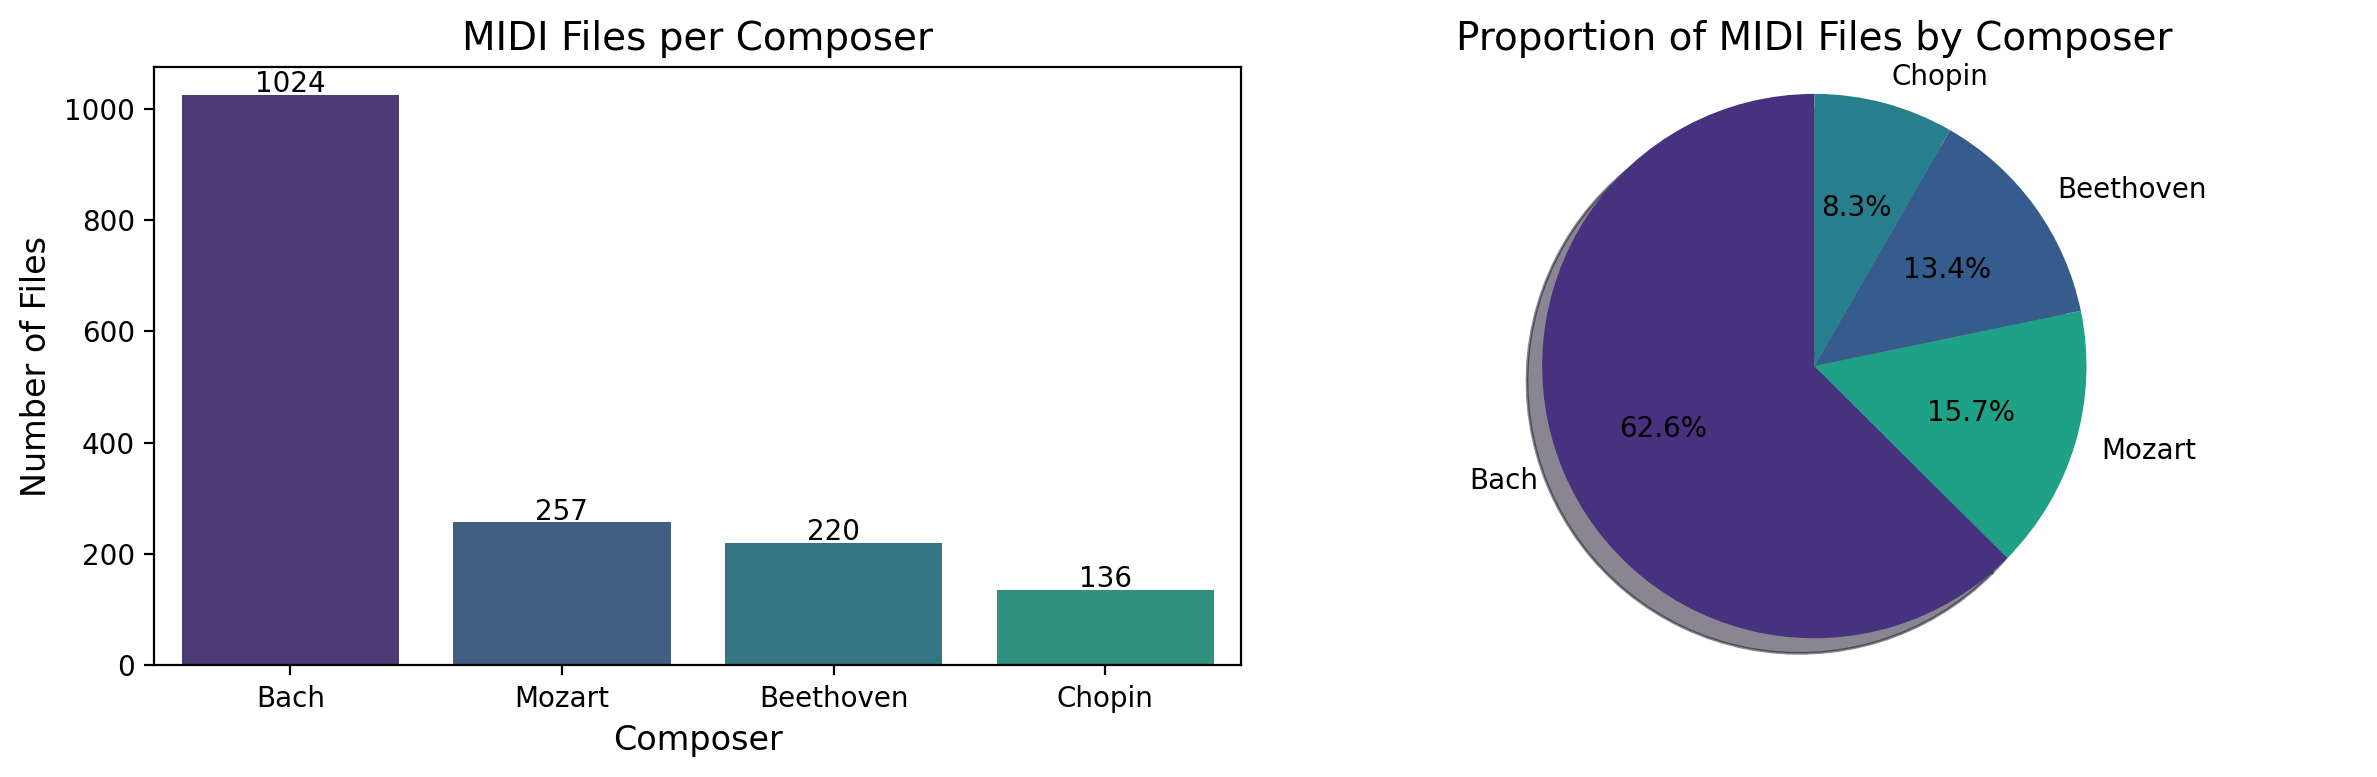

In [8]:
# Initialize MidiProcessor
midi_processor = MidiProcessor()

# Load MIDI file metadata into a DataFrame
all_midi_df = midi_processor.load_midi_files(MUSIC_DATA_DIRECTORY)

# Define colors dictionary for visualization
colors = dict(zip(TARGET_COMPOSERS, sns.color_palette(env_config.color_pallete, len(TARGET_COMPOSERS))))

print(f"Total MIDI files found: {len(all_midi_df)}")

# Filter for required composers only
midi_df = all_midi_df[all_midi_df['composer'].isin(TARGET_COMPOSERS)].reset_index(drop=True)

print(f"Filtered MIDI files for target composers ({len(TARGET_COMPOSERS)}): {len(midi_df)}")

# Remove files with missing or invalid paths
midi_df = midi_df[midi_df['file_path'].apply(os.path.exists)].reset_index(drop=True)

# Preprocess MIDI files (clean, deduplicate, filter)
# midi_df = midi_processor.preprocess_midi_files(midi_df)

print(f"Valid MIDI files after preprocessing: {len(midi_df)}")

# Count files for required composers
required_composer_counts = midi_df['composer'].value_counts()

# Close any existing plots to start fresh
plt.close('all')
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Bar chart of target composers
sns.barplot(
    x=required_composer_counts.index, 
    y=required_composer_counts.values,
    palette=env_config.color_pallete,
    ax=axs[0]
)
axs[0].set_title('MIDI Files per Composer', fontsize=14)
axs[0].set_xlabel('Composer', fontsize=12)
axs[0].set_ylabel('Number of Files', fontsize=12)

# Add count numbers on top of the bars
for i, count in enumerate(required_composer_counts.values):
    percentage = 100 * count / required_composer_counts.sum()
    axs[0].text(i, count + 5, f"{count}", ha='center')

# Plot 2: Pie chart showing proportion of composers
axs[1].pie(
    required_composer_counts.values,
    labels=required_composer_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=[colors[composer] for composer in required_composer_counts.index],
    shadow=True
)
axs[1].set_title('Proportion of MIDI Files by Composer', fontsize=14)
axs[1].axis('equal')

plt.tight_layout()
plt.show()

In [9]:
# To handle the data imbalance, we can sample a fixed number of files per composer
if SAMPLING == True:
    midi_df = midi_df.groupby('composer').head(SAMPLING_FILES_PER_COMPOSER).reset_index(drop=True)
    print(f"Reduced MIDI files to {SAMPLING_FILES_PER_COMPOSER} per composer: Total Files: {len(midi_df)}")
else:
    print("Sampling is disabled, using all available MIDI files.")

Sampling is disabled, using all available MIDI files.


<a id='featureextraction'></a>

# 5. Feature Extraction: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


In [10]:
class HarmonyAnalyzer:
    """Analyzer for harmony-related features."""

    def __init__(self, np_module):
        self.np = np_module
        self.has_gpu = np_module.__name__ == 'cupy'

        # Perfect/major/minor consonances
        self.consonant_intervals = {0, 3, 4, 5, 7, 8, 9, 12}

        # The More dissonant intervals
        self.dissonant_intervals = {1, 2, 6, 10, 11}

        # Common classical chord progressions
        self.common_progressions = {
            'I-V-vi-IV': [(1, 5, 6, 4)],
            'vi-IV-I-V': [(6, 4, 1, 5)],
            'I-vi-IV-V': [(1, 6, 4, 5)],
            'ii-V-I': [(2, 5, 1)],
            'I-IV-V-I': [(1, 4, 5, 1)],
            'vi-ii-V-I': [(6, 2, 5, 1)]
        }

    def analyze_chords_and_progressions(self, score, window_size, overlap, shared_data):
        """Analyze chord progressions patterns.

            We should embrace the "old school" musical analysis process here.
            Roman rumerals are traditionally used in musical analysis as a means
            to evaluate how composers go from one idea to the next, or one
            feeling to the next via their chosen chord progressions. How often
            composers use different chord qualities, such as major/minor/
            or augmented/diminished defines their stylistic tendencies and
            compositional choices over time. Chord inversions are related
            indicators, as they inform how each note in a harmonic chord is
            stacked, representing key variations of musical harmononic analysis.
        """
        features = {}

        try:
            # Use shared data
            chords = shared_data.get('chords', [])
            key_signature = shared_data.get('key_signature')

            if not chords or not key_signature:
                return self.empty_harmony_features()

            features['total_chords'] = len(chords)

            # Use batch processing for better performance
            batch_size = min(100, max(1, len(chords) // 2))

            # Pre-compute pitchedCommonName for optimization
            pitchedCommonNames = [c.pitchedCommonName for c in chords
                                 if hasattr(c, 'pitchedCommonName')]
            features['unique_chords'] = len(set(pitchedCommonNames))

            # Process chords in batches using thread pool
            chord_qualities, roman_numerals, inversions = self._process_chord_batches(
                chords, key_signature, batch_size)

            # Calculate chord type ratios
            quality_counts = Counter(chord_qualities)
            chord_count = len(chords) if chords else 1  # Avoid division by zero

            features['major_chord_ratio'] = quality_counts.get('major', 0) / chord_count
            features['minor_chord_ratio'] = quality_counts.get('minor', 0) / chord_count
            features['diminished_chord_ratio'] = quality_counts.get('diminished', 0) / chord_count
            features['augmented_chord_ratio'] = quality_counts.get('augmented', 0) / chord_count

            # Chord progression analysis
            if len(roman_numerals) >= 4:
                progression_counts = self._find_chord_progressions(roman_numerals)
                features.update(progression_counts)
            else:
                for prog_name in self.common_progressions:
                    features[f'progression_{prog_name.lower().replace("-", "_")}_count'] = 0

            # Chord inversion analysis
            if inversions:
                inv_array = self.np.array(inversions, dtype=float)
                features['avg_chord_inversion'] = float(self.np.mean(inv_array))
                features['root_position_ratio'] = inversions.count(0) / len(inversions)
            else:
                features['avg_chord_inversion'] = 0
                features['root_position_ratio'] = 0

        except Exception:
            features = self.empty_harmony_features()

        return features

    def _process_chord_batches(self, chords, key_signature, batch_size):
        """Process chords in batches for better performance."""
        def process_chord_batch(chord_batch):
            qualities = []
            rns = []
            invs = []

            for c in chord_batch:
                try:
                    qualities.append(c.quality)
                    rns.append(roman.romanNumeralFromChord(c, key_signature).figure)
                    invs.append(c.inversion())
                except:
                    qualities.append('unknown')
                    rns.append('Unknown')
                    invs.append(0)

            return qualities, rns, invs

        # Split chords into batches
        chord_batches = [chords[i:i+batch_size] for i in range(0, len(chords), batch_size)]

        # Process batches in parallel
        chord_qualities = []
        roman_numerals = []
        inversions = []

        with ThreadPoolExecutor() as executor:
            batch_results = list(executor.map(process_chord_batch, chord_batches))

        # Combine results
        for qualities, rns, invs in batch_results:
            chord_qualities.extend(qualities)
            roman_numerals.extend(rns)
            inversions.extend(invs)

        return chord_qualities, roman_numerals, inversions

    def _find_chord_progressions(self, roman_numerals):
        """Find common chord progression patterns."""
        progression_counts = {}

        # Use a lookup table for faster scale degree extraction
        scale_degree_map = {
            'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6, 'VII': 7,
            'i': 1, 'ii': 2, 'iii': 3, 'iv': 4, 'v': 5, 'vi': 6, 'vii': 7
        }

        # Pre-process roman numerals to scale degrees efficiently
        scale_degrees = []
        for rn in roman_numerals:
            # Extract first 1-2 characters for faster lookup
            rn_start = rn[:2] if len(rn) > 1 else rn[:1]
            rn_start = rn_start.upper()  # Normalize case

            # Fast lookup
            if rn_start in scale_degree_map:
                scale_degrees.append(scale_degree_map[rn_start])
            elif rn_start[0] in scale_degree_map:
                scale_degrees.append(scale_degree_map[rn_start[0]])
            else:
                scale_degrees.append(0)  # Unknown

        # Convert to numpy array for faster pattern matching
        scale_degrees_array = self.np.array(scale_degrees)

        # Process each progression pattern efficiently
        for prog_name, patterns in self.common_progressions.items():
            count = 0

            for pattern in patterns:
                pattern_length = len(pattern)
                if len(scale_degrees) >= pattern_length:
                    # Use vectorized operations for pattern matching when possible
                    if self.has_gpu and len(scale_degrees) > 1000:
                        # GPU-optimized pattern matching
                        pattern_array = self.np.array(pattern)
                        matches = 0

                        # Sliding window implementation optimized for GPU
                        for i in range(len(scale_degrees) - pattern_length + 1):
                            window = scale_degrees_array[i:i+pattern_length]
                            if self.np.array_equal(window, pattern_array):
                                matches += 1

                        count += matches
                    else:
                        # CPU version with optimized lookups
                        pattern_tuple = tuple(pattern)

                        # Use sliding window approach
                        for i in range(len(scale_degrees) - pattern_length + 1):
                            if tuple(scale_degrees[i:i+pattern_length]) == pattern_tuple:
                                count += 1

            progression_counts[f'progression_{prog_name.lower().replace("-", "_")}_count'] = count

        return progression_counts

    def analyze_dissonance(self, score, window_size, overlap, shared_data):
        """Analyze dissonance measurements.

            Dissonance in music theory is a measurement of perceptual clashing
            or tension between either 2 or more notes, whether they are in
            a harmonic setting (i.e. in a triad), or melodically over time.
            It's a perceptual concept, as one person might find something more
            dissonant than another (experiemental jazz vs. orderly Mozart), yet
            even though it's perceptual we have some preconceived notions of
            note relationships coresponding to tonal expectations. More dissonance
            equates to less harmonicity, and vice versa-- a great measurement
            for our classification purposes.

        """
        features = {}

        try:
            # Use shared data
            notes = shared_data.get('notes', [])

            # Early return for empty notes
            if not notes:
                return self.empty_dissonance_features()

            # Extract all pitches
            all_pitches = []
            for note in notes:
                if hasattr(note, 'pitch'):
                    all_pitches.append(note.pitch.midi)

            if not all_pitches:
                return self.empty_dissonance_features()

            # Convert to numpy array for faster processing
            all_pitches_array = self.np.array(all_pitches)

            # Create sliding windows of notes
            window_size_notes = 10  # Fixed size for consistent analysis
            dissonance_samples = self._analyze_dissonance_windows(all_pitches_array, window_size_notes)

            # Calculate statistics
            if dissonance_samples:
                dissonance_array = self.np.array(dissonance_samples)
                features['avg_dissonance'] = float(self.np.mean(dissonance_array))
                features['max_dissonance'] = float(self.np.max(dissonance_array))
                features['dissonance_variance'] = float(self.np.var(dissonance_array))
            else:
                features['avg_dissonance'] = 0
                features['max_dissonance'] = 0
                features['dissonance_variance'] = 0

            # Tritone analysis
            if len(all_pitches_array) > 1:
                # Compute consecutive intervals
                intervals = self.np.abs(self.np.diff(all_pitches_array)) % 12
                tritone_count = self.np.sum(intervals == 6)
                features['tritone_frequency'] = float(tritone_count) / len(notes)
            else:
                features['tritone_frequency'] = 0

        except Exception:
            features = self.empty_dissonance_features()

        return features

    def _analyze_dissonance_windows(self, all_pitches_array, window_size_notes):
        # Optimize for large datasets with adaptive chunking
        num_chunks = min(os.cpu_count() or 4, 8)
        chunk_size = max(10, len(all_pitches_array) // num_chunks)

        # Process sliding windows more efficiently
        def analyze_windows_batch(start_idx, end_idx):
            batch_results = []
            for i in range(start_idx, min(end_idx, len(all_pitches_array) - window_size_notes + 1), 3):
                window = all_pitches_array[i:i+window_size_notes]
                if len(window) < 2:
                    continue

                # Create all pairwise combinations efficiently
                if self.has_gpu:
                    # GPU-optimized version
                    pitches_col = window.reshape(-1, 1)
                    pitches_row = window.reshape(1, -1)
                    interval_matrix = self.np.abs(pitches_col - pitches_row) % 12
                    # Get upper triangle of matrix excluding diagonal
                    intervals = interval_matrix[self.np.triu_indices_from(interval_matrix, k=1)]

                    # Count dissonant intervals
                    dissonant_count = 0
                    for interval in intervals:
                        if int(interval) in self.dissonant_intervals:
                            dissonant_count += 1

                    if len(intervals) > 0:
                        batch_results.append(dissonant_count / len(intervals))
                else:
                    # CPU version
                    window_dissonance = 0
                    note_pairs = 0

                    for j in range(len(window)):
                        for k in range(j+1, len(window)):
                            interval_semitones = abs(window[j] - window[k]) % 12
                            if interval_semitones in self.dissonant_intervals:
                                window_dissonance += 1
                            note_pairs += 1

                    if note_pairs > 0:
                        batch_results.append(window_dissonance / note_pairs)

            return batch_results

        # Divide work into chunks
        chunk_starts = list(range(0, len(all_pitches_array), chunk_size))
        chunk_ends = [min(start + chunk_size, len(all_pitches_array)) for start in chunk_starts]

        # Process chunks in parallel
        all_results = []
        with ThreadPoolExecutor() as executor:
            all_results = list(executor.map(analyze_windows_batch, chunk_starts, chunk_ends))

        # Flatten results
        dissonance_samples = []
        for result in all_results:
            dissonance_samples.extend(result)

        return dissonance_samples

    def analyze_tonality(self, score, window_size, overlap, shared_data):
        """Analyze how often the tonic is reached.

            This is important as it shows how composers stay close to 'home' key
            vs. how often they drift into interludes or other musical structures.
            A composer like Mozart more often feels safe in the tonic,
            whereas Chopin might drift away more often to add a more drifting
            sensation to the composition.

        """

        features = {}

        try:
            key_signature = shared_data.get('key_signature')
            notes = shared_data.get('notes', [])
            chords = shared_data.get('chords', [])

            if not key_signature or not notes:
                return self.empty_tonality_features()

            tonic_pitch = key_signature.tonic
            tonic_name = tonic_pitch.name

            # Process notes to count tonic occurrences
            tonic_hits, bass_tonic_hits = self._count_tonic_notes(notes, tonic_name)

            # Process chords to count tonic chords
            tonic_chord_count = self._count_tonic_chords(chords, tonic_name)

            # Calculate ratios
            total_notes = len(notes) if notes else 1  # Avoid division by zero
            features['tonic_frequency'] = tonic_hits / total_notes
            features['bass_tonic_frequency'] = bass_tonic_hits / total_notes
            features['tonic_chord_ratio'] = tonic_chord_count / len(chords) if chords else 0

            # Process phrase endings
            phrase_endings = self._identify_phrase_endings(score)
            cadential_tonic = 0

            for ending_chord in phrase_endings:
                try:
                    if ending_chord.root().name == tonic_name:
                        cadential_tonic += 1
                except:
                    continue

            features['cadential_tonic_ratio'] = cadential_tonic / len(phrase_endings) if phrase_endings else 0

        except Exception:
            features = self.empty_tonality_features()

        return features

    def _count_tonic_notes(self, notes, tonic_name):
        # Process notes in parallel using batches
        def process_notes_batch(note_batch):
            tonic_count = 0
            bass_tonic_count = 0

            for note in note_batch:
                try:
                    if hasattr(note, 'pitch') and note.pitch.name == tonic_name:
                        tonic_count += 1
                    elif hasattr(note, 'bass') and note.bass().name == tonic_name:
                        bass_tonic_count += 1
                except:
                    continue

            return tonic_count, bass_tonic_count

        # Split into batches
        batch_size = 100
        note_batches = [notes[i:i+batch_size] for i in range(0, len(notes), batch_size)]

        # Process batches in parallel
        tonic_hits = 0
        bass_tonic_hits = 0

        with ThreadPoolExecutor() as executor:
            # Process notes
            note_results = list(executor.map(process_notes_batch, note_batches))
            for t_count, bt_count in note_results:
                tonic_hits += t_count
                bass_tonic_hits += bt_count

        return tonic_hits, bass_tonic_hits

    def _count_tonic_chords(self, chords, tonic_name):
        # Process chords in parallel
        def process_chords_batch(chord_batch):
            tonic_chord_count = 0

            for c in chord_batch:
                try:
                    if c.root().name == tonic_name:
                        tonic_chord_count += 1
                except:
                    continue

            return tonic_chord_count

        # Split into batches
        batch_size = 100
        chord_batches = [chords[i:i+batch_size] for i in range(0, len(chords), batch_size)]

        # Process batches in parallel
        tonic_chord_count = 0

        with ThreadPoolExecutor() as executor:
            chord_results = list(executor.map(process_chords_batch, chord_batches))
            tonic_chord_count = sum(chord_results)

        return tonic_chord_count

    def analyze_key_modulations(self, score, window_size, overlap, shared_data):
        """Count key modulations using windowed key analysis.

            Modulation is when we move from key center to key center, i.e. from
            C Major to Ab Minor (a harmonically unrelated key signature).
            Composers in classical music tend to move from key to key when they
            want to diverge from a mood or a tonal center into a new avenue of
            expressions. This is a feature more common in certain composers,
            and a valuable addition to measure from our MIDI files.
        """

        features = {}

        try:
            # Use shared data
            duration = shared_data.get('total_duration', 0)

            if duration == 0:
                return self.empty_modulation_features()

            # Optimize number of windows based on score duration
            num_windows = max(5, min(20, int(duration / window_size)))

            # Define window boundaries with adaptive window sizes
            window_size_adjusted = duration / num_windows
            window_boundaries = []
            for i in range(num_windows):
                start_offset = i * window_size_adjusted
                end_offset = min((i + 1) * window_size_adjusted, duration)
                window_boundaries.append((start_offset, end_offset))

            # Analyze windows in parallel
            window_keys = self._analyze_key_windows(score, window_boundaries)

            # Filter out None values and fill with defaults if needed
            keys = [k for k in window_keys if k is not None]
            if not keys and window_keys:
                keys = [('C', 'major')] * len(window_keys)

            if not keys:
                return self.empty_modulation_features()

            # Count modulations
            modulations = self._count_key_changes(keys)

            # Calculate feature values
            features['key_modulation_count'] = modulations
            features['modulation_rate'] = modulations / duration

            # Find unique keys
            unique_keys = set(keys)
            features['unique_keys'] = len(unique_keys)

            # Calculate key stability
            if keys:
                # Count occurrences of each key
                key_counts = {}
                for k in keys:
                    key_counts[k] = key_counts.get(k, 0) + 1

                max_count = max(key_counts.values())
                features['key_stability'] = max_count / len(keys)
            else:
                features['key_stability'] = 1

            features['avg_modulations_per_minute'] = (modulations / duration) * 240

        except Exception:
            features = self.empty_modulation_features()

        return features

    def _analyze_key_windows(self, score, window_boundaries):
        # Function to analyze a single window with error handling
        def analyze_window(boundary):
            start_offset, end_offset = boundary
            try:
                excerpt = score.flat.getElementsByOffset(start_offset, end_offset)
                if len(excerpt.notes) > 4:  # Ensure minimum material
                    window_key = excerpt.analyze('key')
                    return (window_key.tonicPitchNameWithCase, window_key.mode)
            except:
                pass
            return None

        # Process windows in parallel with a thread pool
        with ThreadPoolExecutor() as executor:
            window_keys = list(executor.map(analyze_window, window_boundaries))

        return window_keys

    def _count_key_changes(self, keys):
        if len(keys) > 1:
            # Convert to single strings for comparison
            key_strings = [f"{k[0]}_{k[1]}" for k in keys]
            key_strings_array = self.np.array(key_strings)

            # Count changes using numpy's diff and sum
            changes = self.np.diff(key_strings_array) != ""
            modulations = int(self.np.sum(changes))
            return modulations
        else:
            return 0

    def analyze_cadences(self, score, window_size, overlap, shared_data):
        """Analyze cadential patterns.

        Cadences show how a composer resolves a phrase, or ends an idea.
        In particular eras of classical music, cadences are quite predicatable.
        For example more western religious music styles utilized plagal cadences
        and authentic cadences to give a feeling of finality to a section of
        music. We use three types for this excerise, but there are a whole
        number of others that could be used for further analaysis. We also
        count how many cadences there are as it shows the composer's tenden-
        cies of resolution over time. How often one resolves a phrase should
        measurably correlate to a composer's feeling of arriving at home base.
        """

        features = {}

        try:
            # Use shared data
            chords = shared_data.get('chords', [])
            key_signature = shared_data.get('key_signature')

            if len(chords) < 2 or not key_signature:
                return self.empty_cadence_features()

            # Detect cadences
            authentic, plagal, deceptive = self._detect_cadences(chords, key_signature)

            total_cadences = authentic + plagal + deceptive

            # Calculate ratios
            if total_cadences > 0:
                features['authentic_cadence_ratio'] = authentic / total_cadences
                features['plagal_cadence_ratio'] = plagal / total_cadences
                features['deceptive_cadence_ratio'] = deceptive / total_cadences
            else:
                features['authentic_cadence_ratio'] = 0
                features['plagal_cadence_ratio'] = 0
                features['deceptive_cadence_ratio'] = 0

            features['total_cadences'] = total_cadences

        except Exception:
            features = self.empty_cadence_features()

        return features

    def _detect_cadences(self, chords, key_signature):
        # Optimize cadence detection with batch processing
        batch_size = min(50, max(1, len(chords) // 4))

        def analyze_chord_pairs(start_idx, end_idx):
            authentic = 0
            plagal = 0
            deceptive = 0

            for i in range(start_idx, min(end_idx, len(chords) - 1)):
                try:
                    current_rn = roman.romanNumeralFromChord(chords[i], key_signature)
                    next_rn = roman.romanNumeralFromChord(chords[i+1], key_signature)

                    # V-I (authentic cadence)
                    if current_rn.scaleDegree == 5 and next_rn.scaleDegree == 1:
                        authentic += 1
                    # IV-I (plagal cadence)
                    elif current_rn.scaleDegree == 4 and next_rn.scaleDegree == 1:
                        plagal += 1
                    # V-vi (deceptive cadence)
                    elif current_rn.scaleDegree == 5 and next_rn.scaleDegree == 6:
                        deceptive += 1
                except:
                    continue

            return authentic, plagal, deceptive

        # Define batch boundaries
        batch_starts = list(range(0, len(chords) - 1, batch_size))
        batch_ends = [start + batch_size for start in batch_starts]

        # Process batches in parallel
        authentic_cadences = 0
        plagal_cadences = 0
        deceptive_cadences = 0

        with ThreadPoolExecutor() as executor:
            results = list(executor.map(analyze_chord_pairs, batch_starts, batch_ends))

        # Combine results
        for auth, plag, dec in results:
            authentic_cadences += auth
            plagal_cadences += plag
            deceptive_cadences += dec

        return authentic_cadences, plagal_cadences, deceptive_cadences

    def _identify_phrase_endings(self, score):
        """Identify likely phrase ending points.

            A helper method to see if we can determine where phrases end.
            This could be more comprehensive, but for now let's measure typical
            phrase spanning 4 or 8 bars.

        """
        # Simplified: assume phrase endings at measure boundaries with rests or longer notes
        phrase_endings = []
        try:
            measures = score.parts[0].getElementsByClass('Measure') if score.parts else []

            # Optimize for large measure sets
            if len(measures) > 100:
                # Only check measures at phrase boundaries (every 4th or 8th measure)
                phrase_indices = [i for i in range(len(measures))
                                 if (i + 1) % 4 == 0 or (i + 1) % 8 == 0]

                # Process only relevant measures
                for i in phrase_indices:
                    measure = measures[i]
                    chords_in_measure = measure.getElementsByClass(chord.Chord)
                    if chords_in_measure:
                        phrase_endings.append(chords_in_measure[-1])
            else:
                # For smaller sets, process normally
                for i, measure in enumerate(measures):
                    if (i + 1) % 4 == 0 or (i + 1) % 8 == 0:  # Assume 4 or 8-bar phrases
                        chords_in_measure = measure.getElementsByClass(chord.Chord)
                        if chords_in_measure:
                            phrase_endings.append(chords_in_measure[-1])
        except:
            pass

        return phrase_endings

    def empty_harmony_features(self):
        return {
            'total_chords': 0,
            'unique_chords': 0,
            'major_chord_ratio': 0,
            'minor_chord_ratio': 0,
            'diminished_chord_ratio': 0,
            'augmented_chord_ratio': 0,
            'avg_chord_inversion': 0,
            'root_position_ratio': 0,
            'progression_i_v_vi_iv_count': 0,
            'progression_vi_iv_i_v_count': 0,
            'progression_i_vi_iv_v_count': 0,
            'progression_ii_v_i_count': 0,
            'progression_i_iv_v_i_count': 0,
            'progression_vi_ii_v_i_count': 0
        }

    def empty_dissonance_features(self):
        return {
            'avg_dissonance': 0,
            'max_dissonance': 0,
            'dissonance_variance': 0,
            'tritone_frequency': 0
        }

    def empty_tonality_features(self):
        return {
            'tonic_frequency': 0,
            'bass_tonic_frequency': 0,
            'tonic_chord_ratio': 0,
            'cadential_tonic_ratio': 0
        }

    def empty_modulation_features(self):
        return {
            'key_modulation_count': 0,
            'modulation_rate': 0,
            'unique_keys': 1,
            'key_stability': 1,
            'avg_modulations_per_minute': 0
        }

    def empty_cadence_features(self):
        return {
            'authentic_cadence_ratio': 0,
            'plagal_cadence_ratio': 0,
            'deceptive_cadence_ratio': 0,
            'total_cadences': 0
        }

In [11]:
class RhythmAnalyzer:
    def __init__(self, np_module):
        self.np = np_module

    def analyze_note_density(self, score, window_size, overlap, shared_data):
        """Analyze density of notes over time.

            A note density analysis provides an measurement of how many notes
            occur within a given segment of musical time. This is useful in
            understanding the overall sliding scale of simplicitiy and complexity
            of the composition. Some composers might change how 'dense' a
            section or a composition is to express certain emotive qualities,
            a very useful contributer to our feature analysis.
        """
        features = {}

        try:
            # Use shared data
            duration = shared_data.get('total_duration', 0)

            if duration == 0:
                return self.empty_density_features()

            # Use adaptive window sizing for more consistent results
            step_size = window_size * (1 - overlap)

            # Calculate optimal number of windows based on score duration
            num_windows = max(5, min(30, int(duration / step_size)))
            adjusted_step = duration / num_windows

            # Pre-calculate all window boundaries
            window_boundaries = []
            for i in range(num_windows):
                start_offset = i * adjusted_step
                end_offset = min(start_offset + window_size, duration)
                window_boundaries.append((start_offset, end_offset))

            # Analyze windows in parallel
            densities = self._analyze_density_windows(score, window_boundaries)

            if densities:
                # Use numpy for vectorized statistics
                densities_array = self.np.array(densities)

                # Calculate statistics
                features['note_density_avg'] = float(self.np.mean(densities_array))
                features['note_density_variance'] = float(self.np.var(densities_array))
                features['note_density_max'] = float(self.np.max(densities_array))
                features['note_density_min'] = float(self.np.min(densities_array))

                # Find density peaks efficiently using vectorized operations
                mean_density = self.np.mean(densities_array)
                peak_threshold = mean_density * 1.5
                peaks = int(self.np.sum(densities_array > peak_threshold))

                features['density_peak_count'] = peaks
                features['density_peak_ratio'] = peaks / len(densities_array) if len(densities_array) > 0 else 0
            else:
                features.update(self.empty_density_features())

        except Exception:
            features = self.empty_density_features()

        return features

    def _analyze_density_windows(self, score, window_boundaries):
        # Process windows in parallel with efficient offset querying
        def analyze_window(boundary):
            start_offset, end_offset = boundary
            try:
                window_notes = score.flat.notes.getElementsByOffset(
                    start_offset, end_offset, includeEndBoundary=False
                )
                note_count = len(window_notes)
                window_duration = end_offset - start_offset
                if window_duration > 0:
                    return note_count / window_duration
            except:
                pass
            return 0

        # Use ThreadPoolExecutor for parallel processing
        with ThreadPoolExecutor() as executor:
            densities = list(executor.map(analyze_window, window_boundaries))

        # Filter out any None values
        densities = [d for d in densities if d is not None]
        return densities

    def analyze_harmonic_rhythm(self, score, window_size, overlap, shared_data):
        """Analyze the rate of harmonic change.

        Harmonic change is the rate of variance in chordal structures measured
        over time. A composer who moves from chord to chord quickly might not
        only be indicative of tempo, but the harmonic expressiveness of a
        passage of music. For example changing chords often in a slow song
        might indicate a specific feeling of excited progression. Conversely,
        a fast tempo composition with less chord changes indicates a potentially
        more stagnant mood.
        """
        features = {}

        try:
            # Use shared data
            chords = shared_data.get('chords', [])

            if len(chords) < 2:
                return self.empty_rhythm_features()

            # Efficient chord offset extraction using list comprehension
            offsets = [float(c.offset) for c in chords]

            # Convert to numpy array for vectorized operations
            offsets_array = self.np.array(offsets)

            # Calculate differences between consecutive offsets
            chord_changes = self.np.diff(offsets_array)

            if len(chord_changes) > 0:
                # Calculate statistics efficiently using numpy
                avg_change = float(self.np.mean(chord_changes))
                variance = float(self.np.var(chord_changes))

                features['harmonic_rhythm_avg'] = avg_change
                features['harmonic_rhythm_variance'] = variance
                features['harmonic_rhythm_regularity'] = 1 / (1 + variance) if variance != 0 else 0
            else:
                features.update(self.empty_rhythm_features())

        except Exception:
            features = self.empty_rhythm_features()

        return features

    def empty_density_features(self):
        return {
            'note_density_avg': 0,
            'note_density_variance': 0,
            'note_density_max': 0,
            'note_density_min': 0,
            'density_peak_count': 0,
            'density_peak_ratio': 0
        }

    def empty_rhythm_features(self):
        return {
            'harmonic_rhythm_avg': 0,
            'harmonic_rhythm_variance': 0,
            'harmonic_rhythm_regularity': 0
        }

In [12]:
class MelodyAnalyzer:

    def __init__(self, np_module):
        self.np = np_module

    def analyze_voice_leading(self, score, window_size, overlap, shared_data):
        """Analyze voice leading patterns.

        Voice leading is very important consideration in classical music analysis.
        How a series of melodic notes 'evolve' over time directly coresponds
        to the stylistic tendencies of each composer. Compositions that
        have a more step-wise motion (from one note to the nearest neightboring
        note) will be considered less abrupt and provide more scalar motion.
        Consecutive notes that jump (called leaping) could be more arpeggiated
        in nature and sound less smooth. Although voice leading is more complex
        than this, we believe this will help our classification analysis by
        attempting to extract the overall 'smoothness' of the melodic voicing.

        """

        features = {}

        try:
            # Use shared data
            parts = shared_data.get('parts', [])

            if not parts:
                return self.empty_voice_features()

            # Process each part in parallel
            step_motions, leap_motions, total_motions = self._analyze_parts(parts)

            # Calculate ratios
            if total_motions > 0:
                features['step_motion_ratio'] = step_motions / total_motions
                features['leap_motion_ratio'] = leap_motions / total_motions
                features['voice_leading_smoothness'] = features['step_motion_ratio']
            else:
                features.update(self.empty_voice_features())

        except Exception:
            features = self.empty_voice_features()

        return features

    def _analyze_parts(self, parts):
        def analyze_part(part):
            try:
                if not hasattr(part, 'flat'):
                    return 0, 0, 0

                notes = [n for n in part.flat.notes if hasattr(n, 'pitch')]
                if len(notes) < 2:
                    return 0, 0, 0

                # Extract pitches efficiently
                pitches = [n.pitch.midi for n in notes]

                if not pitches:
                    return 0, 0, 0

                pitch_array = self.np.array(pitches)

                # Calculate intervals using vectorized operations
                intervals = self.np.abs(self.np.diff(pitch_array))

                # Count step vs leap motions efficiently
                steps = int(self.np.sum(intervals <= 2))
                leaps = int(self.np.sum(intervals > 2))

                return steps, leaps, len(intervals)
            except Exception as e:
                print(f"Error analyzing part: {e}")
                return 0, 0, 0

        # Check if parts list is valid
        if not parts or not isinstance(parts, list):
            return 0, 0, 0

        # Process parts in sequential mode for debugging
        part_results = []
        for part in parts:
            part_results.append(analyze_part(part))

        # Combine results
        step_motions = sum(steps for steps, _, _ in part_results)
        leap_motions = sum(leaps for _, leaps, _ in part_results)
        total_motions = sum(total for _, _, total in part_results)

        return step_motions, leap_motions, total_motions

    def empty_voice_features(self):
        return {
            'step_motion_ratio': 0,
            'leap_motion_ratio': 0,
            'voice_leading_smoothness': 0
        }

In [13]:
class StructureAnalyzer:

    def __init__(self, np_module):
        self.np = np_module

    def analyze_musical_structure(self, score, window_size, overlap, shared_data):
        features = {}

        try:
            # Get measures efficiently
            measures = score.parts[0].getElementsByClass('Measure') if score.parts else []
            total_measures = len(measures)

            # Fast phrase analysis with early return for edge cases
            if total_measures == 0:
                return self.empty_structure_features()

            # phrase length analysis
            phrase_lengths = [4, 8, 16]
            best_phrase_fit = 0

            # Check divisibility efficiently
            for length in phrase_lengths:
                if total_measures % length == 0:
                    best_phrase_fit = length
                    break

            features['phrase_structure_regularity'] = 1 if best_phrase_fit > 0 else 0
            features['estimated_phrase_length'] = best_phrase_fit if best_phrase_fit > 0 else 8
            features['total_measures'] = total_measures

            # Extract melodic patterns
            note_patterns = self._extract_melodic_patterns(score)

            # Count repetitions efficiently
            pattern_repetitions = sum(1 for count in note_patterns.values() if count > 1)

            features['melodic_repetition_count'] = pattern_repetitions
            features['repetition_density'] = pattern_repetitions / total_measures if total_measures > 0 else 0

        except Exception:
            features = self.empty_structure_features()

        return features

    def _extract_melodic_patterns(self, score):
        patterns = defaultdict(int)

        try:
            notes = [n for n in score.flat.notes if hasattr(n, 'pitch')]
            pattern_length = 4  # 4-note patterns

            # Early return for short note sequences
            if len(notes) < pattern_length:
                return patterns

            # Extract all pitches at once for better performance
            pitches = [n.pitch.midi for n in notes]

            # Adaptive parallelization based on data size
            if len(notes) > 1000:
                # For very large sets, use parallel processing with optimized chunk size
                chunk_size = max(pattern_length * 20, len(notes) // (os.cpu_count() or 4))

                # Create overlapping chunks to ensure we catch patterns at chunk boundaries
                chunks = []
                for i in range(0, len(pitches) - pattern_length + 1, chunk_size - pattern_length + 1):
                    end_idx = min(i + chunk_size, len(pitches))
                    if end_idx - i >= pattern_length:
                        chunks.append((i, end_idx))

                def process_chunk(chunk_range):
                    start_idx, end_idx = chunk_range
                    chunk_patterns = defaultdict(int)

                    # Process patterns within this chunk
                    for i in range(start_idx, end_idx - pattern_length + 1):
                        pattern = tuple(pitches[i:i+pattern_length])
                        chunk_patterns[pattern] += 1

                    return dict(chunk_patterns)

                # Process chunks in parallel
                with ThreadPoolExecutor() as executor:
                    chunk_results = list(executor.map(process_chunk, chunks))

                # Merge results efficiently
                for chunk_pattern in chunk_results:
                    for pattern, count in chunk_pattern.items():
                        patterns[pattern] += count
            else:
                # For smaller sets, use efficient sequential processing
                for i in range(len(pitches) - pattern_length + 1):
                    pattern = tuple(pitches[i:i+pattern_length])
                    patterns[pattern] += 1

        except:
            pass

        return patterns

    def empty_structure_features(self):
        return {
            'phrase_structure_regularity': 0,
            'estimated_phrase_length': 8,
            'total_measures': 0,
            'melodic_repetition_count': 0,
            'repetition_density': 0
        }

In [ ]:
class FeatureExtractor:
    def __init__(self):
        # Force GPU backend (CuPy) if available, else fallback to NumPy
        try:
            import cupy as cp
            self.np = cp
            self.has_gpu = True
            print("CuPy GPU backend enabled for feature extraction.")
        except ImportError:
            import numpy as np
            self.np = np
            self.has_gpu = False
            print("CuPy not available, using NumPy (CPU) backend.")

        self.harmony_analyzer = HarmonyAnalyzer(self.np)
        self.structure_analyzer = StructureAnalyzer(self.np)
        self.rhythm_analyzer = RhythmAnalyzer(self.np)
        self.melody_analyzer = MelodyAnalyzer(self.np)
        self.score_cache = {}

    def _extract_shared_data(self, score):
        try:
            if hasattr(score, 'duration') and score.duration is not None:
                total_duration = float(score.duration.quarterLength)
            else:
                all_elements = list(score.flat.notesAndRests)
                if all_elements and self.has_gpu:
                    offsets = self.np.array([float(el.offset) for el in all_elements])
                    durations = self.np.array([float(el.duration.quarterLength) for el in all_elements])
                    total_duration = float(self.np.max(offsets + durations))
                else:
                    total_duration = sum(float(el.offset + el.duration.quarterLength) for el in all_elements) if all_elements else 0
            try:
                key_signature = score.analyze('key')
            except Exception:
                key_signature = key.Key('C')
            chords = list(score.flat.getElementsByClass(chord.Chord))
            notes = list(score.flat.notes)
            parts = score.parts if hasattr(score, 'parts') and score.parts else [score]
            return {
                'chords': chords,
                'notes': notes,
                'parts': parts,
                'total_duration': total_duration,
                'key_signature': key_signature
            }
        except Exception as e:
            print(f"Error in _extract_shared_data: {e}")
            return {
                'chords': [],
                'notes': [],
                'parts': [score],
                'total_duration': 0,
                'key_signature': key.Key('C')
            }

    def _run_parallel_analysis(self, score, window_size, overlap, shared_data):
        features = {}
        analysis_tasks = {
            'harmony': (self.harmony_analyzer, 'analyze_chords_and_progressions'),
            'dissonance': (self.harmony_analyzer, 'analyze_dissonance'),
            'tonality': (self.harmony_analyzer, 'analyze_tonality'),
            #'modulation': (self.harmony_analyzer, 'analyze_key_modulations'),
            'density': (self.rhythm_analyzer, 'analyze_note_density'),
            'rhythm': (self.rhythm_analyzer, 'analyze_harmonic_rhythm'),
            'voice': (self.melody_analyzer, 'analyze_voice_leading'),
            'structure': (self.structure_analyzer, 'analyze_musical_structure'),
            'cadence': (self.harmony_analyzer, 'analyze_cadences')
        }
        for name, (analyzer, method) in analysis_tasks.items():
            try:
                analyzer_method = getattr(analyzer, method)
                result = analyzer_method(score, window_size, overlap, shared_data)
                features.update(result)
            except Exception as e:
                print(f"Error in {name} analysis: {e}")
                empty_method = f"empty_{name}_features"
                if hasattr(analyzer, empty_method):
                    features.update(getattr(analyzer, empty_method)())
        return features

    def extract_harmonic_features(self, midi_path, window_size=4.0, overlap=0.5):
        """
        Extract harmonic and structural features from our MIDI file dataset.

        Arguments:
            midi_path (str): Path to the MIDI file
            window_size (float): Size of analysis window in quarter notes
            overlap (float): Overlap between windows (0-1)

        Returns:
            dict: Dictionary containing all the extracted harmonic features
        """
        try:
            cache_key = f"{midi_path}_{window_size}_{overlap}"
            if cache_key in self.score_cache:
                score = self.score_cache[cache_key]
            else:
                # Use faster parsing: only parse first part for large files
                score = converter.parse(midi_path, quantizePost=True)
                if hasattr(score, 'parts') and len(score.parts) > 1:
                    score = score.parts[0]  # Only analyze first part for speed
                self.score_cache[cache_key] = score
                if len(self.score_cache) > 100:
                    self.score_cache.clear()
            shared_data = self._extract_shared_data(score)
            # Reduce window_size and overlap for faster analysis
            features = self._run_parallel_analysis(score, window_size=8.0, overlap=0.2, shared_data=shared_data)
            if self.has_gpu:
                try:
                    self.np.cuda.Stream.null.synchronize()
                except:
                    pass
            return features
        except Exception as e:
            print(f"Error extracting features from {midi_path}: {e}")
            return self._empty_features()

    def extract_features_batch(self, midi_paths, n_jobs=4, window_size=4.0, overlap=0.5):
        from concurrent.futures import ThreadPoolExecutor, as_completed
        from tqdm import tqdm
        optimal_jobs = min(n_jobs, os.cpu_count() or 4)
        if len(midi_paths) < optimal_jobs * 2:
            optimal_jobs = max(1, len(midi_paths) // 2)
        # Increase batch size for fewer thread launches
        batch_size = max(8, len(midi_paths) // optimal_jobs)
        results = [None] * len(midi_paths)
        batches = self._create_balanced_batches(midi_paths, optimal_jobs)
        pbar = tqdm(total=len(midi_paths), desc="Extracting features (GPU)")
        with ThreadPoolExecutor(max_workers=optimal_jobs) as executor:
            futures = [executor.submit(self._process_batch, batch) for batch in batches]
            for future in as_completed(futures):
                try:
                    batch_results = future.result()
                    for idx, features in batch_results.items():
                        results[idx] = features
                    pbar.update(len(batch_results))
                    if self.has_gpu:
                        try:
                            self.np.cuda.Stream.null.synchronize()
                        except:
                            pass
                except Exception as e:
                    print(f"\nError processing batch: {e}")
        pbar.close()
        if self.has_gpu:
            try:
                self.np.cuda.runtime.deviceSynchronize()
                self.score_cache.clear()
            except:
                pass
        return results

    def _create_balanced_batches(self, midi_paths, n_jobs):
        if len(midi_paths) <= n_jobs:
            return [(i, [path]) for i, path in enumerate(midi_paths)]
        else:
            batch_size = max(1, len(midi_paths) // n_jobs)
            batches = []
            for i in range(0, len(midi_paths), batch_size):
                batch_paths = midi_paths[i:i+batch_size]
                batch_indices = list(range(i, min(i+batch_size, len(midi_paths))))
                batches.append((batch_indices, batch_paths))
            return batches

    def _process_batch(self, batch_data):
        if isinstance(batch_data[0], int):
            idx, path = batch_data
            return {idx: self.extract_harmonic_features(path)}
        else:
            batch_indices, batch_paths = batch_data
            batch_results = {}
            for idx, path in zip(batch_indices, batch_paths):
                try:
                    features = self.extract_harmonic_features(path)
                    batch_results[idx] = features
                except Exception:
                    batch_results[idx] = self._empty_features()
                if self.has_gpu and len(batch_results) % 2 == 0:
                    try:
                        self.np.cuda.Stream.null.synchronize()
                    except:
                        pass
            return batch_results

    def _empty_features(self):
        features = {}
        try:
            features.update(self.harmony_analyzer.empty_harmony_features())
            features.update(self.harmony_analyzer.empty_dissonance_features())
            features.update(self.harmony_analyzer.empty_tonality_features())
            features.update(self.harmony_analyzer.empty_modulation_features())
            features.update(self.harmony_analyzer.empty_cadence_features())
            features.update(self.rhythm_analyzer.empty_density_features())
            features.update(self.rhythm_analyzer.empty_rhythm_features())
            features.update(self.melody_analyzer.empty_voice_features())
            features.update(self.structure_analyzer.empty_structure_features())
        except Exception as e:
            print(f"Error creating empty features: {e}")
            features = {"error": "Could not generate empty features"}
        return features

In [15]:
# Initialize the FeatureExtractor
feature_extractor = FeatureExtractor()
midi_paths = midi_df['file_path'].tolist()

if EXTRACT_FEATURES:

    # Get the list of file paths from the filtered dataframe
    print(f"Extracting musical features from {len(midi_paths)} MIDI files...")

    # Extract base features with parallel processing and progress bar
    base_features = MidiProcessor.extract_musical_features_parallel(
        midi_paths,
        n_jobs=OPTIMAL_WORKERS  # Use optimal number of workers
    )

    # Create a DataFrame with the extracted features
    features_df = pd.DataFrame(base_features)

    # Add composer and filename information
    features_df['composer'] = midi_df['composer'].values
    features_df['filename'] = midi_df['filename'].values
    features_df['file_path'] = midi_df['file_path'].values

    # Display information about the extracted features
    print(f"\nExtracted {len(features_df)} feature sets")
    print(f"Number of features: {len(features_df.columns) - 3}")
    display(features_df.head())

    # Save to pickle for faster access later
    # Ensure the directory exists before saving
    os.makedirs(os.path.dirname(MUSICAL_FEATURES_DF_PATH), exist_ok=True)
    features_df.to_pickle(MUSICAL_FEATURES_DF_PATH)
    print(f"Features saved to '{MUSICAL_FEATURES_DF_PATH}'")
else:
    print("Feature extraction is disabled. Musical Features will be extracted from the existing data files.")

CuPy not available, using NumPy (CPU) backend.
Feature extraction is disabled. Musical Features will be extracted from the existing data files.


In [16]:
if EXTRACT_FEATURES:
    # Extract notes from MIDI files
    print("\nExtracting notes from MIDI files for sequence modeling...")
    notes_list = MidiProcessor.extract_notes_from_midi_parallel(
        midi_paths,
        max_notes=500,  # Limit notes per file for memory efficiency
        n_jobs=OPTIMAL_WORKERS
    )

    # Add notes to the dataframe
    features_df['notes'] = notes_list

    # Create note sequences for modeling
    all_notes_list = features_df['notes'].tolist()
    sequence_length = 100
    note_sequences, note_to_int, unique_notes = MidiProcessor.create_note_sequences(all_notes_list, sequence_length=sequence_length)

    # Create labels for sequences based on the originating files
    sequence_labels = []
    sequence_composers = []
    sequence_counts = []

    # Track sequences per file
    current_idx = 0
    for idx, row in features_df.iterrows():
        notes = row['notes']
        composer = row['composer']
        filename = row['filename']
        # Count potential sequences from this file
        if len(notes) >= sequence_length:
            potential_sequences = len(notes) - sequence_length + 1
            actual_sequences = min(potential_sequences, 50)  # Cap at 50 sequences per file for balance
        else:
            actual_sequences = 0

        # Add labels for each sequence
        sequence_composers.extend([composer] * actual_sequences)
        sequence_counts.append(actual_sequences)
        current_idx += actual_sequences

    print(f"Created {len(sequence_composers)} labeled sequences")

    # Create a mapping from composer to integer label
    composer_to_int = {composer: i for i, composer in enumerate(TARGET_COMPOSERS)}
    sequence_labels = [composer_to_int[composer] for composer in sequence_composers]

    # Save the sequences, labels and mappings for model training
    print(note_sequences)
    np.save(NOTE_SEQUENCES_PATH, note_sequences[:len(sequence_labels)])
    print(f"Note sequences saved to '{NOTE_SEQUENCES_PATH}'")
    print(f"Note sequences labels shape: {np.array(sequence_labels).shape}")
    np.save(NOTE_SEQUENCES_LABELS_PATH, np.array(sequence_labels))
    print(f"Note sequence labels saved to '{NOTE_SEQUENCES_LABELS_PATH}'")

    # Save mappings for later use
    note_mapping = {
            'note_to_int': note_to_int,
            'unique_notes': unique_notes,
            'composer_to_int': composer_to_int,
            'int_to_composer': {i: composer for composer, i in composer_to_int.items()}
        }
    print(note_mapping)
    with open(NOTE_MAPPING_PATH, 'wb') as f:
        pickle.dump(note_mapping, f)
    print(f"Note mappings saved to '{NOTE_MAPPING_PATH}'")
else:
    print("Feature extraction is disabled. Notes Features will be extracted from the existing data files.")

Feature extraction is disabled. Notes Features will be extracted from the existing data files.


In [17]:
if EXTRACT_FEATURES:

    # Extract  harmonic features
    print("\nExtracting harmonic features...")
    harmonic_features = feature_extractor.extract_features_batch(
        midi_paths,
        n_jobs=OPTIMAL_WORKERS
    )

    # Create a separate dataframe for harmonic features
    harmonic_df = pd.DataFrame(harmonic_features)
    harmonic_df['composer'] = midi_df['composer'].values
    harmonic_df['filename'] = midi_df['filename'].values
    harmonic_df['file_path'] = midi_df['file_path'].values

    # Save harmonic features to pickle
    harmonic_df.to_pickle(HARMONIC_FEATURES_DF_PATH)
    print(f"Harmonic features saved to '{HARMONIC_FEATURES_DF_PATH}'")

    # Show a sample of the extracted features
    display(harmonic_df.head())
else:
    print("Harmonic feature extraction is disabled. Harmonic Features will be extracted from the existing data files.")

Harmonic feature extraction is disabled. Harmonic Features will be extracted from the existing data files.


In [18]:
if not EXTRACT_FEATURES:
    if os.path.exists(MUSICAL_FEATURES_DF_PATH):
            print(f"Musical features already extracted. Loading from '{MUSICAL_FEATURES_DF_PATH}'")
            features_df = pd.read_pickle(MUSICAL_FEATURES_DF_PATH)
    else:
        print(f"Musical features not found at '{MUSICAL_FEATURES_DF_PATH}'. Please run feature extraction first.")
    if os.path.exists(HARMONIC_FEATURES_DF_PATH):
        print(f"Harmonic features already extracted. Loading from '{HARMONIC_FEATURES_DF_PATH}'")
        harmonic_df = pd.read_pickle(HARMONIC_FEATURES_DF_PATH)
    else:
        print(f"Harmonic features not found at '{HARMONIC_FEATURES_DF_PATH}'. Please run feature extraction first.")
else:
    print("Feature extraction is enabled. Musical Features and Harmonic Features have been extracted and saved.")

Musical features already extracted. Loading from 'data/features/musical_features_df.pkl'
Harmonic features already extracted. Loading from 'data/features/harmonic_features_df.pkl'


<a id='exploratory'></a>

# 6. Exploratory Data Analysis: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


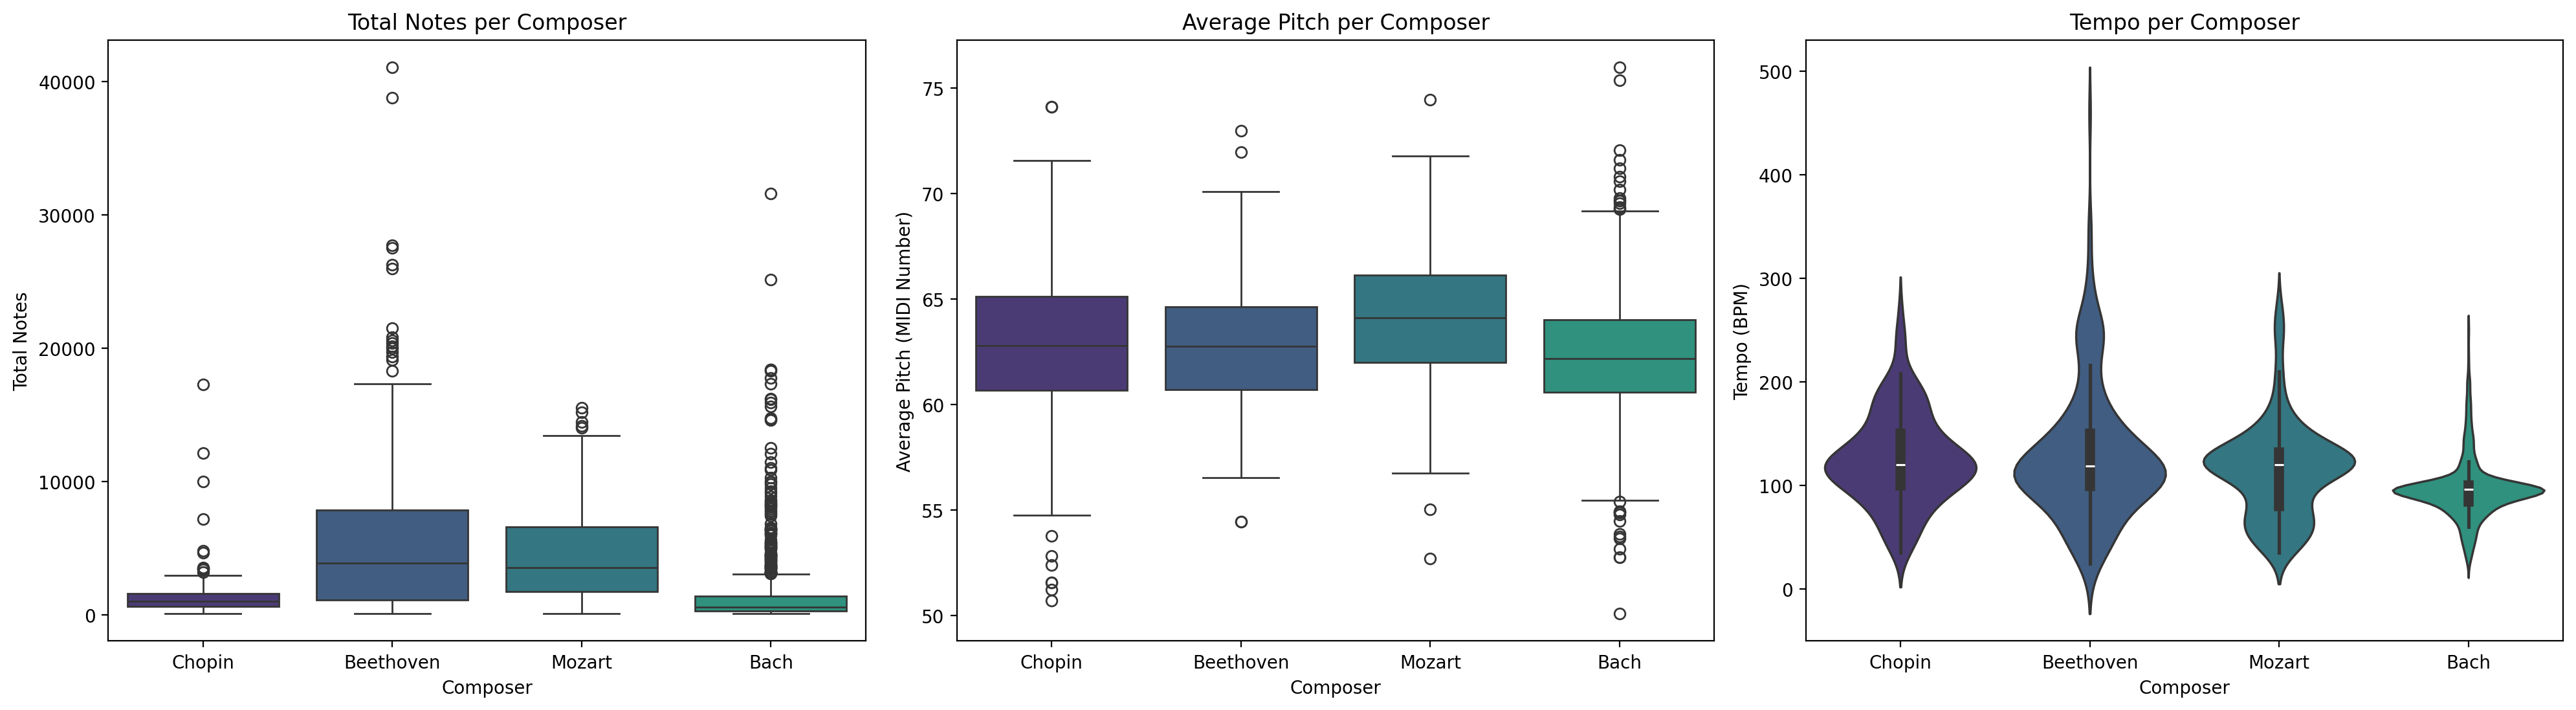

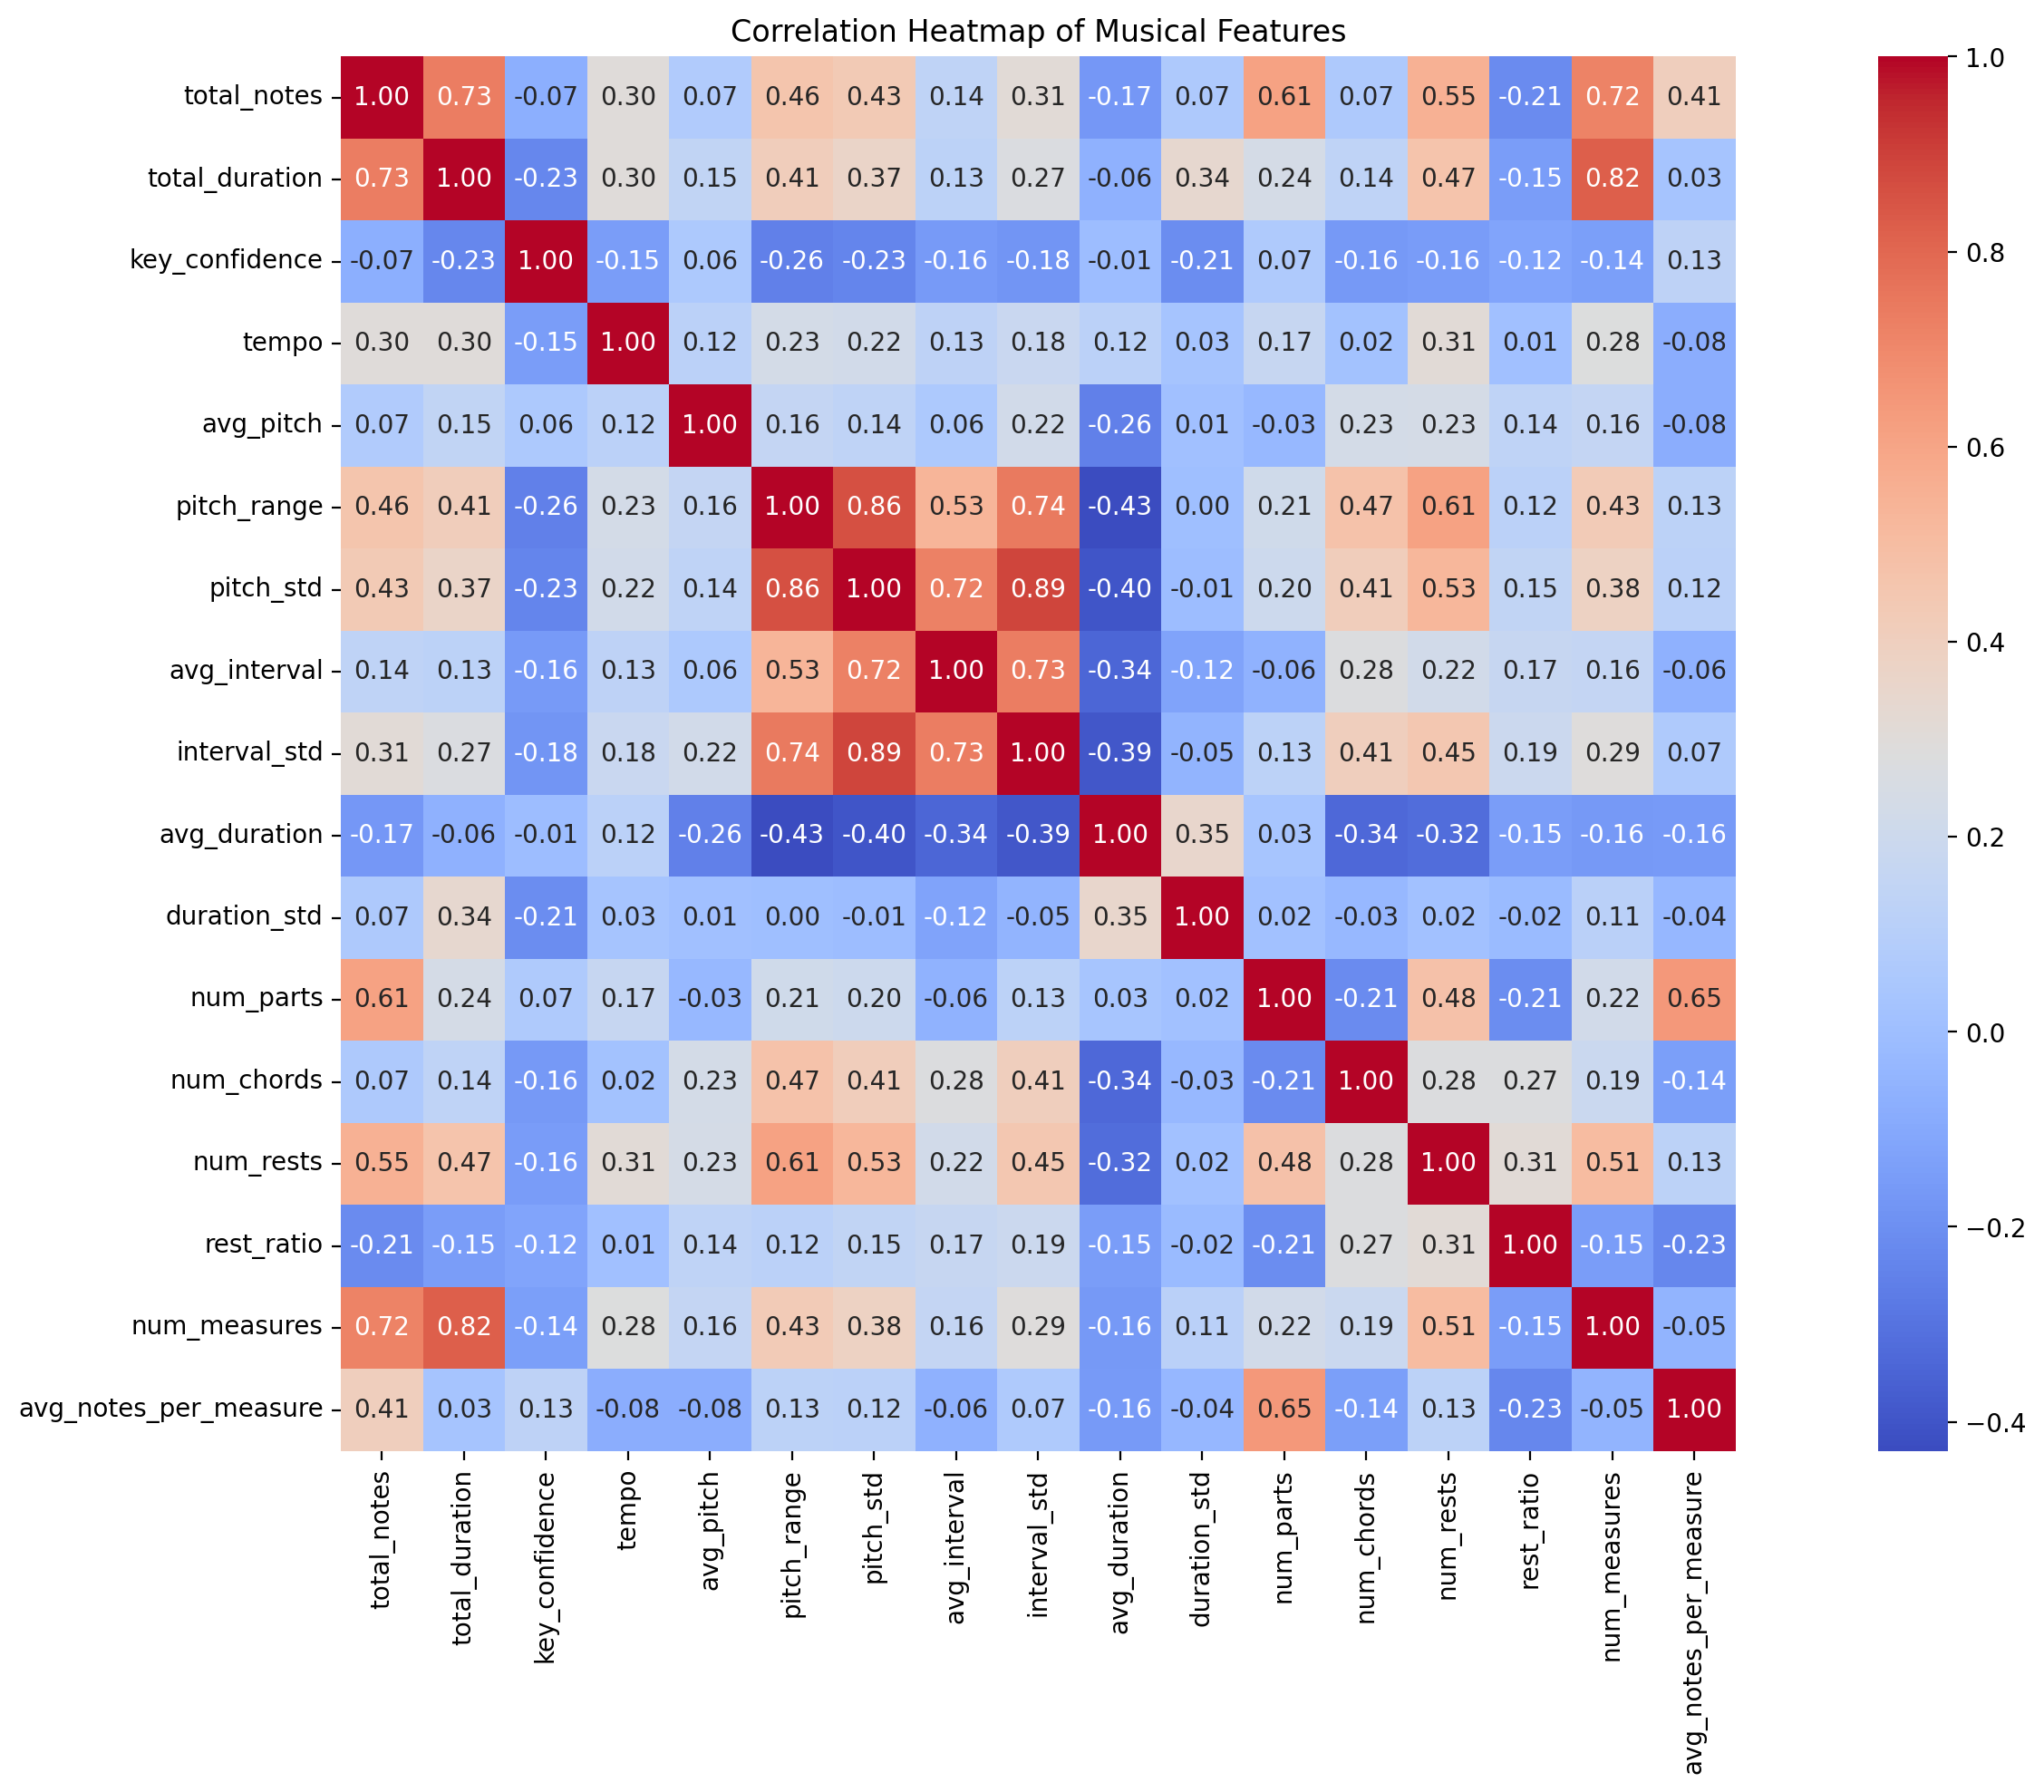

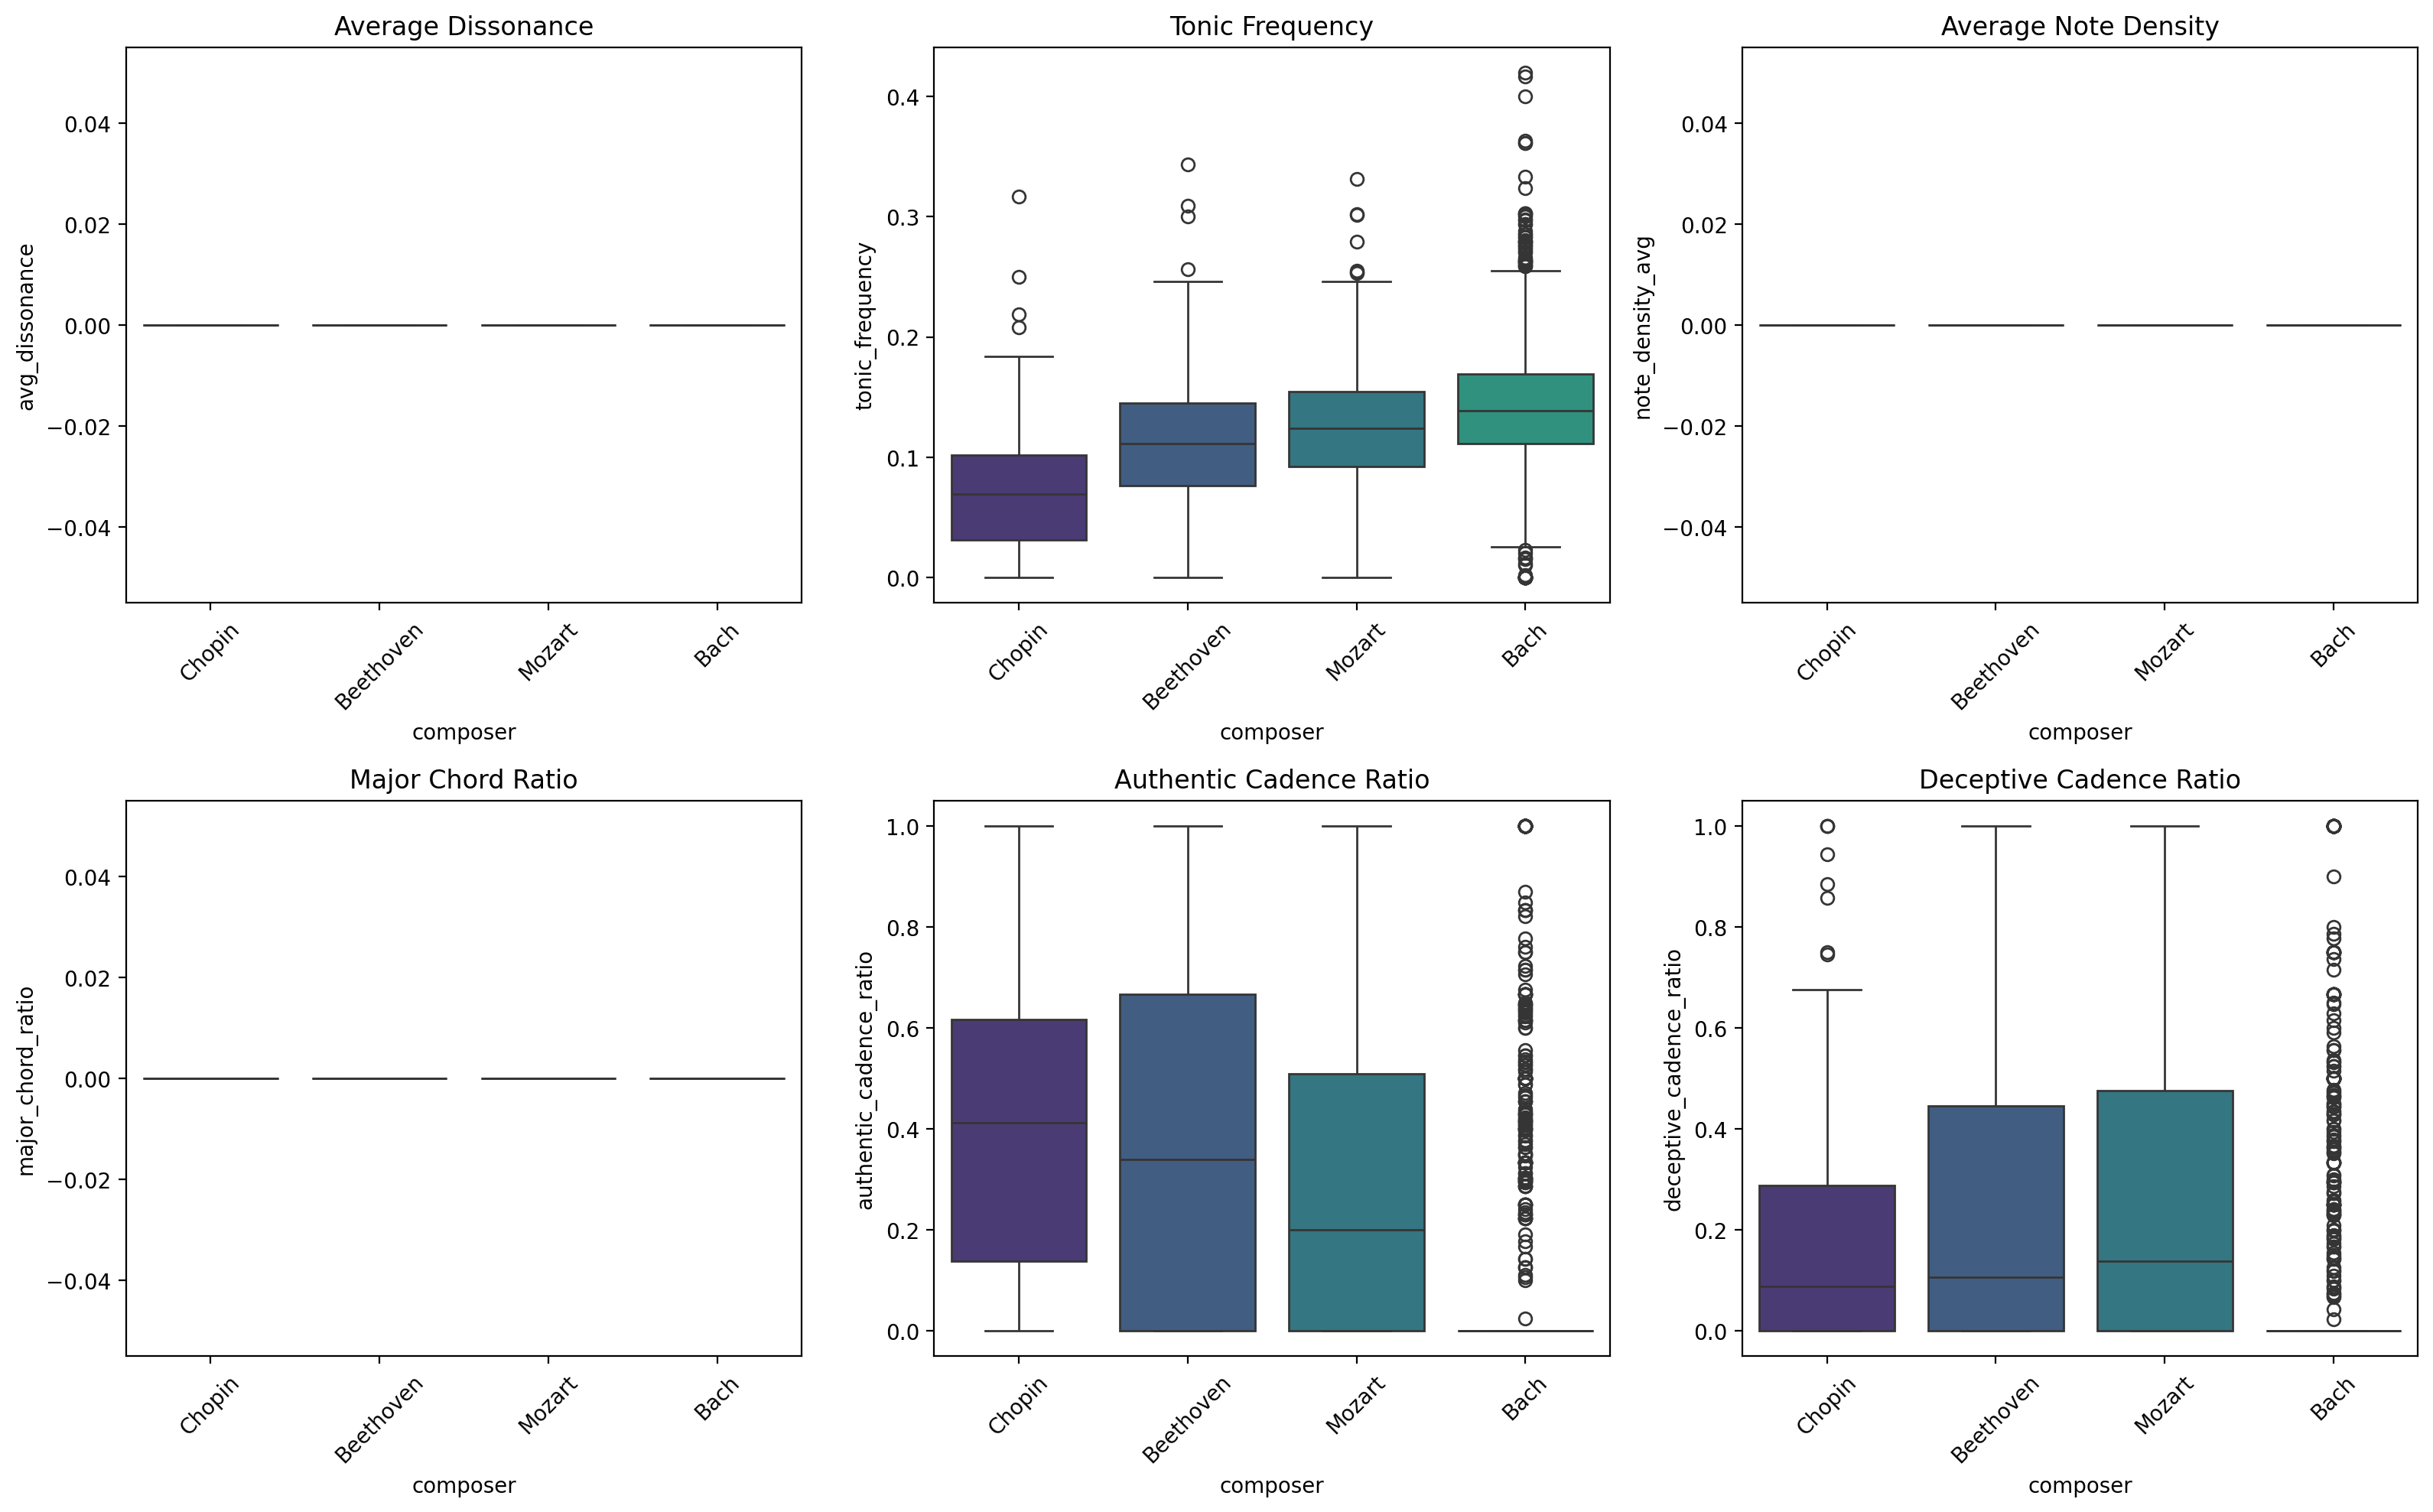

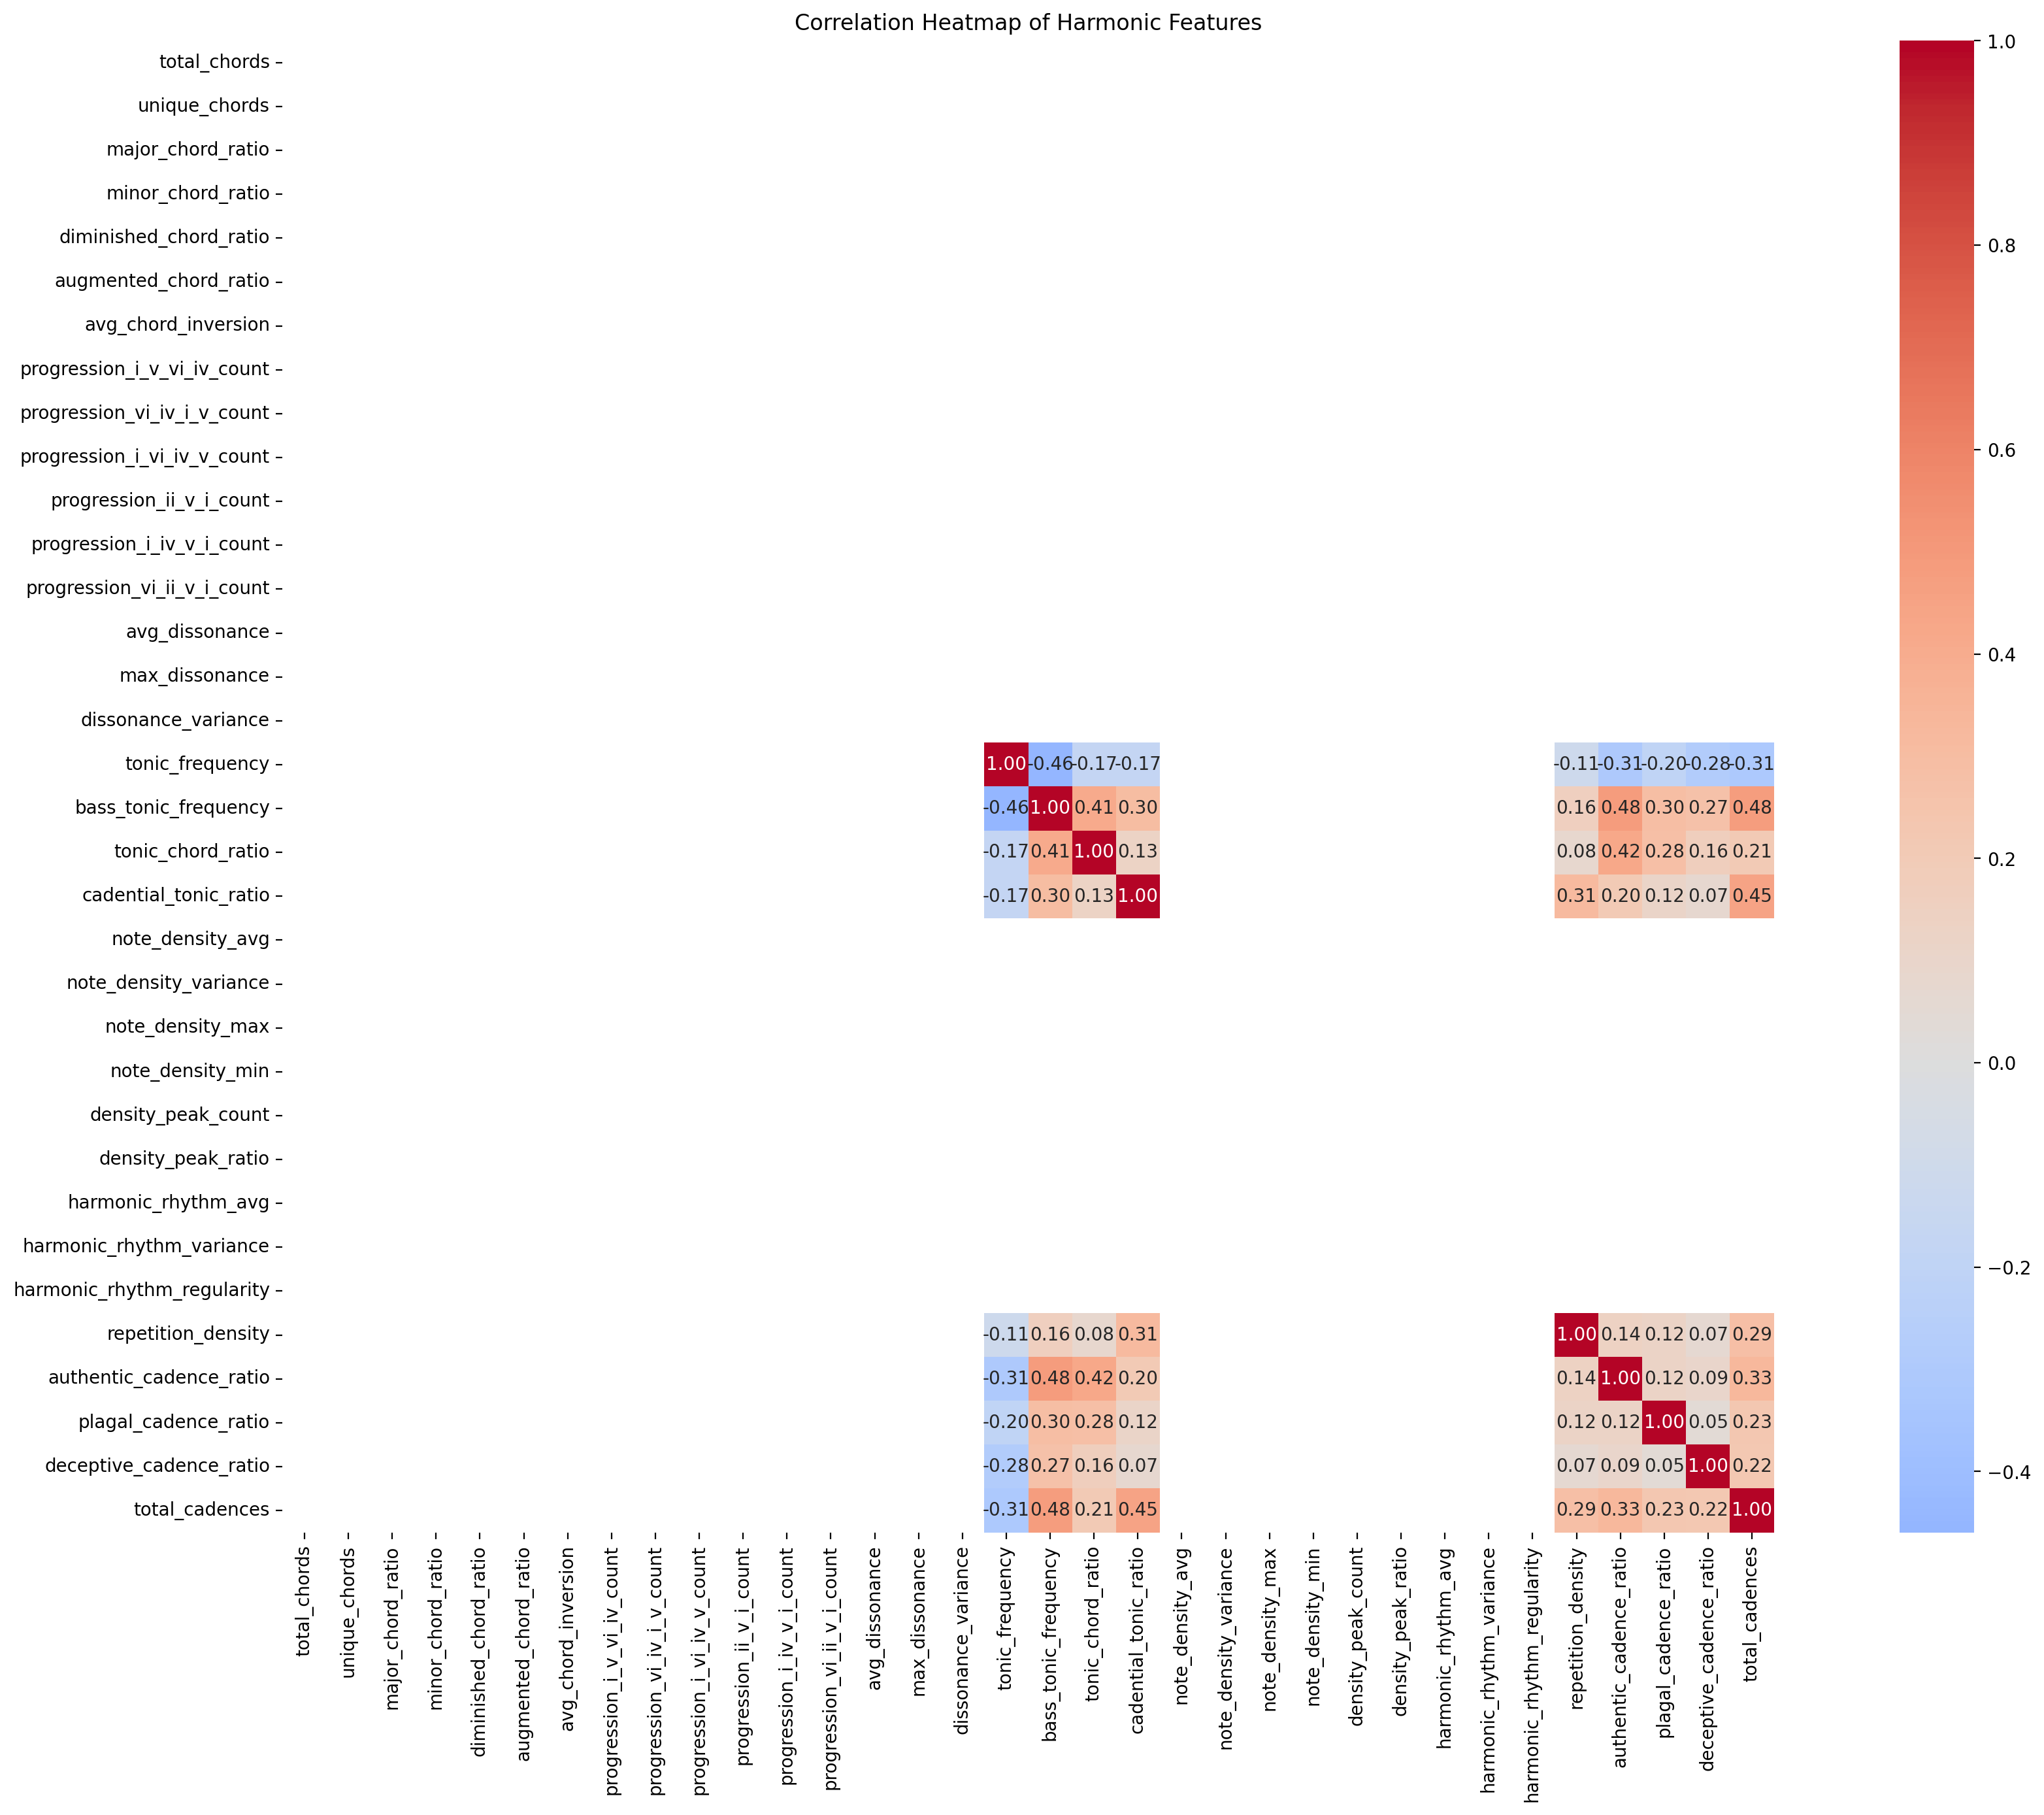

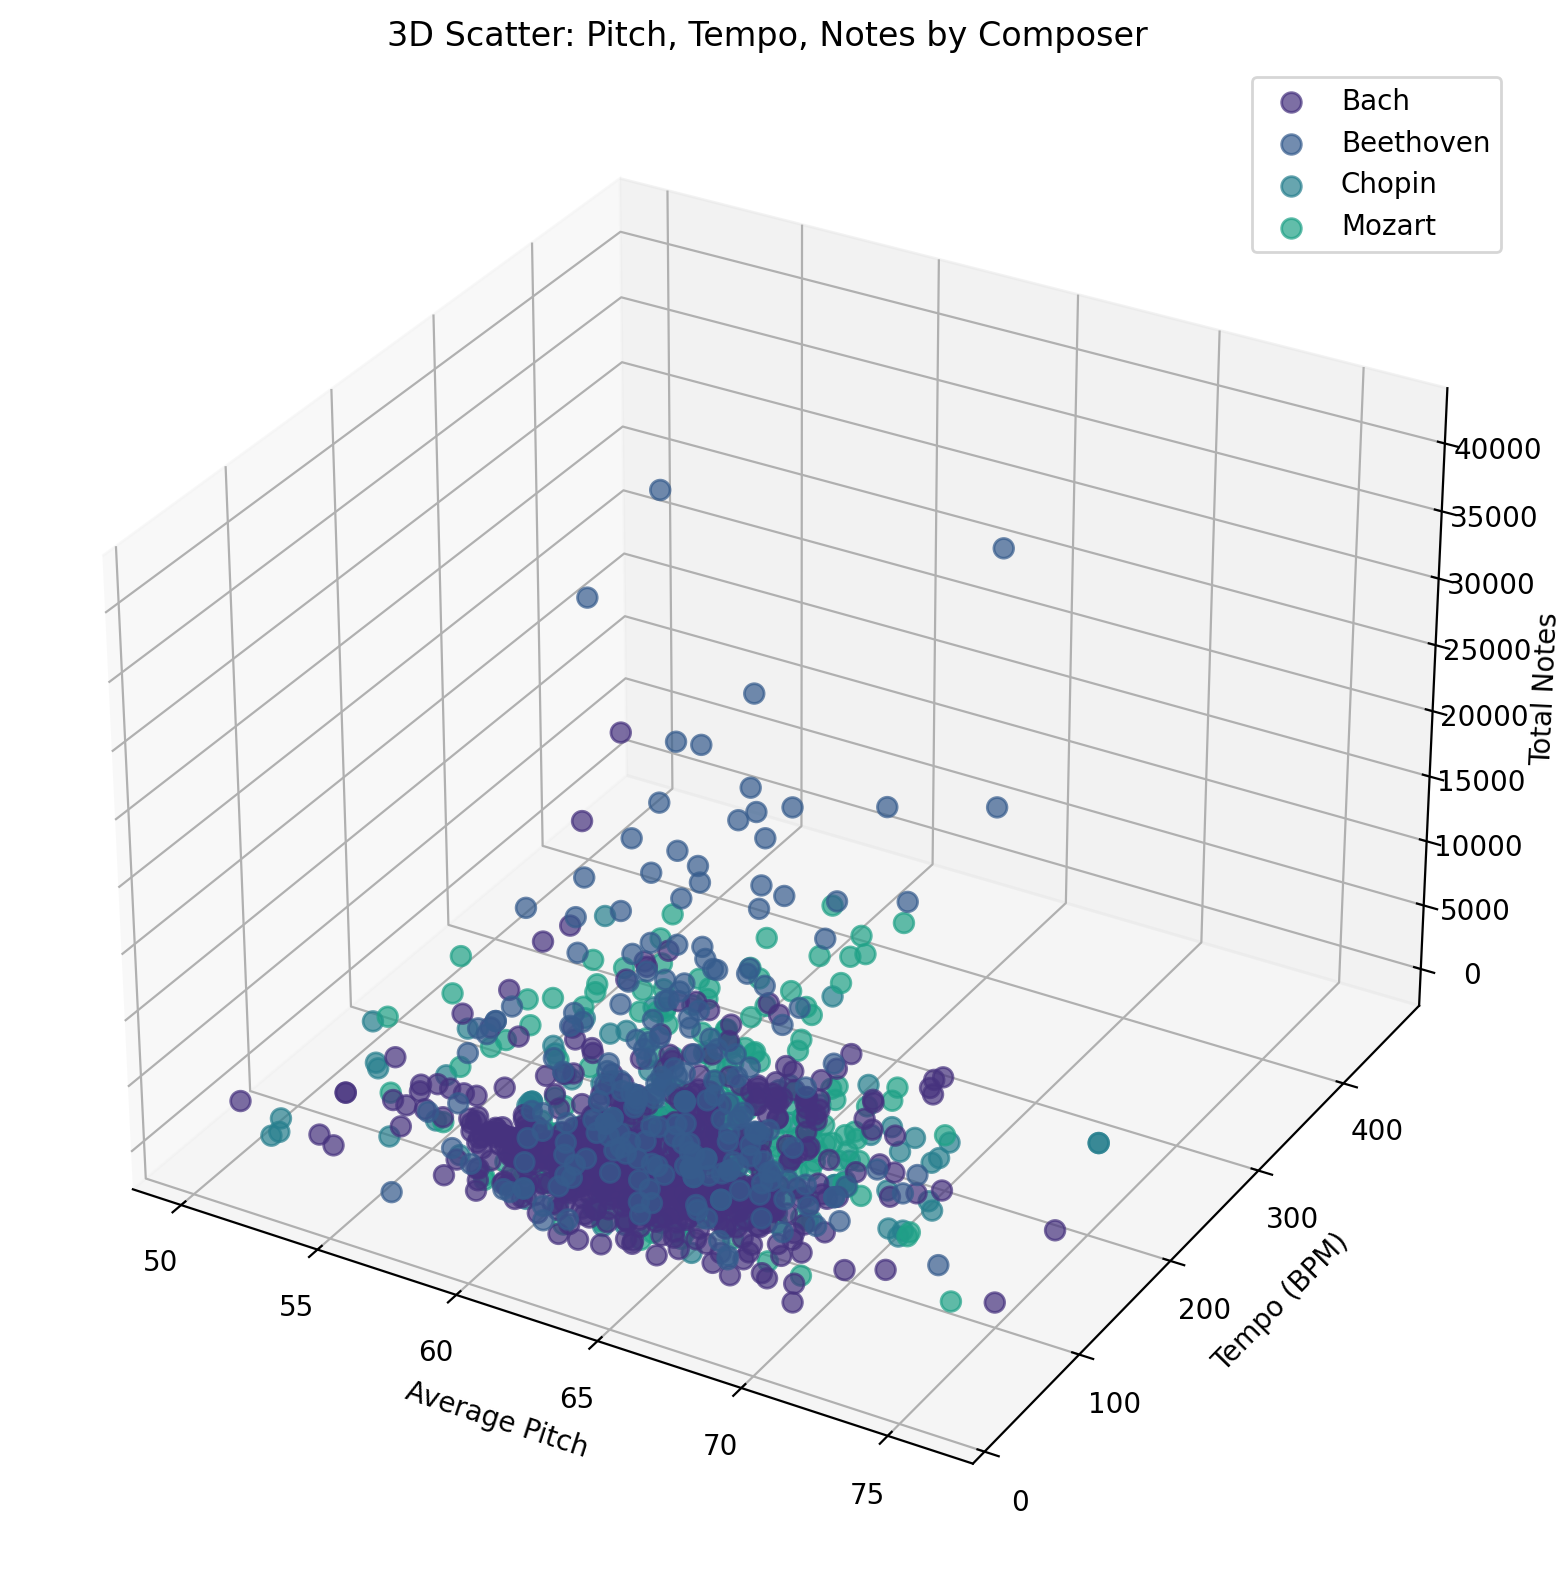

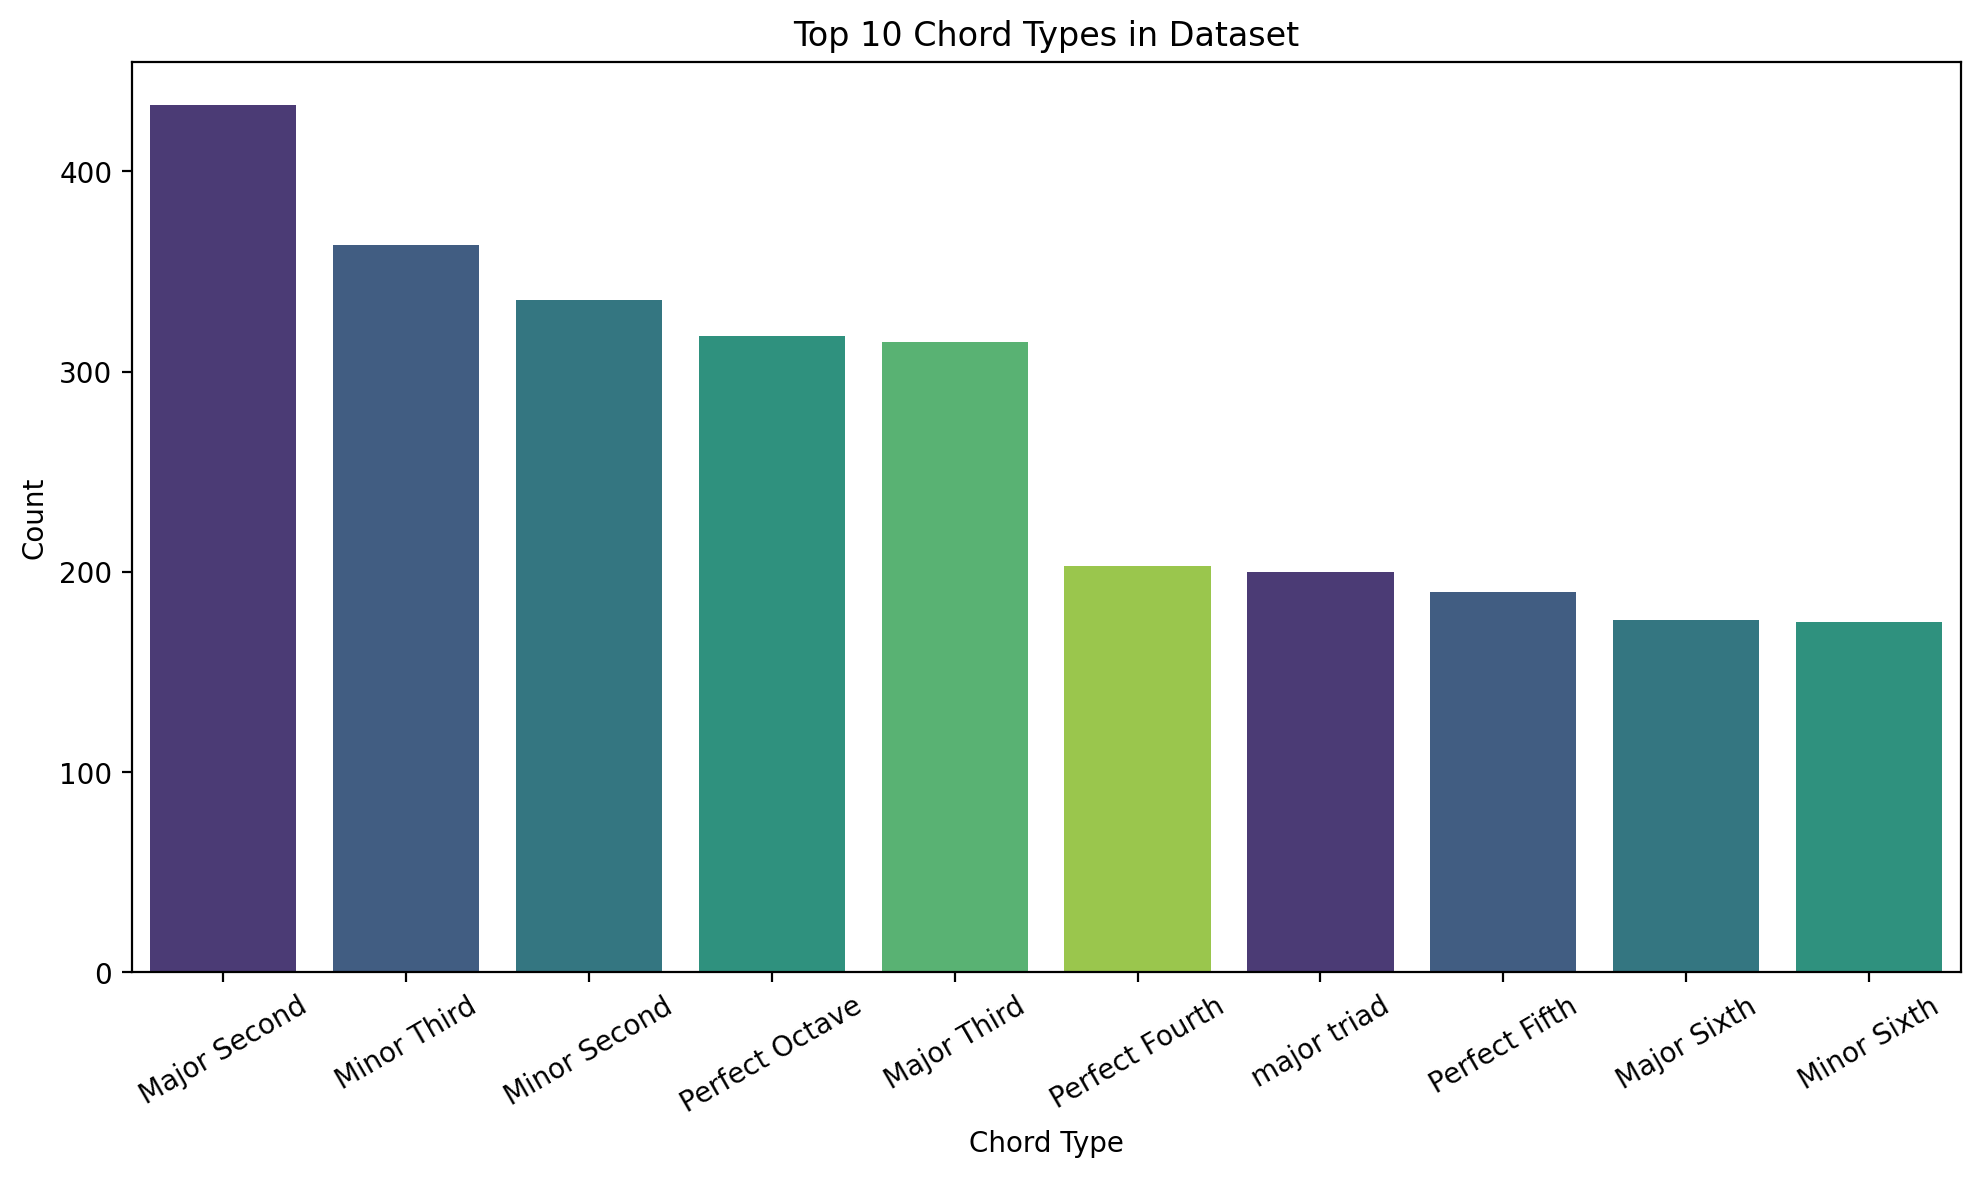

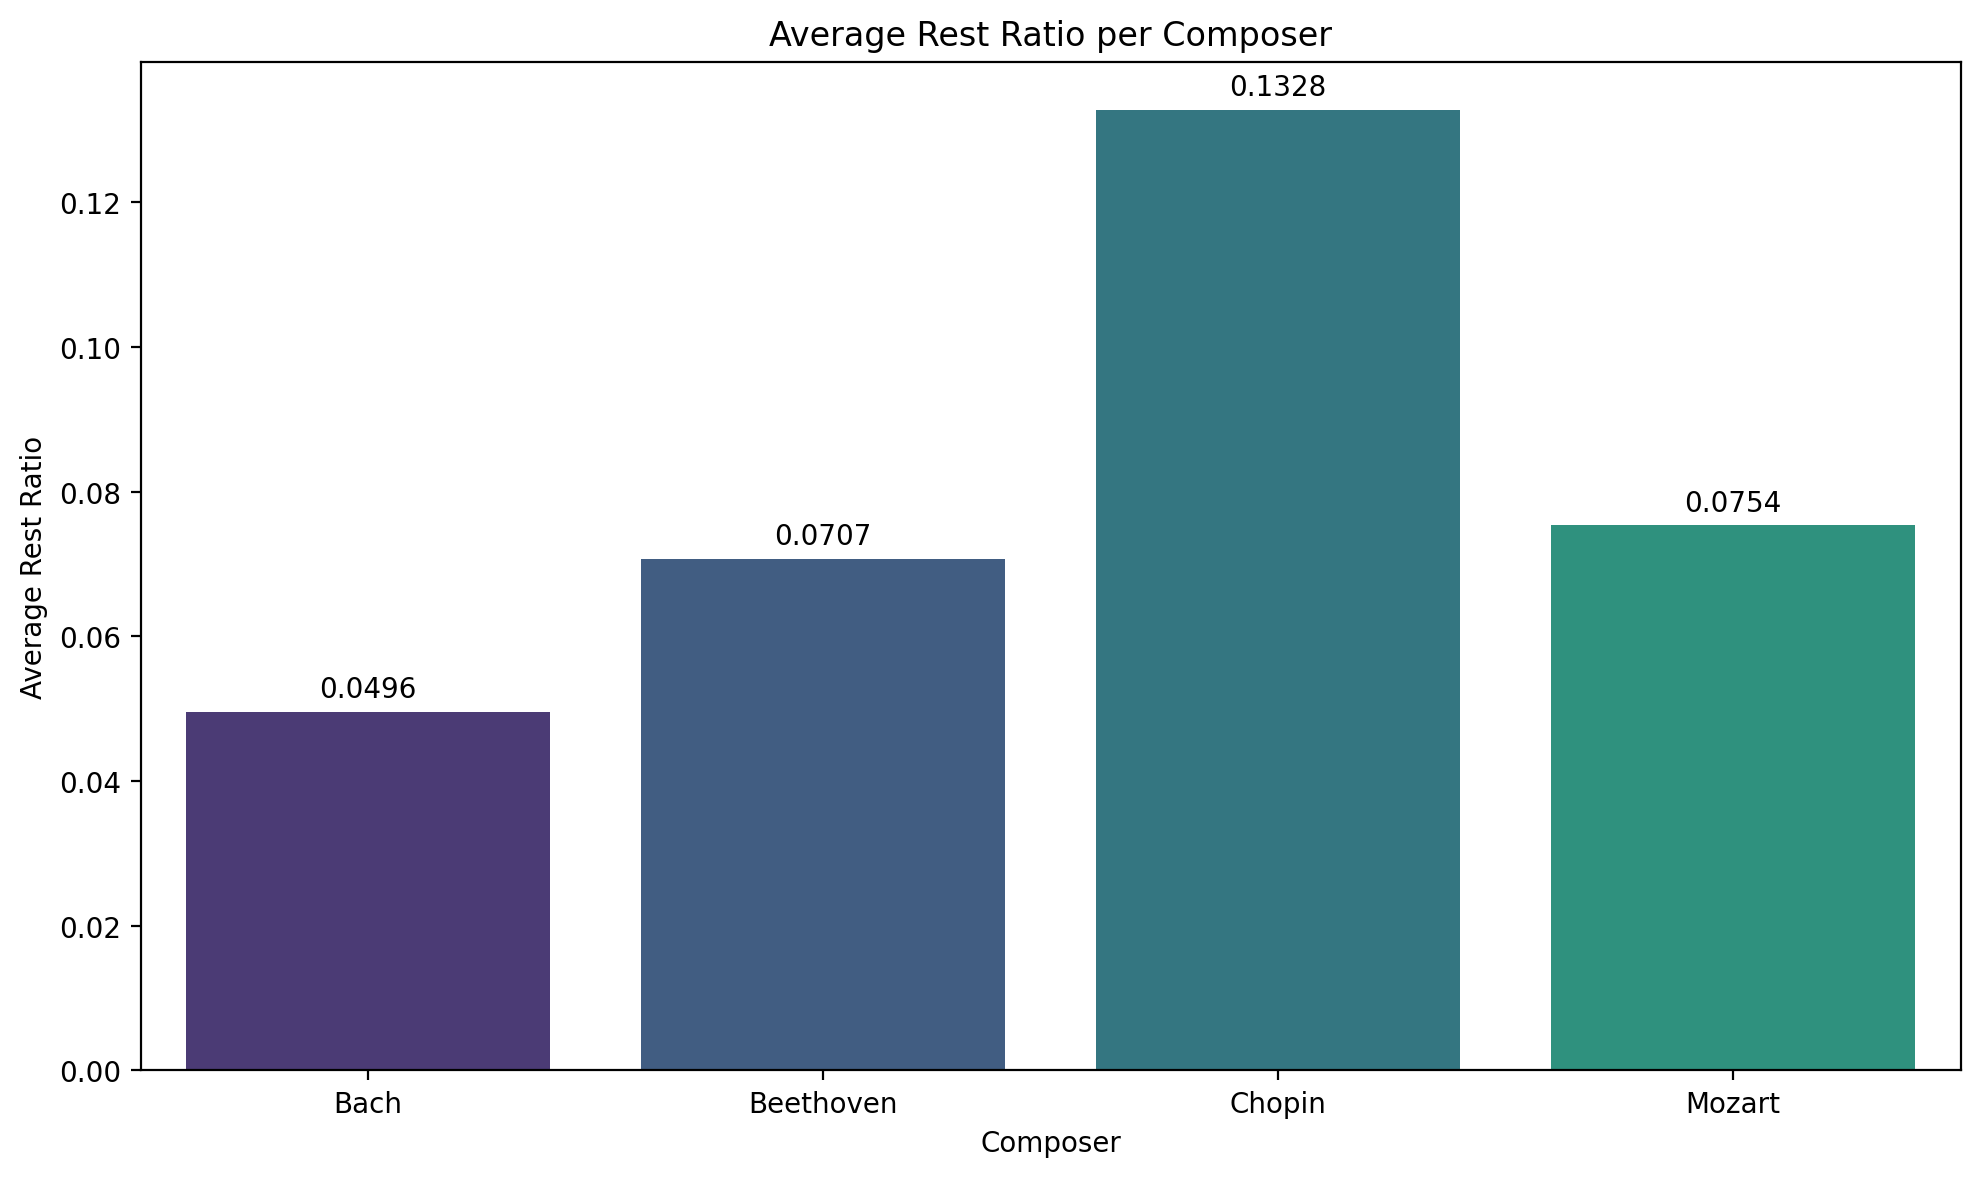

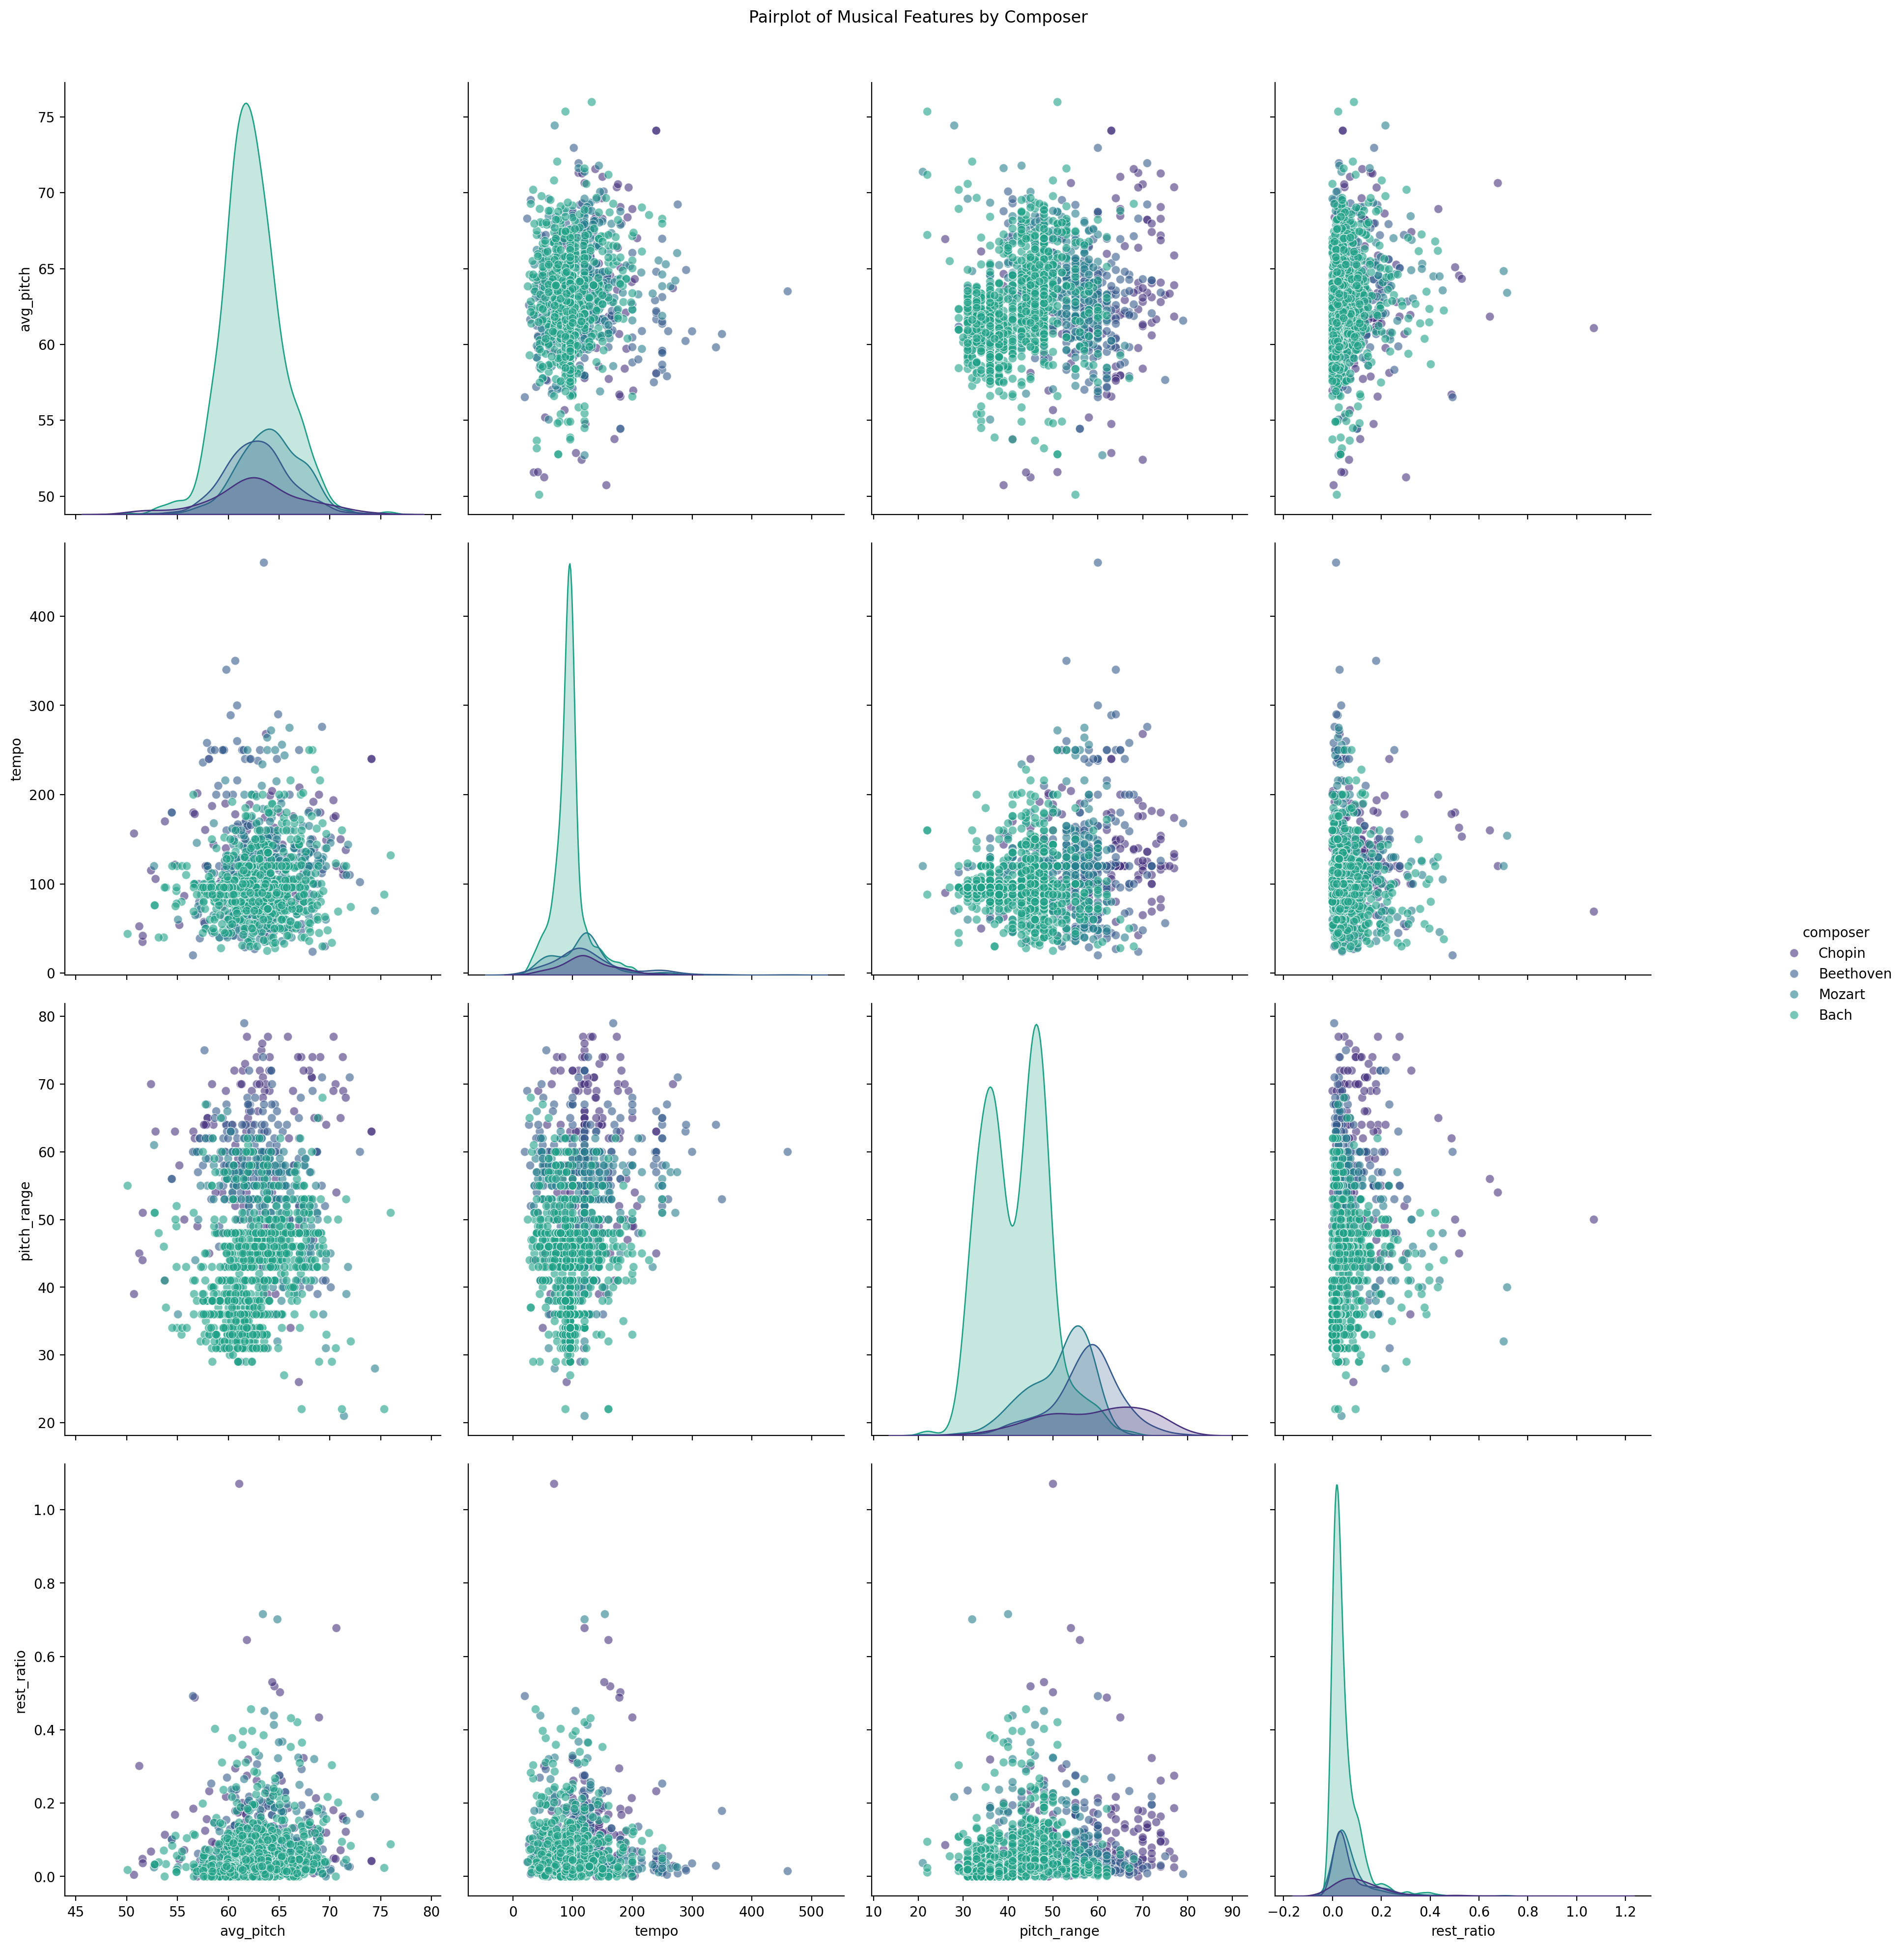

In [19]:
def plot_boxplots_and_violin(features_df, target_composers, colors):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5.6))

    # 1. Distribution of total notes per composer
    sns.boxplot(x='composer', y='total_notes', data=features_df, palette=env_config.color_pallete, ax=axs[0])
    axs[0].set_title('Total Notes per Composer')
    axs[0].set_xlabel('Composer')
    axs[0].set_ylabel('Total Notes')

    # 2. Distribution of average pitch per composer
    sns.boxplot(x='composer', y='avg_pitch', data=features_df, palette=env_config.color_pallete, ax=axs[1])
    axs[1].set_title('Average Pitch per Composer')
    axs[1].set_xlabel('Composer')
    axs[1].set_ylabel('Average Pitch (MIDI Number)')

    # 3. Distribution of tempo per composer
    sns.violinplot(x='composer', y='tempo', data=features_df, palette=env_config.color_pallete, ax=axs[2])
    axs[2].set_title('Tempo per Composer')
    axs[2].set_xlabel('Composer')
    axs[2].set_ylabel('Tempo (BPM)')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(features_df):
    plt.figure(figsize=(16, 10))
    corr = features_df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap of Musical Features")
    plt.tight_layout()
    plt.show()

def plot_3d_scatter(features_df, target_composers, colors):
    fig_3d = plt.figure(figsize=(12, 8))
    ax = fig_3d.add_subplot(111, projection='3d')
    for composer in target_composers:
        subset = features_df[features_df['composer'] == composer]
        ax.scatter(subset['avg_pitch'], subset['tempo'], subset['total_notes'],
                  label=composer, alpha=0.7, s=50, color=colors[composer])
    ax.set_xlabel('Average Pitch')
    ax.set_ylabel('Tempo (BPM)')
    ax.set_zlabel('Total Notes')
    ax.set_title('3D Scatter: Pitch, Tempo, Notes by Composer')
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_top_chords(features_df):
    all_chords = [chord for sublist in features_df['chord_types'] for chord in sublist]
    top_chords = Counter(all_chords).most_common(10)
    chord_names, chord_counts = zip(*top_chords)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(chord_names), y=list(chord_counts), palette=env_config.color_pallete,)
    plt.title('Top 10 Chord Types in Dataset')
    plt.ylabel('Count')
    plt.xlabel('Chord Type')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

def plot_rest_ratio(features_df, colors):
    plt.figure(figsize=(10, 6))
    rest_means = features_df.groupby('composer')['rest_ratio'].mean().reset_index()
    sns.barplot(x='composer', y='rest_ratio', data=rest_means, palette=env_config.color_pallete,)
    plt.title('Average Rest Ratio per Composer')
    plt.xlabel('Composer')
    plt.ylabel('Average Rest Ratio')
    
    # Add numerical values on top of each bar
    for i, value in enumerate(rest_means['rest_ratio']):
        plt.text(i, value + 0.002, f'{value:.4f}', ha='center')
        
    plt.tight_layout()
    plt.show()

def plot_pairplot(features_df, colors):
    # No direct figsize for pairplot, but we'll use the figure.set_size_inches method
    g = sns.pairplot(features_df, vars=['avg_pitch', 'tempo', 'pitch_range', 'rest_ratio'],
                hue='composer', palette=env_config.color_pallete, diag_kind='kde', plot_kws={'alpha':0.6, 's':40})
    g.fig.set_size_inches(20, 20)
    plt.suptitle('Pairplot of Musical Features by Composer', y=1.02)
    plt.show()

def plot_midi_samples(midi_df, sample_indices, target_composers):
    for i, idx in enumerate(sample_indices):
        sample_path = midi_df.loc[idx, 'file_path']
        try:
            multitrack = pypianoroll.read(sample_path)
            pr = multitrack.tracks[0].pianoroll
            pitch_sum = pr.sum(axis=0)
            nonzero_pitches = np.where(pitch_sum > 0)[0]
            if len(nonzero_pitches) > 0:
                min_pitch = max(nonzero_pitches[0] - 2, 0)
                max_pitch = min(nonzero_pitches[-1] + 2, 127)
            else:
                min_pitch, max_pitch = 21, 108
            fig = plt.figure(figsize=(20, 5))
            ax = fig.add_subplot(111)
            ax.imshow(
                multitrack.tracks[0].pianoroll.T,
                aspect='auto',
                origin='lower',
                interpolation='nearest',
                cmap='Blues'
            )
            ax.set_ylim(min_pitch, max_pitch)
            plt.title(f"{target_composers[i]}: {midi_df.loc[idx, 'filename']}")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error processing MIDI file {midi_df.loc[idx, 'filename']}: {str(e)}")
            continue

def plot_spectrograms(midi_df, target_composers):
    plt.figure(figsize=(20, 12))
    for i, composer in enumerate(target_composers, 1):
        composer_files = midi_df[midi_df['composer'] == composer]['file_path'].values
        if len(composer_files) == 0:
            print(f"No files found for composer {composer}")
            continue

        # Try multiple files if one fails
        for _ in range(min(3, len(composer_files))):  # Try up to 3 files
            sample_file = np.random.choice(composer_files)
            try:
                pm = pretty_midi.PrettyMIDI(sample_file)
                audio_data = pm.synthesize(fs=22050)

                plt.subplot(2, 2, i)
                mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=22050, n_mels=128, fmax=8000)
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

                librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', fmax=8000, cmap='coolwarm')
                plt.colorbar(format='%+2.0f dB')
                plt.title(f'Mel-spectrogram: {composer}')
                break  # If successful, break the loop
            except Exception as e:
                print(f"Error processing spectrogram for {composer} file {sample_file}: {str(e)}")
                continue
        else:
            # If all attempts failed, plot an empty subplot with an error message
            plt.subplot(2, 2, i)
            plt.text(0.5, 0.5, f"Could not process\nany {composer} files",
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f'Mel-spectrogram: {composer}')

    plt.tight_layout()
    plt.show()

def plot_harmonic_feature_graphs(features_df, target_composers, colors=None):
    if colors is None:
        colors = dict(zip(target_composers, sns.color_palette(env_config.color_pallete, len(target_composers))))

    # Key harmonic features to visualize
    key_features = [
        ('avg_dissonance', 'Average Dissonance'),
        ('tonic_frequency', 'Tonic Frequency'),
        ('note_density_avg', 'Average Note Density'),
        ('major_chord_ratio', 'Major Chord Ratio'),
        ('authentic_cadence_ratio', 'Authentic Cadence Ratio'),
        ('deceptive_cadence_ratio', 'Deceptive Cadence Ratio')
    ]

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for i, (feature, title) in enumerate(key_features):
        if feature in features_df.columns:
            sns.boxplot(x='composer', y=feature, data=features_df,
                       palette=env_config.color_pallete, ax=axes[i])
            axes[i].set_title(title)
            axes[i].tick_params(axis='x', rotation=45)
        else:
            axes[i].text(0.5, 0.5, f'{feature}\nnot available',
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(title)

    plt.tight_layout()
    plt.show()

    # Correlation heatmap of harmonic features
    harmonic_cols = [col for col in features_df.columns
                    if any(keyword in col.lower() for keyword in
                          ['dissonance', 'tonic', 'modulation', 'density',
                           'chord', 'cadence', 'progression', 'rhythm'])]

    if len(harmonic_cols) > 1:
        plt.figure(figsize=(20, 14))
        correlation_matrix = features_df[harmonic_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f',
                   cmap='coolwarm', center=0, square=True)
        plt.title('Correlation Heatmap of Harmonic Features')
        plt.tight_layout()
        plt.show()

# Create a dictionary for colors and select one sample for each composer
colors = dict(zip(TARGET_COMPOSERS, sns.color_palette(env_config.color_pallete, len(TARGET_COMPOSERS))))
sample_indices = []
for composer in TARGET_COMPOSERS:
    composer_files = midi_df[midi_df['composer'] == composer].index
    if len(composer_files) > 0:
        sample_indices.append(np.random.choice(composer_files))

# Call Plot functions
plot_boxplots_and_violin(features_df, TARGET_COMPOSERS, colors)
plot_correlation_heatmap(features_df)
plot_harmonic_feature_graphs(harmonic_df, TARGET_COMPOSERS)
plot_3d_scatter(features_df, TARGET_COMPOSERS, colors)
plot_top_chords(features_df)
plot_rest_ratio(features_df, colors)
plot_pairplot(features_df, colors)

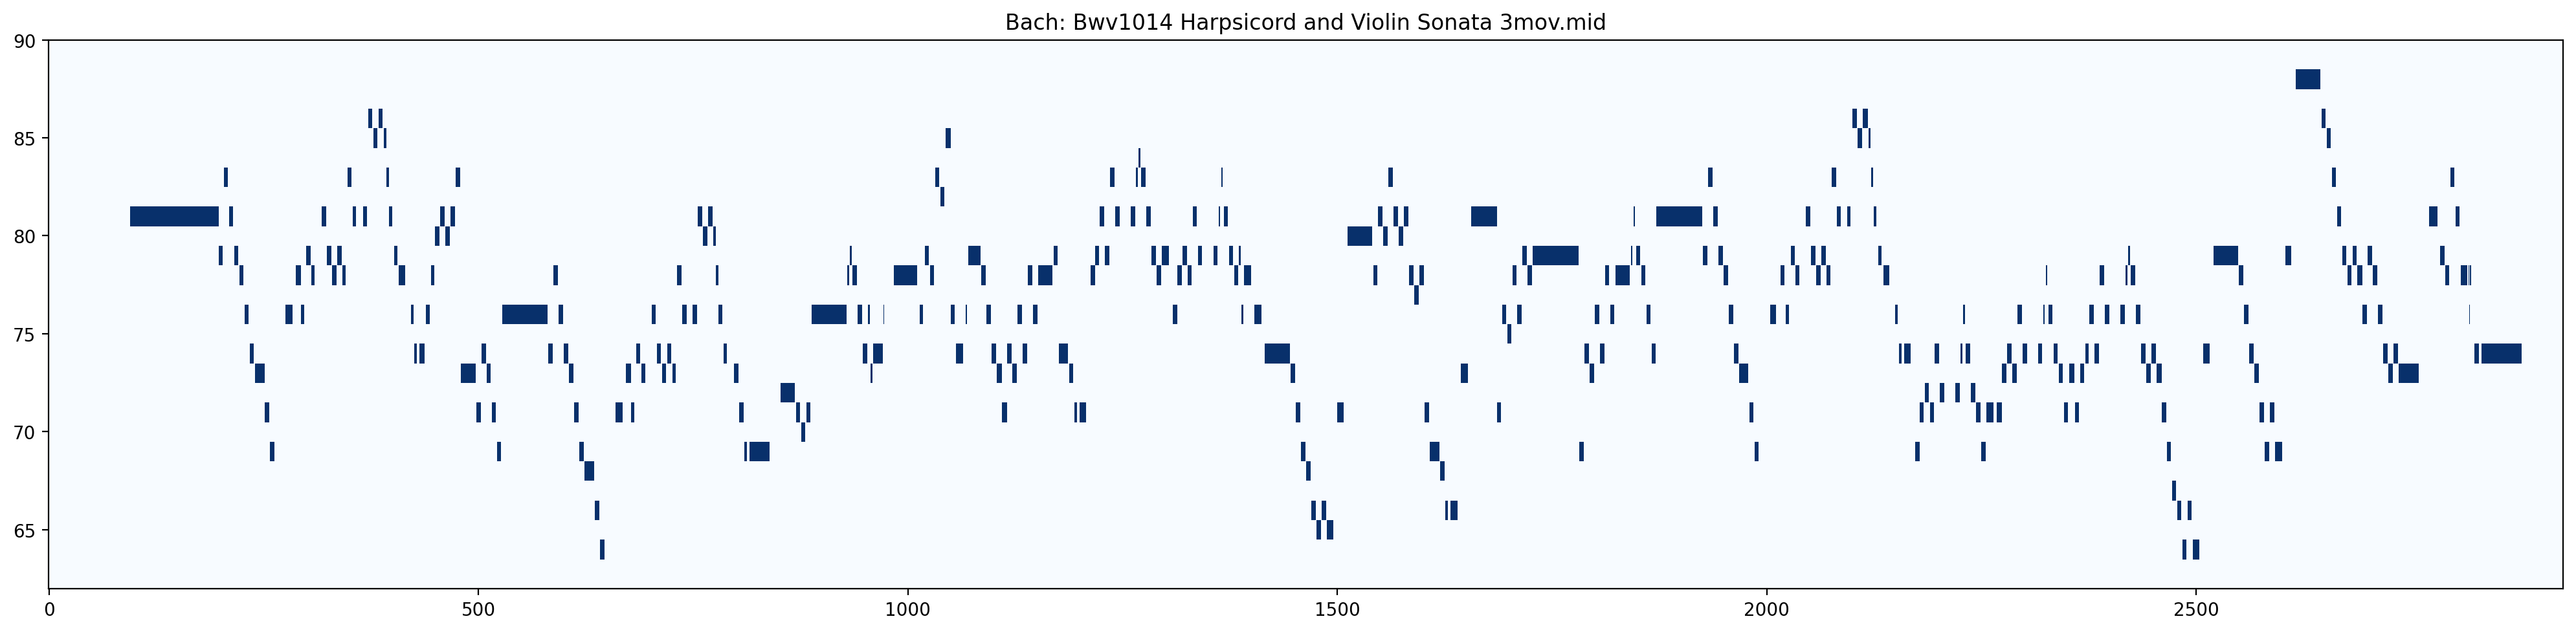

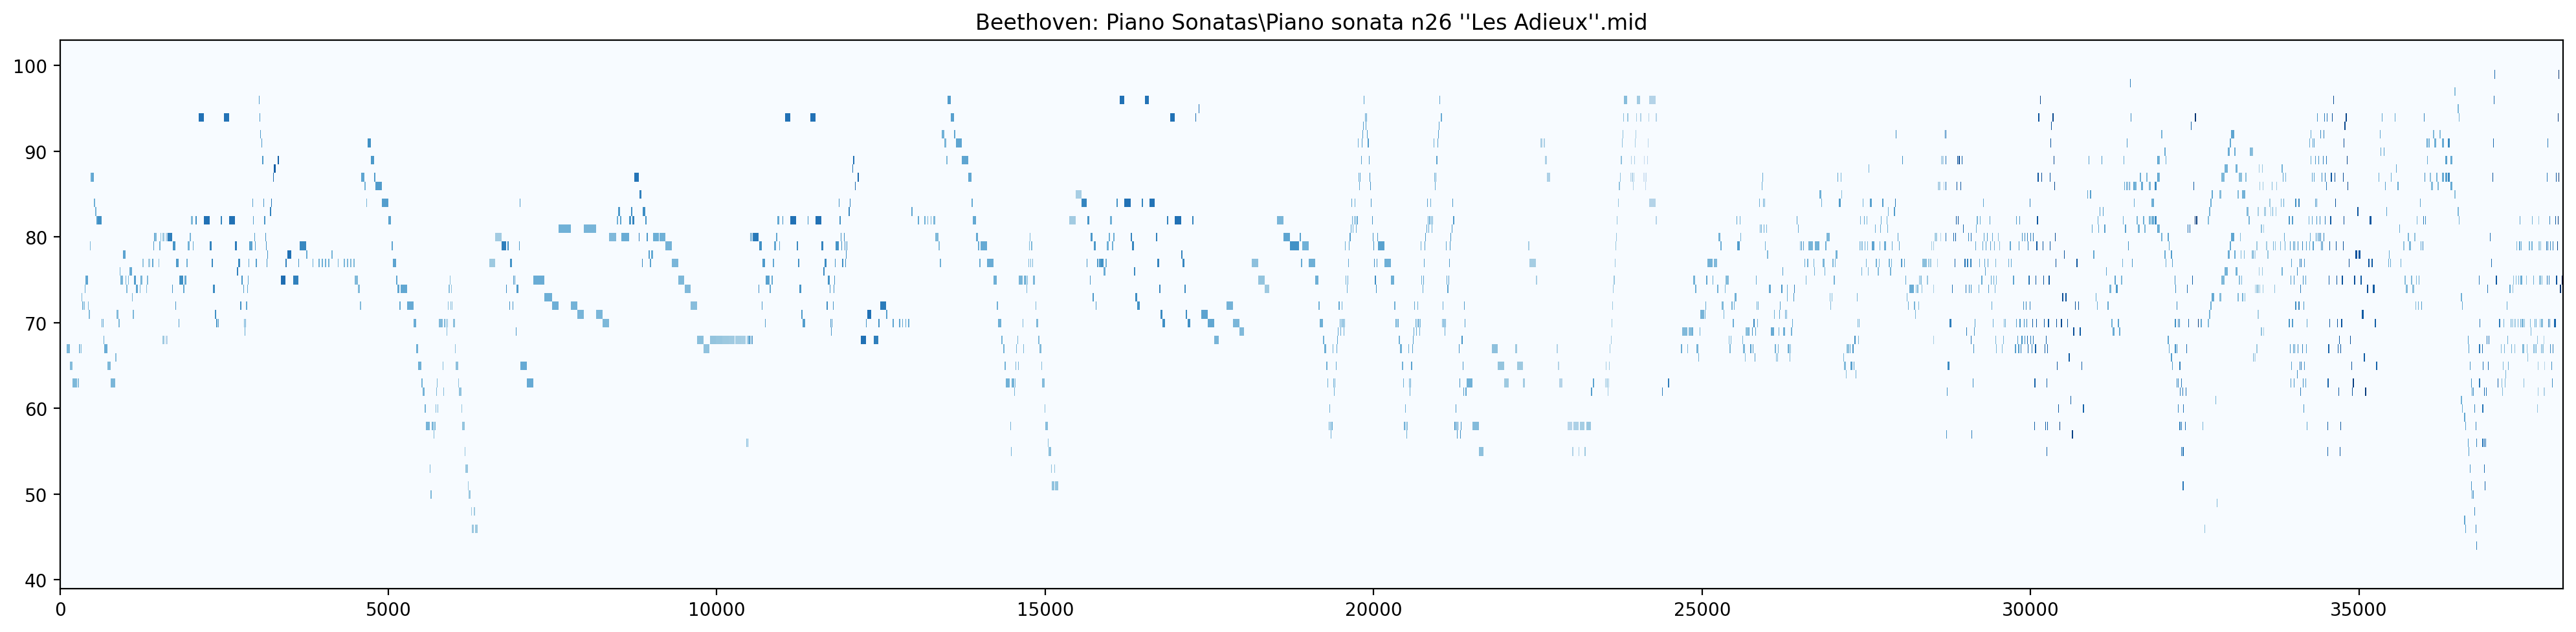

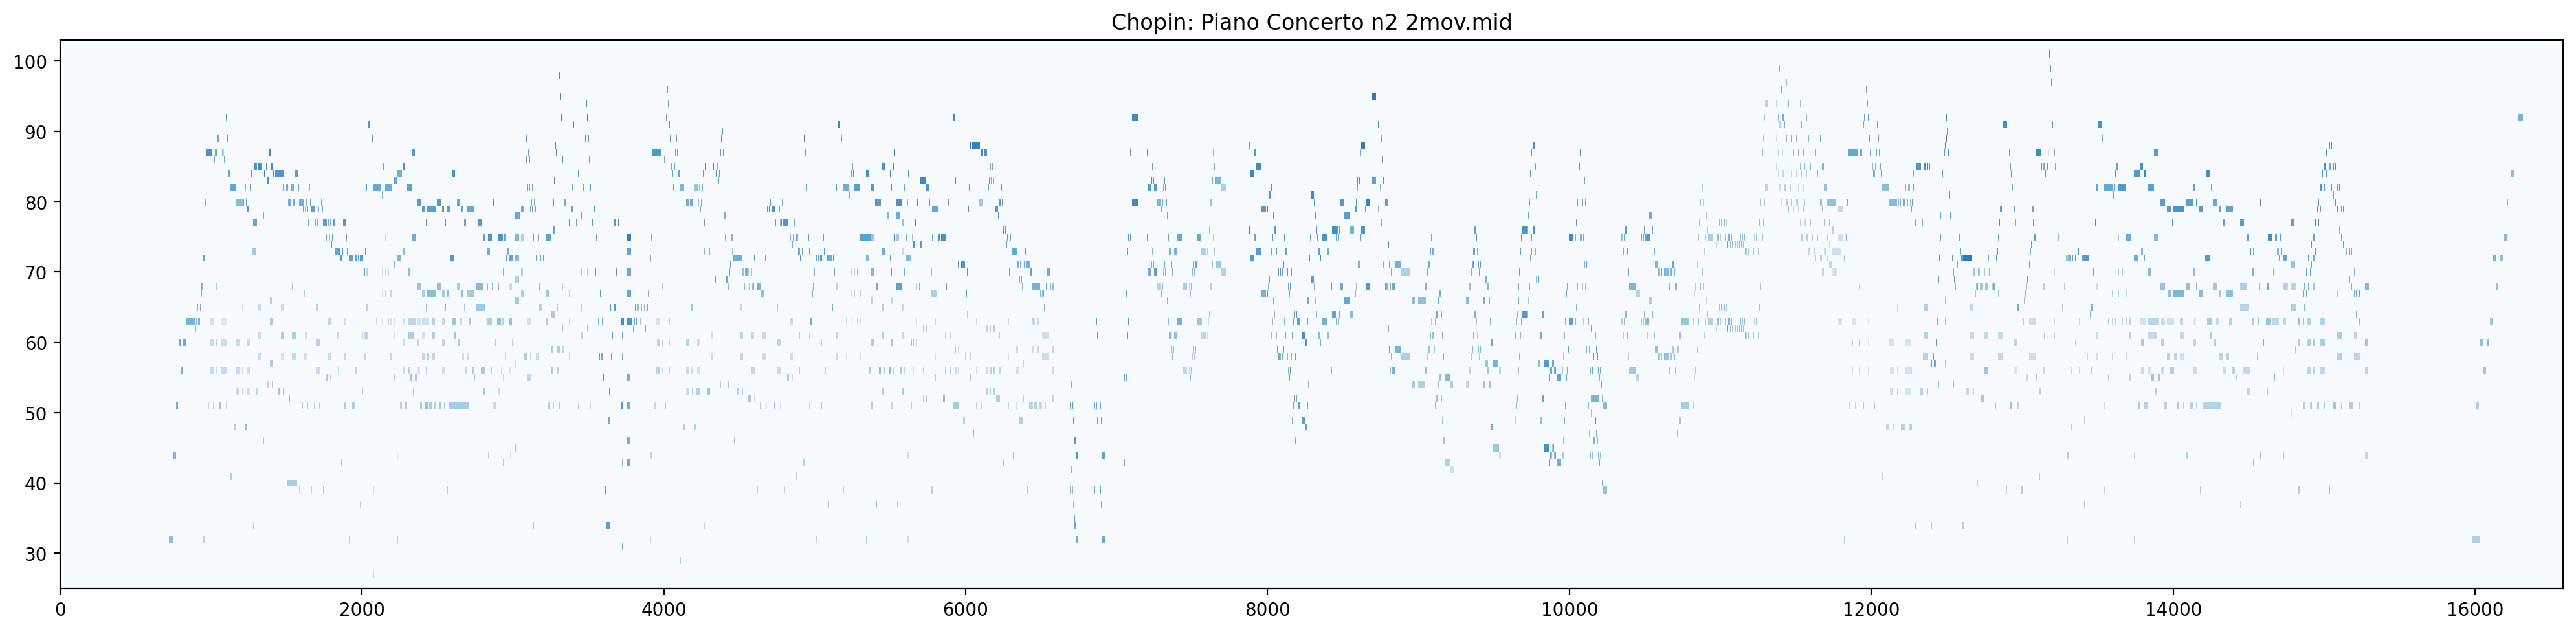

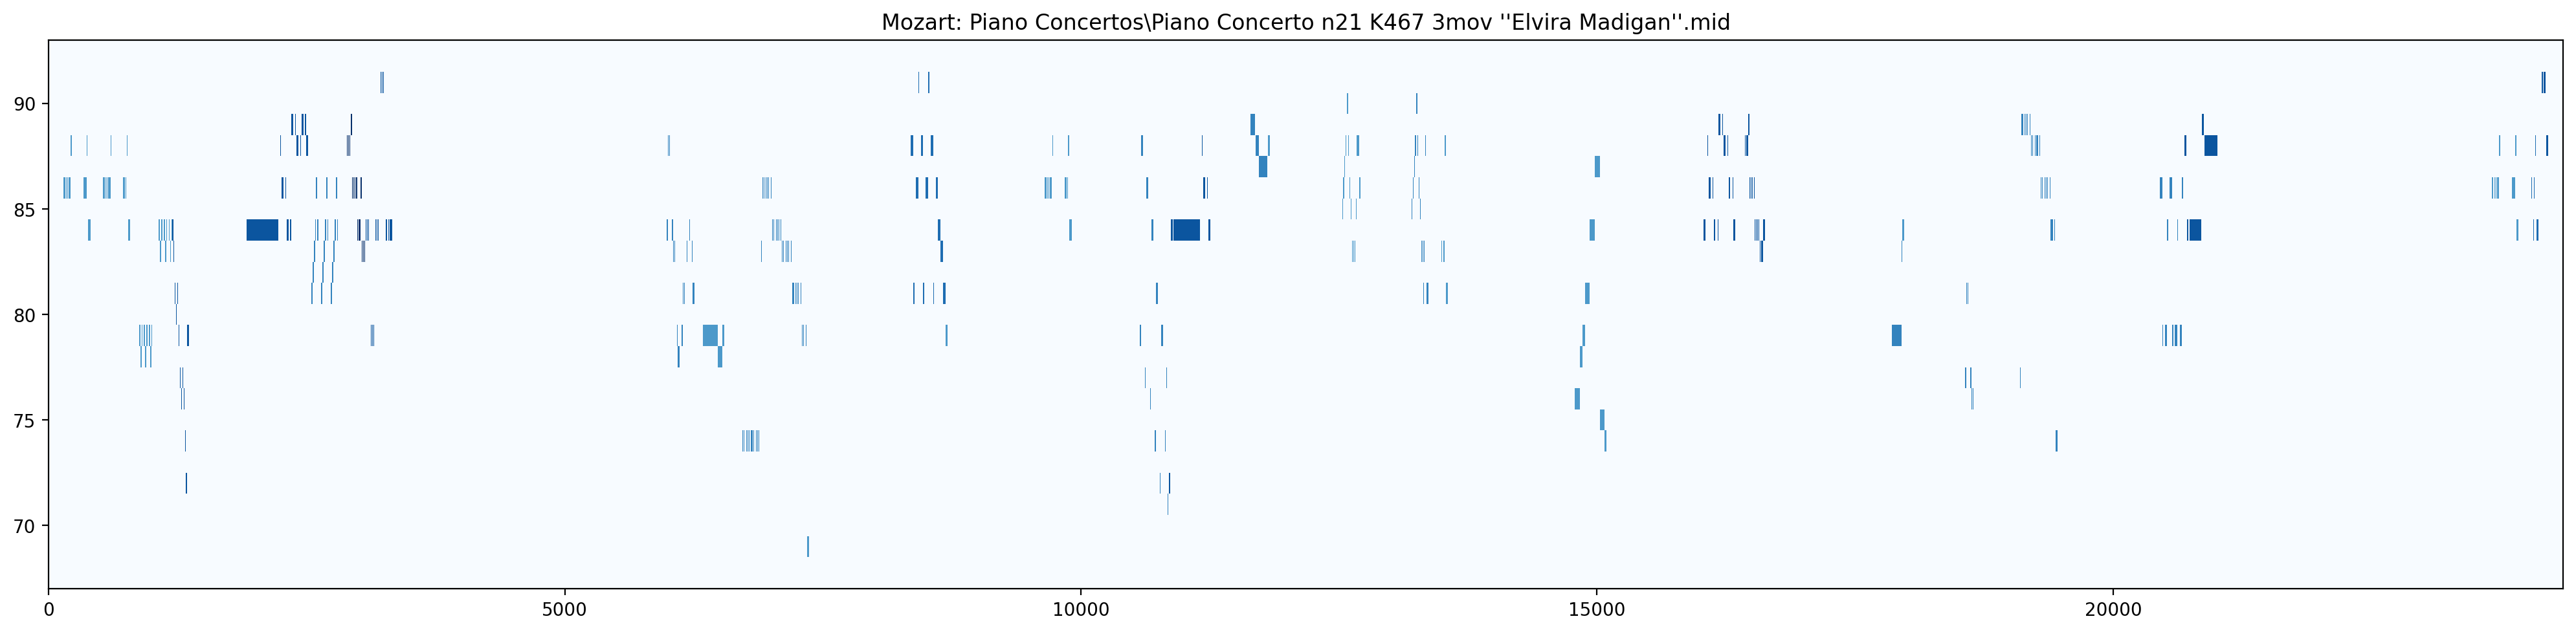

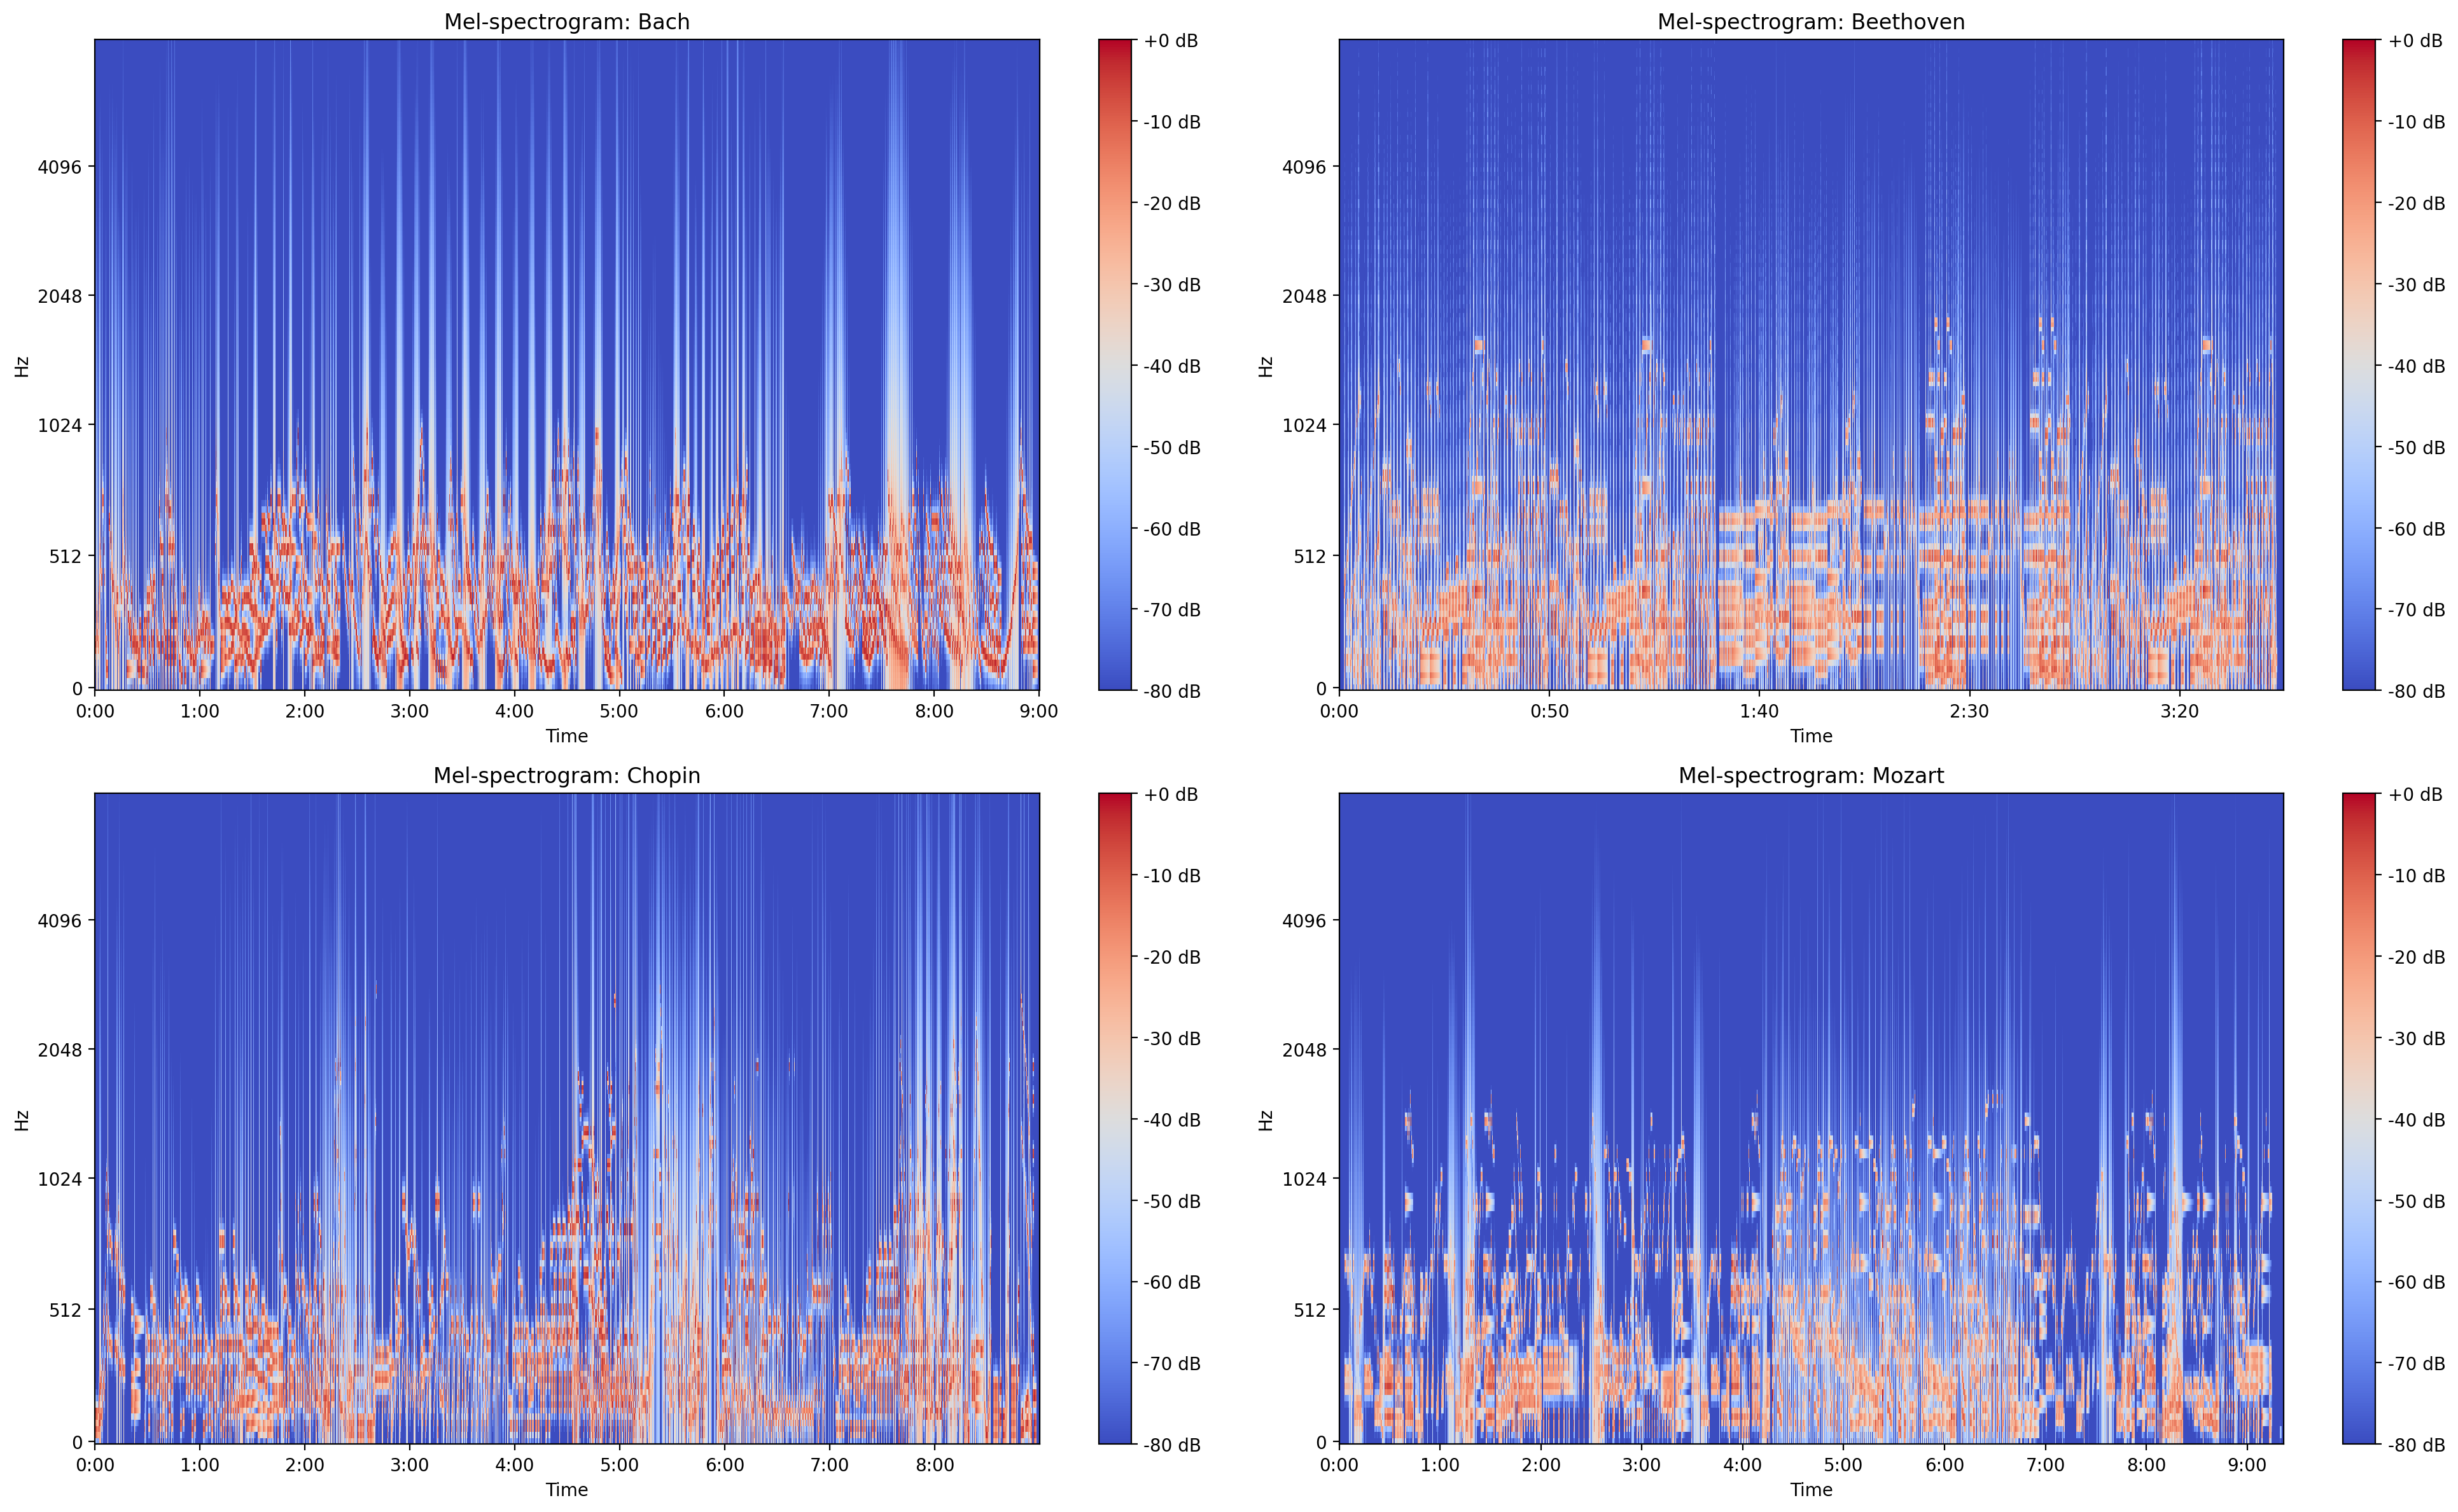

In [20]:
# Check if we have any samples before trying to plot them
if sample_indices:
    plot_midi_samples(midi_df, sample_indices, TARGET_COMPOSERS)
    plot_spectrograms(midi_df, TARGET_COMPOSERS)

<a id='modelbuilding'></a>

# 7. Model Building: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


## 1. CNN: Convolutional Neural Network


## 2. LSTM: Long Short-Term Memory


## 3. CNN + LSTM Hybrid Model Approach


In [21]:
# Core ML and Data Processing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import time
from typing import Dict, List, Tuple, Optional, Union
from dataclasses import dataclass
from abc import ABC, abstractmethod

# Scikit-learn Components
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_curve, auc, roc_auc_score
)

# TensorFlow/Keras Components
import tensorflow as tf
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, Input,
    Reshape, GlobalAveragePooling1D, BatchNormalization, Bidirectional,
    Concatenate, GlobalMaxPooling1D, Multiply
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# Progress and Utility
from tqdm import tqdm
from itertools import product

In [22]:
@dataclass
class ModelConfig:
    """Configuration class for model hyperparameters"""
    lstm_units: int = 192
    cnn_filters: int = 96
    dense_units: int = 384
    dropout_rate: float = 0.4
    learning_rate: float = 0.0005
    num_layers: int = 3
    embedding_dim: int = 128
    use_batch_norm: bool = True
    use_residual: bool = True
    attention_heads: int = 8
    l2_regularization: float = 0.001

@dataclass
class TrainingConfig:
    """Configuration class for training parameters"""
    epochs: int = 120
    batch_size: int = 32
    patience: int = 20
    val_split: float = 0.15
    test_split: float = 0.15
    random_state: int = 42


class BaseNeuralNetwork(ABC):
    """Abstract base class for neural network models"""

    def __init__(self, config: ModelConfig):
        self.config = config

    @abstractmethod
    def build_model(self) -> Sequential:
        """Build the neural network model"""
        pass

    @abstractmethod
    def create_branch(self, input_layer):
        """Create a branch for use in hybrid models"""
        pass

In [23]:
class LSTMNetworkBuilder(BaseNeuralNetwork):
    """LSTM model builder with attention mechanism"""

    def __init__(self, sequence_length: int, vocab_size: Optional[int] = None,
                 config: ModelConfig = ModelConfig()):
        super().__init__(config)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size

    def build_model(self) -> Sequential:
        """Build standalone LSTM model"""
        model = Sequential(name='LSTM_Model')

        if self.vocab_size:
            model.add(Embedding(
                input_dim=self.vocab_size,
                output_dim=self.config.embedding_dim,
                input_length=self.sequence_length,
                name='embedding'
            ))

        # Build LSTM layers
        for i in range(self.config.num_layers):
            return_sequences = i < self.config.num_layers - 1
            model.add(Bidirectional(
                LSTM(
                    units=self.config.lstm_units,
                    return_sequences=return_sequences,
                    dropout=self.config.dropout_rate,
                    recurrent_dropout=self.config.dropout_rate * 0.5
                ),
                name=f'bidirectional_lstm_{i+1}'
            ))

            if return_sequences:
                model.add(BatchNormalization(name=f'lstm_batch_norm_{i+1}'))

        return model

    def create_branch(self, sequence_input):
        """Create LSTM branch with attention for hybrid model"""
        # First Bidirectional LSTM layer
        lstm_out1 = Bidirectional(
            LSTM(
                units=self.config.lstm_units,
                return_sequences=True,
                dropout=self.config.dropout_rate,
                recurrent_dropout=self.config.dropout_rate * 0.5,
                kernel_regularizer=tf.keras.regularizers.l2(0.001)
            ),
            name='lstm_branch_1'
        )(sequence_input)
        
        # Multi-head self-attention
        attention_output = tf.keras.layers.MultiHeadAttention(
            num_heads=8,  # Increase from 4
            key_dim=self.config.lstm_units // 4,
            dropout=self.config.dropout_rate * 0.5,
            name='multi_head_attention'
        )(lstm_out1, lstm_out1)
        
        # Add & Norm with stronger regularization
        attention_output = tf.keras.layers.Add(name='attention_residual')([lstm_out1, attention_output])
        attention_output = tf.keras.layers.LayerNormalization(name='attention_norm')(attention_output)
        attention_output = Dropout(rate=self.config.dropout_rate * 0.3, name='attention_dropout')(attention_output)
        
        # Second LSTM layer
        lstm_out2 = Bidirectional(
            LSTM(
                units=self.config.lstm_units // 2,
                return_sequences=False,
                dropout=self.config.dropout_rate,
                kernel_regularizer=tf.keras.regularizers.l2(0.001)
            ),
            name='lstm_branch_2'
        )(attention_output)
        
        return lstm_out2

In [24]:
class CNNNetworkBuilder(BaseNeuralNetwork):
    """CNN model builder for sequence pattern detection"""

    def __init__(self, input_shape: Tuple[int, ...], config: ModelConfig = ModelConfig()):
        super().__init__(config)
        self.input_shape = input_shape

    def build_model(self) -> Sequential:
        """Build standalone CNN model"""
        model = Sequential(name='CNN_Model')
        model.add(Input(shape=self.input_shape, name='cnn_input'))

        # Progressive CNN layers
        for i in range(self.config.num_layers):
            filters = self.config.cnn_filters * (2 ** i)

            model.add(Conv1D(
                filters=filters,
                kernel_size=3,
                activation='relu',
                padding='same',
                name=f'conv1d_{i+1}'
            ))

            model.add(BatchNormalization(name=f'cnn_batch_norm_{i+1}'))

            if i < self.config.num_layers - 1:
                model.add(MaxPooling1D(pool_size=2, name=f'max_pool_{i+1}'))

            model.add(Dropout(rate=self.config.dropout_rate, name=f'cnn_dropout_{i+1}'))

        model.add(GlobalAveragePooling1D(name='global_avg_pool'))

        return model

    def create_branch(self, sequence_input):
        """Create CNN branch with residual connections"""
        # Reshape for CNN processing
        reshaped = Reshape(
            target_shape=(self.input_shape[0], 1),
            name='cnn_reshape'
        )(sequence_input)

        # First CNN block with residual connection
        cnn_out = Conv1D(
            filters=self.config.cnn_filters,
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            name='cnn_branch_conv_1'
        )(reshaped)
        
        cnn_out = BatchNormalization(name='cnn_branch_bn_1')(cnn_out)
        cnn_out = MaxPooling1D(pool_size=2, name='cnn_branch_pool_1')(cnn_out)
        cnn_out = Dropout(rate=self.config.dropout_rate, name='cnn_branch_dropout_1')(cnn_out)
        
        # Residual projection
        residual = Conv1D(
            filters=self.config.cnn_filters * 2,
            kernel_size=1,
            padding='same',
            name='cnn_residual_projection'
        )(cnn_out)
        
        # Second CNN block
        cnn_out = Conv1D(
            filters=self.config.cnn_filters * 2,
            kernel_size=3,
            activation='relu',
            padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            name='cnn_branch_conv_2'
        )(cnn_out)
        
        cnn_out = BatchNormalization(name='cnn_branch_bn_2')(cnn_out)
        
        # Add residual connection
        cnn_out = tf.keras.layers.Add(name='cnn_residual_add')([cnn_out, residual])
        cnn_out = tf.keras.layers.Activation('relu', name='cnn_residual_activation')(cnn_out)
        cnn_out = Dropout(rate=self.config.dropout_rate, name='cnn_branch_dropout_2')(cnn_out)
        
        return cnn_out

In [25]:
class DataProcessor:
    """Data processing and feature selection"""

    def __init__(self, target_composers: List[str], random_state: int = 42):
        self.target_composers = target_composers
        self.random_state = random_state
        self.scaler_musical = StandardScaler()
        self.scaler_harmonic = MinMaxScaler()
        self.label_encoder = LabelEncoder()
        self.feature_selectors = {}

    def process_features(self, musical_df: pd.DataFrame, harmonic_df: pd.DataFrame,
                        note_sequences: np.ndarray, sequence_labels: np.ndarray,
                        k_best_musical: int = 20, k_best_harmonic: int = 15) -> Dict:
        """Process and select features for model training"""

        try:
            # Filter for target composers
            musical_filtered = self._filter_composers(musical_df)
            harmonic_filtered = self._filter_composers(harmonic_df)

            # Select and scale features
            X_musical_scaled, musical_features = self._process_tabular_features(
                musical_filtered, k_best_musical, 'musical'
            )
            X_harmonic_scaled, harmonic_features = self._process_tabular_features(
                harmonic_filtered, k_best_harmonic, 'harmonic'
            )

            # Process sequences
            X_sequences = self._process_sequences(note_sequences, sequence_labels)

            # Encode labels
            y_encoded = self.label_encoder.fit_transform(musical_filtered['composer'])
            y_categorical = to_categorical(y_encoded, num_classes=len(self.target_composers))

            return {
                'X_musical': X_musical_scaled,
                'X_harmonic': X_harmonic_scaled,
                'X_sequences': X_sequences,
                'y': y_categorical,
                'y_encoded': y_encoded,
                'feature_names': {
                    'musical': musical_features,
                    'harmonic': harmonic_features
                }
            }

        except Exception as e:
            raise ValueError(f"Error processing features: {str(e)}")

    def _filter_composers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Filter dataframe for target composers"""
        mask = df['composer'].isin(self.target_composers)
        return df[mask].copy()

    def _process_tabular_features(self, df: pd.DataFrame, k_best: int,
                                feature_type: str) -> Tuple[np.ndarray, List[str]]:
        """Process tabular features with selection and scaling"""
        
        # Select numerical columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        numeric_cols = numeric_cols.drop(['composer'], errors='ignore')
        
        # Prepare features
        X = df[numeric_cols].fillna(0)
        y = df['composer']
        
        # Remove low variance features
        from sklearn.feature_selection import VarianceThreshold
        variance_selector = VarianceThreshold(threshold=0.02)  # Increase threshold
        X_variance_filtered = variance_selector.fit_transform(X)
        variance_features = numeric_cols[variance_selector.get_support()]
        
        # Feature selection
        selector = SelectKBest(
            score_func=mutual_info_classif,
            k=min(k_best, len(variance_features))
        )
        X_selected = selector.fit_transform(X_variance_filtered, y)
        selected_features = variance_features[selector.get_support()].tolist()
        
        # scaling based on feature type
        if feature_type == 'musical':
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler(quantile_range=(10.0, 90.0))
        else:
            scaler = StandardScaler()
        
        X_scaled = scaler.fit_transform(X_selected)
        
        # Store both selectors
        self.feature_selectors[feature_type] = {
            'variance_selector': variance_selector,
            'selector': selector,
            'scaler': scaler,
            'features': selected_features
        }
        
        return X_scaled, selected_features

    def _process_sequences(self, sequences: np.ndarray, labels: np.ndarray,
                          max_length: int = 100) -> np.ndarray:
        """Process note sequences with padding/truncation"""

        # Filter sequences for target composers
        mask = np.isin(labels, self.target_composers)
        filtered_sequences = sequences[mask]

        # Handle sequence length
        if filtered_sequences.shape[1] > max_length:
            filtered_sequences = filtered_sequences[:, :max_length]
        elif filtered_sequences.shape[1] < max_length:
            pad_width = ((0, 0), (0, max_length - filtered_sequences.shape[1]))
            filtered_sequences = np.pad(
                filtered_sequences, pad_width,
                mode='constant', constant_values=0
            )

        return filtered_sequences

In [26]:
class ComposerClassificationPipeline:
    """Composer classification pipeline with hybrid CNN-LSTM architecture"""

    def __init__(self, target_composers: List[str],
                 model_config: ModelConfig = ModelConfig(),
                 training_config: TrainingConfig = TrainingConfig()):

        self.target_composers = target_composers
        self.model_config = model_config
        self.training_config = training_config
        self.num_classes = len(target_composers)

        # Initialize components
        self.data_processor = DataProcessor(target_composers, training_config.random_state)
        self.model = None
        self.cnn_builder = None
        self.lstm_builder = None
        self.history = None
        self.metrics = {}

    def prepare_data(self, musical_df: pd.DataFrame, harmonic_df: pd.DataFrame,
                    note_sequences: np.ndarray, sequence_labels: np.ndarray) -> Dict:
        """Prepare and split data for training"""

        # Process features
        processed_data = self.data_processor.process_features(
            musical_df, harmonic_df, note_sequences, sequence_labels
        )

        # Initialize model builders
        sequence_shape = (processed_data['X_sequences'].shape[1],)
        self.cnn_builder = CNNNetworkBuilder(sequence_shape, self.model_config)
        self.lstm_builder = LSTMNetworkBuilder(sequence_shape[0], config=self.model_config)

        # Create data splits
        data_splits = self._create_data_splits(processed_data)

        return data_splits

    def _create_data_splits(self, processed_data: Dict) -> Dict:
        """Create stratified train/validation/test splits"""

        # Extract data
        X_musical = processed_data['X_musical']
        X_harmonic = processed_data['X_harmonic']
        X_sequences = processed_data['X_sequences']
        y = processed_data['y']
        y_encoded = processed_data['y_encoded']

        # First split: train+val vs test
        train_val_idx, test_idx = train_test_split(
            np.arange(len(y_encoded)),
            test_size=self.training_config.test_split,
            stratify=y_encoded,
            random_state=self.training_config.random_state
        )

        # Second split: train vs val
        train_idx, val_idx = train_test_split(
            train_val_idx,
            test_size=self.training_config.val_split,
            stratify=y_encoded[train_val_idx],
            random_state=self.training_config.random_state
        )

        return {
            'X_train': {
                'musical': X_musical[train_idx],
                'harmonic': X_harmonic[train_idx],
                'sequences': X_sequences[train_idx]
            },
            'X_val': {
                'musical': X_musical[val_idx],
                'harmonic': X_harmonic[val_idx],
                'sequences': X_sequences[val_idx]
            },
            'X_test': {
                'musical': X_musical[test_idx],
                'harmonic': X_harmonic[test_idx],
                'sequences': X_sequences[test_idx]
            },
            'y_train': y[train_idx],
            'y_val': y[val_idx],
            'y_test': y[test_idx],
            'y_train_encoded': y_encoded[train_idx],
            'y_val_encoded': y_encoded[val_idx],
            'y_test_encoded': y_encoded[test_idx]
        }

    def compute_class_weights(self, y_train_encoded):
        """Compute class weights for imbalanced dataset"""
        from sklearn.utils.class_weight import compute_class_weight
        
        classes = np.unique(y_train_encoded)
        class_weights = compute_class_weight(
            'balanced',
            classes=classes,
            y=y_train_encoded
        )
        #Manual Class Weight Tuning
        class_weights[1] *= 2.0  # Beethoven
        class_weights[2] *= 2.5  # Chopin
        return dict(zip(classes, class_weights))

    def build_model(self) -> Model:
        """Build the hybrid CNN-LSTM model for composer classification"""

        # Get input shapes from processed data instead of scalers
        musical_shape = None
        harmonic_shape = None
        
        # Check if we have feature selector info to get shapes
        if hasattr(self.data_processor, 'feature_selectors'):
            if 'musical' in self.data_processor.feature_selectors:
                musical_shape = (len(self.data_processor.feature_selectors['musical']['features']),)
            if 'harmonic' in self.data_processor.feature_selectors:
                harmonic_shape = (len(self.data_processor.feature_selectors['harmonic']['features']),)
        
        # Default shapes if not available
        if musical_shape is None:
            musical_shape = (20,)  # Default k_best_musical
        if harmonic_shape is None:
            harmonic_shape = (15,)  # Default k_best_harmonic

        # Input layers
        musical_input = Input(
            shape=musical_shape,
            name='musical_features'
        )
        harmonic_input = Input(
            shape=harmonic_shape,
            name='harmonic_features'
        )
        sequence_input = Input(
            shape=self.cnn_builder.input_shape,
            name='sequence_features'
        )

        # Feature processing branches
        musical_branch = self._build_feature_branch(
            musical_input, 'musical'
        )
        harmonic_branch = self._build_feature_branch(
            harmonic_input, 'harmonic'
        )

        # Sequence processing branch
        cnn_features = self.cnn_builder.create_branch(sequence_input)
        lstm_features = self.lstm_builder.create_branch(cnn_features)

        # Combine all branches
        combined = Concatenate(name='feature_fusion')(
            [musical_branch, harmonic_branch, lstm_features]
        )

        # Classification head
        output = self._build_classification_head(combined)

        # Create and compile model
        model = Model(
            inputs=[musical_input, harmonic_input, sequence_input],
            outputs=output,
            name='HybridComposerClassifier'
        )

        # model compilation
        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=self.model_config.learning_rate,
            weight_decay=0.01,
            beta_1=0.9,
            beta_2=0.999
        )

        # Use label smoothing to improve generalization
        loss = tf.keras.losses.CategoricalCrossentropy(
            label_smoothing=0.18,  # or 0.2
            from_logits=False
        )

        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy', 'precision', 'recall']
        )
        self.model = model
        return model

    def _build_feature_branch(self, input_layer, branch_name: str):
        """Build feature processing branch with skip connections"""
        # First dense layer
        x = Dense(
            units=self.model_config.dense_units,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            name=f'{branch_name}_dense_1'
        )(input_layer)
        x = BatchNormalization(name=f'{branch_name}_bn_1')(x)
        x = Dropout(rate=self.model_config.dropout_rate, name=f'{branch_name}_dropout_1')(x)
        
        # Skip connection
        skip = Dense(
            units=self.model_config.dense_units // 2,
            activation='relu',
            name=f'{branch_name}_skip_projection'
        )(input_layer)
        
        # Second dense layer
        x = Dense(
            units=self.model_config.dense_units // 2,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            name=f'{branch_name}_dense_2'
        )(x)
        
        # Add skip connection
        x = tf.keras.layers.Add(name=f'{branch_name}_skip_add')([x, skip])
        x = BatchNormalization(name=f'{branch_name}_bn_2')(x)
        x = Dropout(rate=self.model_config.dropout_rate, name=f'{branch_name}_dropout_2')(x)
        
        return x

    def _build_classification_head(self, combined_features):
        """Build final classification layers"""
        x = Dense(
            units=self.model_config.dense_units,
            activation='relu',
            name='classifier_dense_1'
        )(combined_features)
        x = BatchNormalization(name='classifier_bn')(x)
        x = Dropout(rate=self.model_config.dropout_rate, name='classifier_dropout_1')(x)

        x = Dense(
            units=self.model_config.dense_units // 2,
            activation='relu',
            name='classifier_dense_2'
        )(x)
        x = Dropout(rate=self.model_config.dropout_rate, name='classifier_dropout_2')(x)

        output = Dense(
            units=self.num_classes,
            activation='softmax',
            name='composer_predictions'
        )(x)

        return output

    def train(self, data_splits: Dict) -> tf.keras.callbacks.History:
        """Train model with callbacks and class weights"""

        from tensorflow.keras.callbacks import LearningRateScheduler

        # Compute class weights for imbalanced data
        class_weights = self.compute_class_weights(data_splits['y_train_encoded'])
        
        def cosine_annealing(epoch, lr):
            import math
            max_epochs = 200
            min_lr = 1e-6
            max_lr = 0.00015
            return min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * epoch / max_epochs))

        # callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=self.training_config.patience,
                restore_best_weights=True,
                verbose=0,
                min_delta=0.001,
                mode='max'
            ),
            LearningRateScheduler(cosine_annealing),
            ModelCheckpoint(
                filepath=MODEL_BEST_PATH,
                monitor='val_accuracy',
                save_best_only=True,
                verbose=0,
                mode='max'
            )
        ]

        # Prepare training data
        X_train = [
            data_splits['X_train']['musical'],
            data_splits['X_train']['harmonic'],
            data_splits['X_train']['sequences']
        ]
        X_val = [
            data_splits['X_val']['musical'],
            data_splits['X_val']['harmonic'],
            data_splits['X_val']['sequences']
        ]
        
        # Train with progress monitoring and class weights
        with tqdm(total=self.training_config.epochs, desc="Training") as pbar:
            class ProgressCallback(tf.keras.callbacks.Callback):
                def on_epoch_end(self, epoch, logs=None):
                    pbar.update(1)
                    pbar.set_postfix({
                        'loss': f"{logs.get('loss', 0):.4f}",
                        'acc': f"{logs.get('accuracy', 0):.4f}",
                        'val_acc': f"{logs.get('val_accuracy', 0):.4f}",
                        'lr': f"{logs.get('lr', 0):.6f}"
                    })

            callbacks.append(ProgressCallback())

            history = self.model.fit(
                X_train, data_splits['y_train'],
                validation_data=(X_val, data_splits['y_val']),
                epochs=self.training_config.epochs,
                batch_size=self.training_config.batch_size,
                callbacks=callbacks,
                class_weight=class_weights,
                verbose=0
            )

        self.history = history
        return history

    def evaluate(self, data_splits: Dict) -> Dict:
        """Comprehensive model evaluation"""

        X_test = [
            data_splits['X_test']['musical'],
            data_splits['X_test']['harmonic'],
            data_splits['X_test']['sequences']
        ]

        # Predictions
        y_pred_prob = self.model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = data_splits['y_test_encoded']

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_recall_fscore_support(y_true, y_pred, average='weighted')[0],
            'recall': precision_recall_fscore_support(y_true, y_pred, average='weighted')[1],
            'f1_score': precision_recall_fscore_support(y_true, y_pred, average='weighted')[2],
            'confusion_matrix': confusion_matrix(y_true, y_pred),
            'classification_report': classification_report(
                y_true, y_pred, target_names=self.target_composers, output_dict=True
            )
        }

        # ROC curves for each class
        roc_data = {}
        for i, composer in enumerate(self.target_composers):
            y_true_binary = (y_true == i).astype(int)
            fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
            roc_data[composer] = {
                'fpr': fpr,
                'tpr': tpr,
                'auc': auc(fpr, tpr)
            }

        metrics['roc_data'] = roc_data
        self.metrics = metrics

        return metrics

    def tune_hyperparameters(self, X_train: Dict, y_train: np.ndarray,
                           X_val: Dict, y_val: np.ndarray,
                           param_grid: Dict, max_trials: int = 10) -> Tuple[Dict, float, List[Dict]]:
        """Hyperparameter tuning with grid search"""

        print(f"Starting hyperparameter tuning with {max_trials} trials...")

        # Generate parameter combinations
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())

        # Limit combinations if too many
        all_combinations = list(product(*param_values))
        if len(all_combinations) > max_trials:
            # Randomly sample combinations
            np.random.seed(self.training_config.random_state)
            selected_indices = np.random.choice(
                len(all_combinations),
                size=max_trials,
                replace=False
            )
            combinations = [all_combinations[i] for i in selected_indices]
        else:
            combinations = all_combinations

        results = []
        best_score = 0.0
        best_params = {}

        # Prepare data for training
        X_train_list = [X_train['musical'], X_train['harmonic'], X_train['sequences']]
        X_val_list = [X_val['musical'], X_val['harmonic'], X_val['sequences']]

        print(f"Testing {len(combinations)} parameter combinations...")

        for i, combination in enumerate(tqdm(combinations, desc="Hyperparameter Search")):
            try:
                # Create parameter dictionary
                params = dict(zip(param_names, combination))

                # Update model configuration
                temp_config = ModelConfig(**params)

                # Store original config
                original_config = self.model_config
                self.model_config = temp_config

                # Rebuild model with new parameters
                self.cnn_builder = CNNNetworkBuilder(
                    self.cnn_builder.input_shape,
                    temp_config
                )
                self.lstm_builder = LSTMNetworkBuilder(
                    self.lstm_builder.sequence_length,
                    config=temp_config
                )

                # Build and compile model
                model = self.build_model()

                # Early stopping for faster tuning
                callbacks = [
                    EarlyStopping(
                        monitor='val_accuracy',
                        patience=5,
                        restore_best_weights=True,
                        verbose=0
                    )
                ]

                # Train model
                history = model.fit(
                    X_train_list, y_train,
                    validation_data=(X_val_list, y_val),
                    epochs=self.training_config.epochs,
                    batch_size=self.training_config.batch_size,
                    callbacks=callbacks,
                    verbose=0
                )

                # Get best validation accuracy
                val_accuracy = max(history.history['val_accuracy'])

                # Store results
                result = {
                    'params': params.copy(),
                    'val_accuracy': val_accuracy,
                    'trial': i + 1
                }
                results.append(result)

                # Update best parameters
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = params.copy()

                # Cleanup
                del model
                K.clear_session()

                # Restore original config
                self.model_config = original_config

            except Exception as e:
                print(f"Trial {i+1} failed: {str(e)}")
                # Restore original config on error
                self.model_config = original_config
                continue

        # Sort results by validation accuracy
        results.sort(key=lambda x: x['val_accuracy'], reverse=True)

        print(f"Hyperparameter tuning completed!")
        print(f"Best validation accuracy: {best_score:.4f}")
        print(f"Best parameters: {best_params}")

        return best_params, best_score, results

    def save_artifacts(self, modelfilepath, artifacts_filepath, history_filepath):
        """Save model and preprocessing artifacts"""

        # Save model
        self.model.save(f"{modelfilepath}.keras")

        # Save artifacts
        artifacts = {
            'data_processor': self.data_processor,
            'target_composers': self.target_composers,
            'model_config': self.model_config,
            'training_config': self.training_config,
            'metrics': self.metrics
        }

        with open(artifacts_filepath, 'wb') as f:
            pickle.dump(artifacts, f)

        # Save history
        if self.history:
            with open(history_filepath, 'wb') as f:
                pickle.dump(self.history.history, f)


In [27]:
# Utility Functions
def create_model_config(**kwargs) -> ModelConfig:
    """Create model configuration with custom parameters"""
    return ModelConfig(**kwargs)


def create_training_config(**kwargs) -> TrainingConfig:
    """Create training configuration with custom parameters"""
    return TrainingConfig(**kwargs)


def plot_training_history(history: tf.keras.callbacks.History, figsize: Tuple[int, int] = (15, 5)):
    """Plot training history """

    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Accuracy plot
    axes[0].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0].set_title('Model Accuracy', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(history.history['loss'], label='Training', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[1].set_title('Model Loss', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Metrics summary
    axes[2].axis('off')
    final_acc = history.history['val_accuracy'][-1]
    best_acc = max(history.history['val_accuracy'])
    final_loss = history.history['val_loss'][-1]
    best_loss = min(history.history['val_loss'])

    summary_text = f"""
    Final Validation Accuracy: {final_acc:.4f}
    Best Validation Accuracy: {best_acc:.4f}
    Final Validation Loss: {final_loss:.4f}
    Best Validation Loss: {best_loss:.4f}
    Total Epochs: {len(history.history['accuracy'])}
    """

    axes[2].text(0.1, 0.9, summary_text, transform=axes[2].transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[2].set_title('Training Summary', fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_feature_importances(data_processor, features_df, feature_type='musical', top_n=15):
    """
    Plot feature importances using RandomForest for the selected features.
    """
    # Get selected features and data
    selector_info = data_processor.feature_selectors[feature_type]
    selected_features = selector_info['features']
    X = features_df[selected_features].fillna(0)
    y = features_df['composer']

    # Fit RandomForest for importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    importances = rf.feature_importances_

    # Sort and plot
    indices = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(12, 6))
    sns.barplot(x=np.array(selected_features)[indices], y=importances[indices], palette=env_config.color_pallete,)
    plt.title(f"Top {top_n} {feature_type.capitalize()} Feature Importances")
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [28]:
# Load and Initialize Pipeline
print("Initializing Composer Classification Pipeline...")

# Create configurations
model_config = create_model_config(
    lstm_units=128,
    cnn_filters=64,
    dense_units=256,
    dropout_rate=0.15,
    learning_rate=0.00015
)

training_config = create_training_config(
    epochs=40,
    batch_size=32,
    patience=5,
    val_split=0.15,
    test_split=0.15
)
# Initialize pipeline
pipeline = ComposerClassificationPipeline(
    target_composers=TARGET_COMPOSERS,
    model_config=model_config,
    training_config=training_config
)

print(f"Pipeline initialized for composers: {', '.join(TARGET_COMPOSERS)}")

# Data Loading and Preparation
print("Loading processed feature data...")

try:
    # Load musical and harmonic features
    if EXTRACT_FEATURES:
        musical_data = features_df
        harmonic_data = harmonic_df
    else:
        musical_data = pd.read_pickle(MUSICAL_FEATURES_DF_PATH)
        harmonic_data = pd.read_pickle(HARMONIC_FEATURES_DF_PATH)

    # Load note sequences and labels
    note_sequences = np.load(NOTE_SEQUENCES_PATH)
    sequence_labels = np.load(NOTE_SEQUENCES_LABELS_PATH)

    # Load note mappings
    with open(NOTE_MAPPING_PATH, 'rb') as f:
        note_mappings = pickle.load(f)

    print(f"Musical features loaded: {musical_data.shape}")
    print(f"Harmonic features loaded: {harmonic_data.shape}")
    print(f"Note sequences loaded: {note_sequences.shape}")
    print(f"Sequence labels loaded: {sequence_labels.shape}")

    # Map sequence labels to composer names
    int_to_composer = note_mappings.get('int_to_composer', {})
    if int_to_composer:
        sequence_labels_mapped = [int_to_composer.get(label, f'Unknown_{label}')
                                 for label in sequence_labels]
    else:
        sequence_labels_mapped = sequence_labels

    print("Data loading completed successfully")

except FileNotFoundError as e:
    print(f"Error: Required data files not found. {e}")
    print("Please ensure feature extraction has been completed.")
    raise
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Initializing Composer Classification Pipeline...
Pipeline initialized for composers: Bach, Beethoven, Chopin, Mozart
Loading processed feature data...
Musical features loaded: (1638, 24)
Harmonic features loaded: (1638, 46)
Note sequences loaded: (69051, 100)
Sequence labels loaded: (69051,)
Data loading completed successfully



DATA PREPARATION AND FEATURE SELECTION


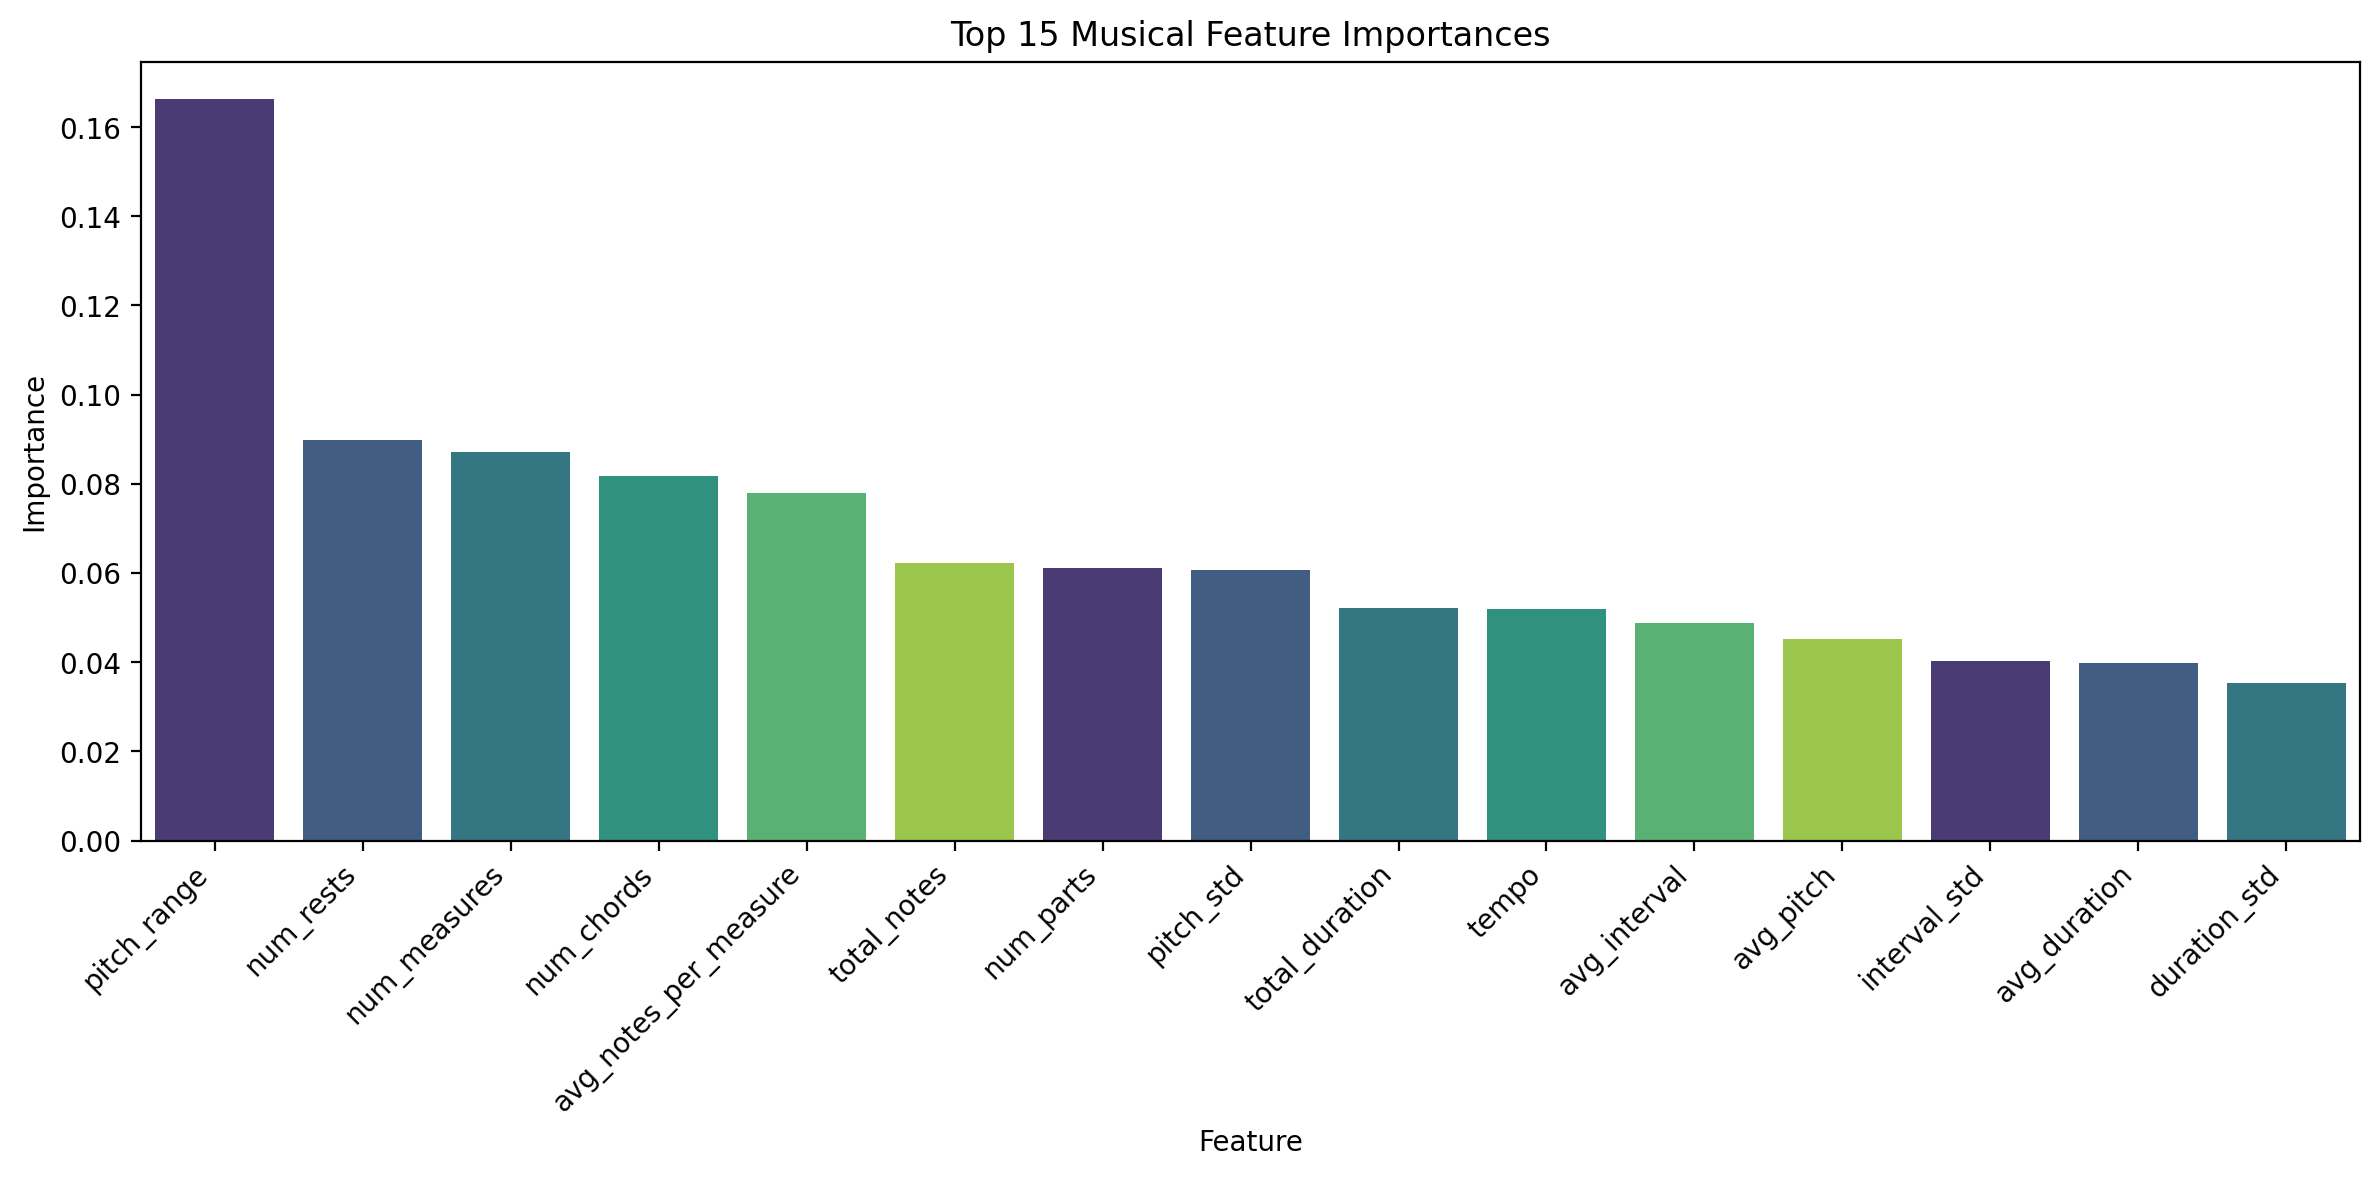

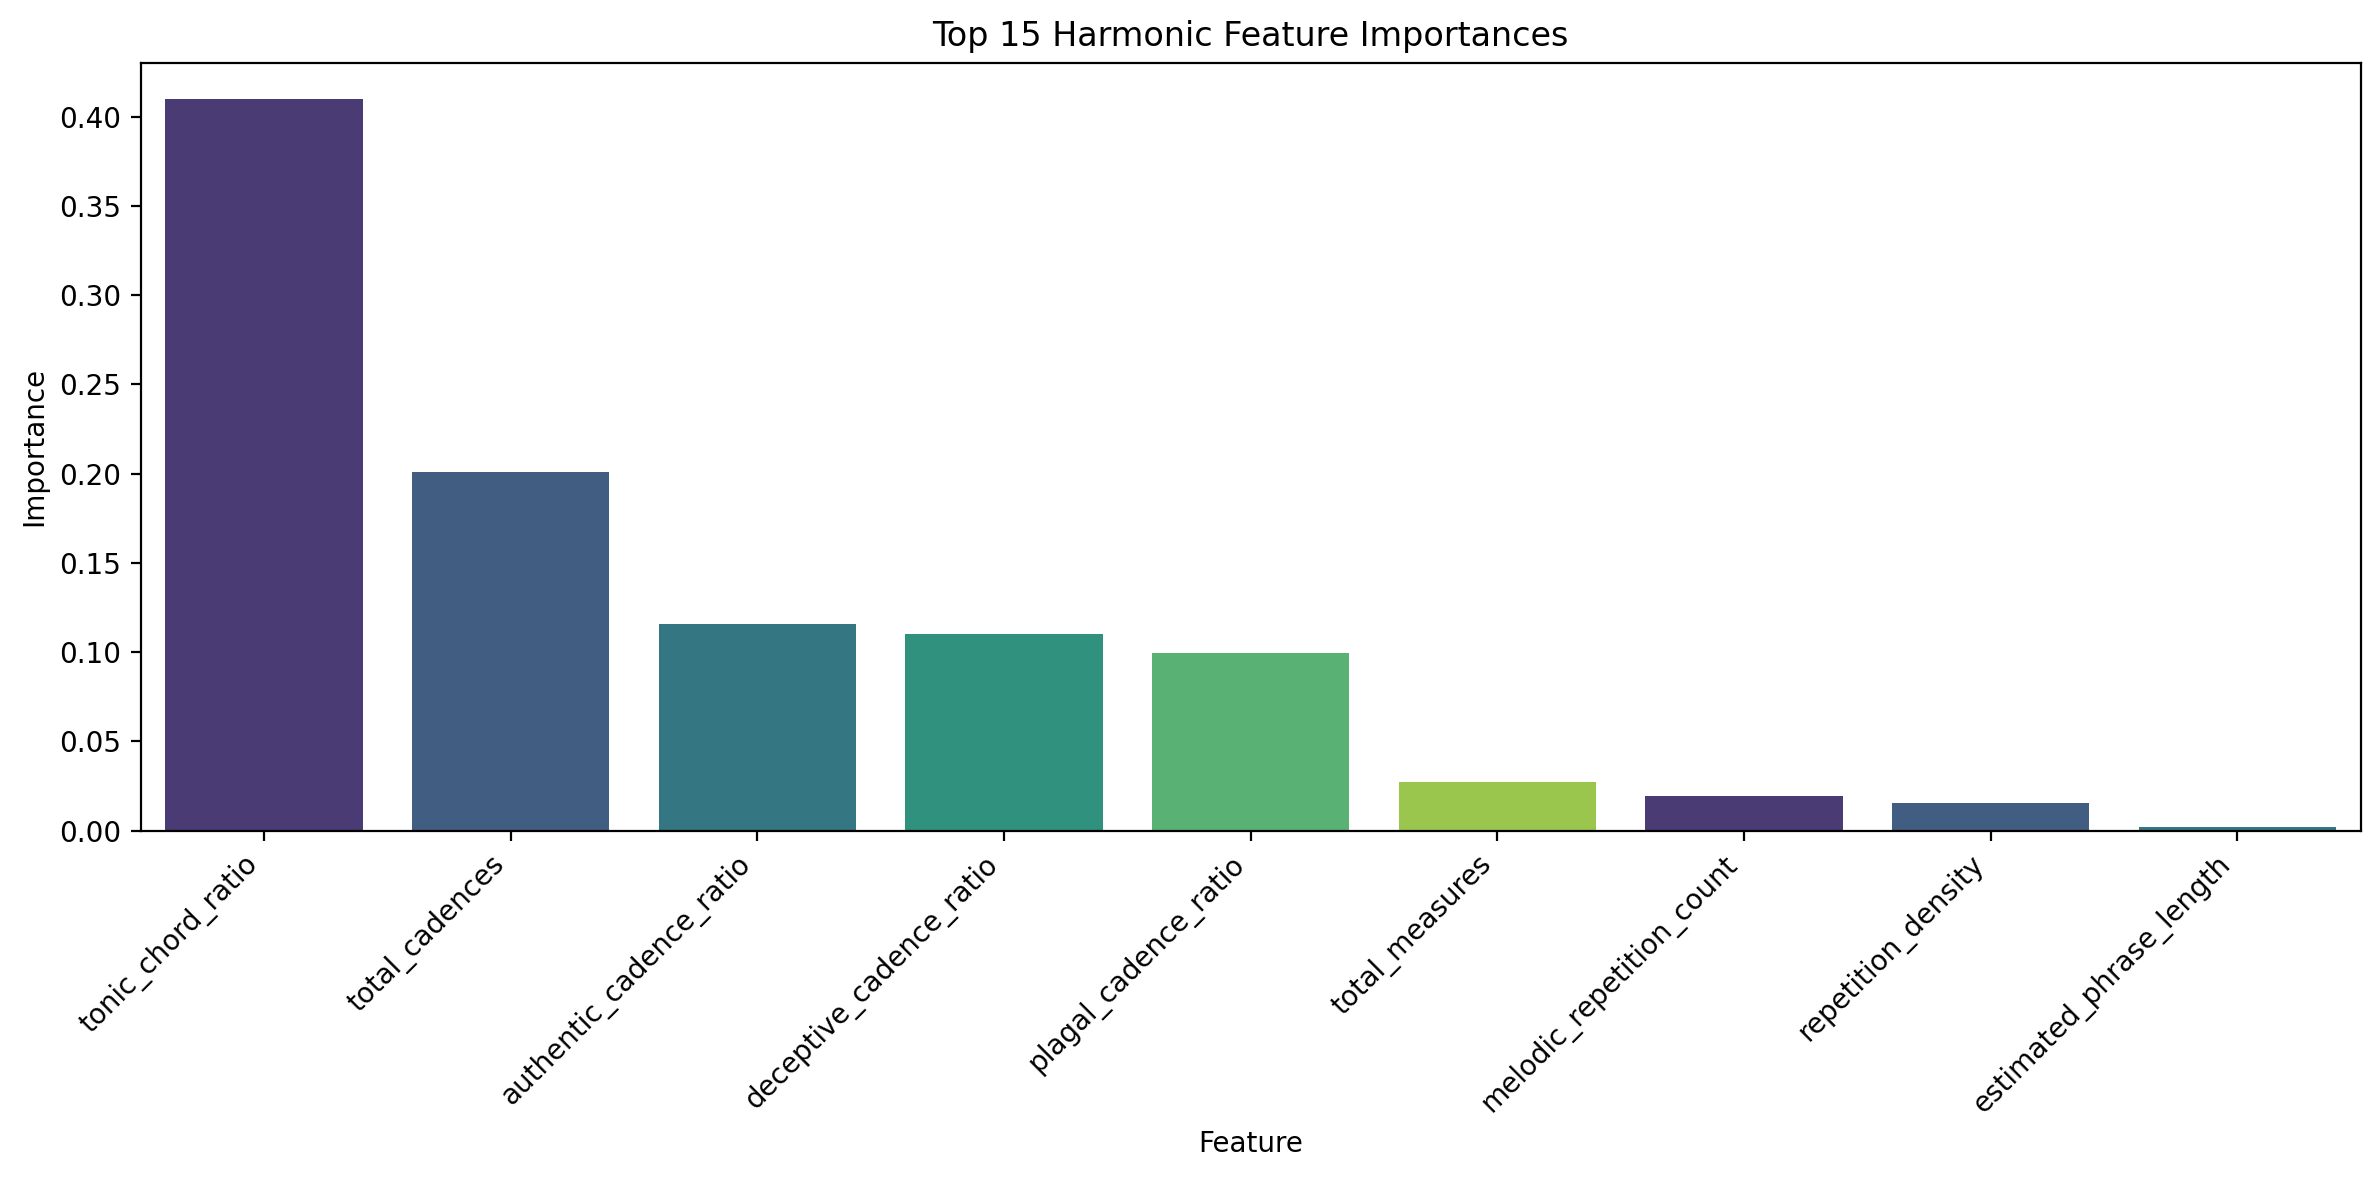

Data preparation completed successfully
Training samples: 1183
Validation samples: 209
Test samples: 246
Training class distribution: {'Bach': np.int64(740), 'Beethoven': np.int64(159), 'Chopin': np.int64(99), 'Mozart': np.int64(185)}
Selected musical features (15): ['total_notes', 'total_duration', 'tempo', 'avg_pitch', 'pitch_range']...
Selected harmonic features (9): ['tonic_chord_ratio', 'estimated_phrase_length', 'total_measures', 'melodic_repetition_count', 'repetition_density']...


In [29]:
# Data Preparation and Feature Selection
print("\nDATA PREPARATION AND FEATURE SELECTION")

try:
    # Prepare data splits
    data_splits = pipeline.prepare_data(
        musical_df=musical_data,
        harmonic_df=harmonic_data,
        note_sequences=note_sequences,
        sequence_labels=np.array(sequence_labels_mapped)
    )


    # Plot for musical features
    plot_feature_importances(pipeline.data_processor, features_df, feature_type='musical', top_n=15)

    # Plot for harmonic features
    plot_feature_importances(pipeline.data_processor, harmonic_df, feature_type='harmonic', top_n=15)
    
    print("Data preparation completed successfully")
    print(f"Training samples: {len(data_splits['y_train'])}")
    print(f"Validation samples: {len(data_splits['y_val'])}")
    print(f"Test samples: {len(data_splits['y_test'])}")

    # Display class distribution
    unique_labels, counts = np.unique(data_splits['y_train_encoded'], return_counts=True)
    class_distribution = dict(zip([TARGET_COMPOSERS[i] for i in unique_labels], counts))
    print(f"Training class distribution: {class_distribution}")

    # Display selected features
    feature_names = pipeline.data_processor.feature_selectors
    if 'musical' in feature_names:
        print(f"Selected musical features ({len(feature_names['musical']['features'])}): {feature_names['musical']['features'][:5]}...")
    if 'harmonic' in feature_names:
        print(f"Selected harmonic features ({len(feature_names['harmonic']['features'])}): {feature_names['harmonic']['features'][:5]}...")

except Exception as e:
    print(f"Error in data preparation: {e}")
    raise

In [30]:
# Model Building
print("\nMODEL BUILDING")


try:
    # Build the hybrid model
    model = pipeline.build_model()

    print("Hybrid CNN-LSTM model built successfully")
    print(f"Total parameters: {model.count_params():,}")
    print("Model input shapes:")
    for i, input_layer in enumerate(model.inputs):
        print(f"- {input_layer.name}: {input_layer.shape}")
    print(f"Model output shape: {model.output.shape}")

    # Display model summary (condensed)
    print("\nModel Architecture Summary:")
    model.summary(line_length=100)

except Exception as e:
    print(f"Error building model: {e}")
    raise


MODEL BUILDING
Hybrid CNN-LSTM model built successfully
Total parameters: 937,092
Model input shapes:
- musical_features: (None, 15)
- harmonic_features: (None, 9)
- sequence_features: (None, 100)
Model output shape: (None, 4)

Model Architecture Summary:


Model: "HybridComposerClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sequence_features           │ (None, 100)             │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_reshape (Reshape)       │ (None, 100, 1)          │              0 │ sequence_features[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_branch_conv_1 (Conv1D)  │ (None, 100, 64)         │            256 │ cnn_reshape[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_branch_bn_1             │ (None, 100, 64)         │            256 │ cnn_branch_conv_1[0][0] │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_branch_pool_1           │ (None, 50, 64)          │              0 │ cnn_branch_bn_1[0][0]   │
│ (MaxPooling1D)              │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_branch_dropout_1        │ (None, 50, 64)          │              0 │ cnn_branch_pool_1[0][0] │
│ (Dropout)                   │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_branch_conv_2 (Conv1D)  │ (None, 50, 128)         │         24,704 │ cnn_branch_dropout_1[0… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_branch_bn_2             │ (None, 50, 128)         │            512 │ cnn_branch_conv_2[0][0] │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_residual_projection     │ (None, 50, 128)         │          8,320 │ cnn_branch_dropout_1[0… │
│ (Conv1D)                    │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_residual_add (Add)      │ (None, 50, 128)         │              0 │ cnn_branch_bn_2[0][0],  │
│                             │                         │                │ cnn_residual_projectio… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ musical_features            │ (None, 15)              │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ harmonic_features           │ (None, 9)               │              0 │ -                       │
│ (InputLayer)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ cnn_residual_activation     │ (None, 50, 128)         │              0 │ cnn_residual_add[0][0]  │
│ (Activation)                │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ musical_dense_1 (Dense)     │ (None, 256)             │    

 Total params: 937,092 (3.57 MB)

 Trainable params: 934,660 (3.57 MB)

 Non-trainable params: 2,432 (9.50 KB)

<a id='modeltraining'></a>

# 8. Model Training: <a href="#Index" style="font-size:25px;">&#8679;</a>

---



MODEL TRAINING
Training Configuration:
- Epochs: 40
- Batch size: 32
- Learning rate: 0.00015
- Early stopping patience: 5
- Dropout rate: 0.15
Using CPU for training

Starting model training...


Training: 100%|██████████| 40/40 [03:17<00:00,  4.94s/it, loss=2.1292, acc=0.9637, val_acc=0.9378, lr=0.000000]



Training completed successfully!
Total training time: 197.77 seconds (3.30 minutes)

Training Results Summary:
- Final training accuracy: 0.9637
- Final validation accuracy: 0.9378
- Best validation accuracy: 0.9522
- Final training loss: 2.1292
- Final validation loss: 1.7801
- Best validation loss: 1.7656
- Total epochs trained: 40
Good generalization (train-val gap: 0.0259)
Generating training history plots...


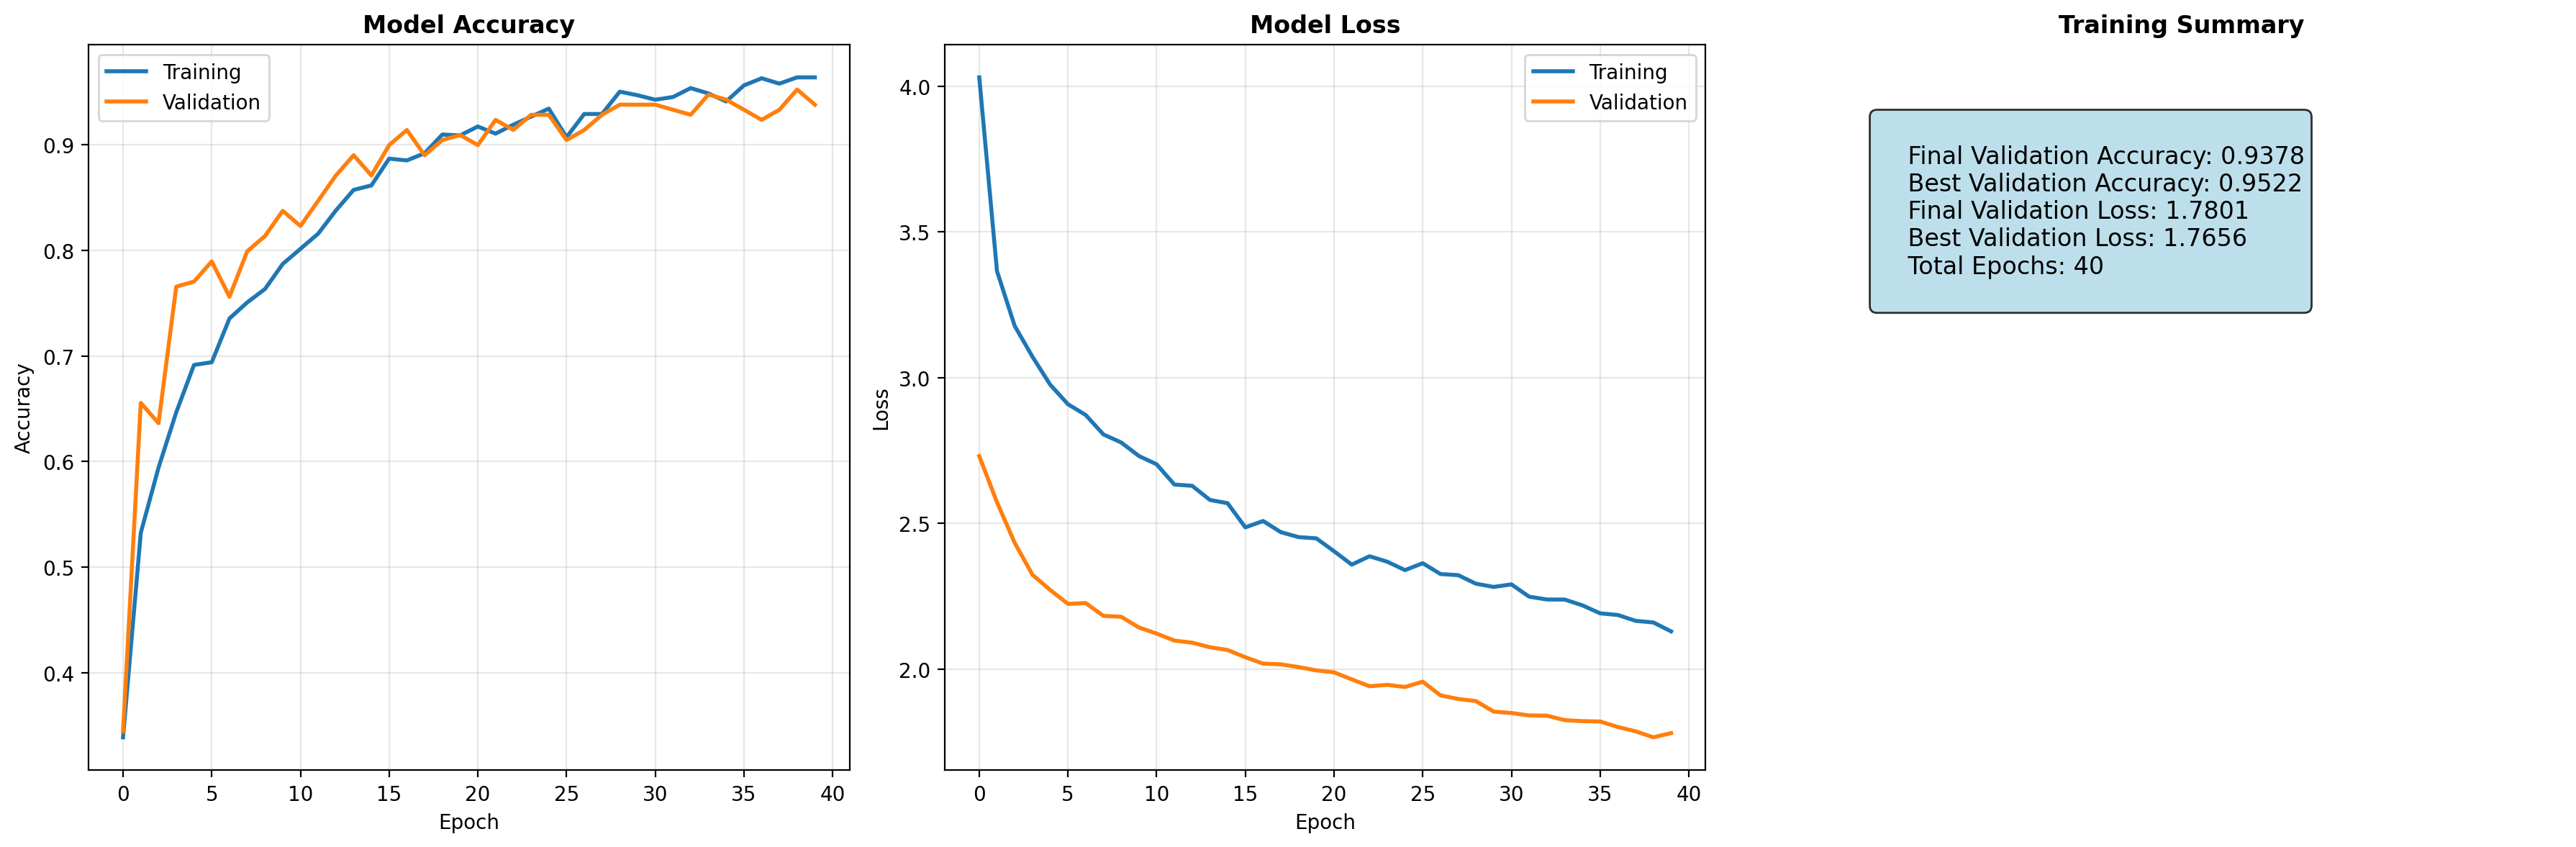

In [31]:
# Model Training
print("\nMODEL TRAINING")


try:
    # Display training configuration
    print("Training Configuration:")
    print(f"- Epochs: {training_config.epochs}")
    print(f"- Batch size: {training_config.batch_size}")
    print(f"- Learning rate: {model_config.learning_rate}")
    print(f"- Early stopping patience: {training_config.patience}")
    print(f"- Dropout rate: {model_config.dropout_rate}")

    # Check GPU availability
    if tf.config.list_physical_devices('GPU'):
        print("GPU acceleration available")
        # Configure GPU memory growth
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                print("GPU memory growth configured")
            except RuntimeError as e:
                print(f"GPU configuration warning: {e}")
    else:
        print("Using CPU for training")

    # Start training
    print("\nStarting model training...")
    start_time = time.time()

    history = pipeline.train(data_splits)

    training_time = time.time() - start_time

    print("\nTraining completed successfully!")
    print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Training summary
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_loss = min(history.history['val_loss'])

    print("\nTraining Results Summary:")
    print(f"- Final training accuracy: {final_train_acc:.4f}")
    print(f"- Final validation accuracy: {final_val_acc:.4f}")
    print(f"- Best validation accuracy: {best_val_acc:.4f}")
    print(f"- Final training loss: {final_train_loss:.4f}")
    print(f"- Final validation loss: {final_val_loss:.4f}")
    print(f"- Best validation loss: {best_val_loss:.4f}")
    print(f"- Total epochs trained: {len(history.history['accuracy'])}")

    # Check for overfitting
    train_val_gap = final_train_acc - final_val_acc
    if train_val_gap > 0.1:
        print(f"Warning: Potential overfitting detected (train-val gap: {train_val_gap:.4f})")
    else:
        print(f"Good generalization (train-val gap: {train_val_gap:.4f})")

    # Plot training history
    print("Generating training history plots...")
    plot_training_history(history, figsize=(18, 6))

except Exception as e:
    print(f"Error during training: {e}")
    raise

<a id='modelevaluation'></a>

# 9. Model Evaluation: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


In [32]:
# Model Evaluation
print("\nMODEL EVALUATION")


try:
    # Evaluate model on test set
    print("Evaluating model on test set...")
    test_metrics = pipeline.evaluate(data_splits)

    print("\nTest Results:")
    print(f"- Test Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"- Test Precision: {test_metrics['precision']:.4f}")
    print(f"- Test Recall: {test_metrics['recall']:.4f}")
    print(f"- Test F1-Score: {test_metrics['f1_score']:.4f}")

    # Per-class performance in table format
    print("\nPer-Class Performance Table:")
    
    # Create a list to store the performance data
    performance_data = []
    
    for composer in TARGET_COMPOSERS:
        if composer in test_metrics['classification_report']:
            metrics = test_metrics['classification_report'][composer]
            auc_score = test_metrics['roc_data'][composer]['auc'] if composer in test_metrics['roc_data'] else 'N/A'
            
            performance_data.append({
                'Composer': composer,
                'Precision': f"{metrics['precision']:.4f}",
                'Recall': f"{metrics['recall']:.4f}",
                'F1-Score': f"{metrics['f1-score']:.4f}",
                'AUC': f"{auc_score:.4f}" if auc_score != 'N/A' else 'N/A',
                'Support': metrics['support']
            })
    
    # Create DataFrame and display as table
    performance_df = pd.DataFrame(performance_data)
    print(performance_df.to_string(index=False))

    print("\nModel evaluation completed successfully!")

except Exception as e:
    print(f"Error during evaluation: {e}")
    raise


MODEL EVALUATION
Evaluating model on test set...

Test Results:
- Test Accuracy: 0.9350
- Test Precision: 0.9412
- Test Recall: 0.9350
- Test F1-Score: 0.9363

Per-Class Performance Table:
 Composer Precision Recall F1-Score    AUC  Support
     Bach    1.0000 1.0000   1.0000 1.0000    154.0
Beethoven    0.7436 0.8788   0.8056 0.9365     33.0
   Chopin    0.7000 0.7000   0.7000 0.9746     20.0
   Mozart    1.0000 0.8462   0.9167 0.9942     39.0

Model evaluation completed successfully!



RESULTS VISUALIZATION
Generating confusion matrix...


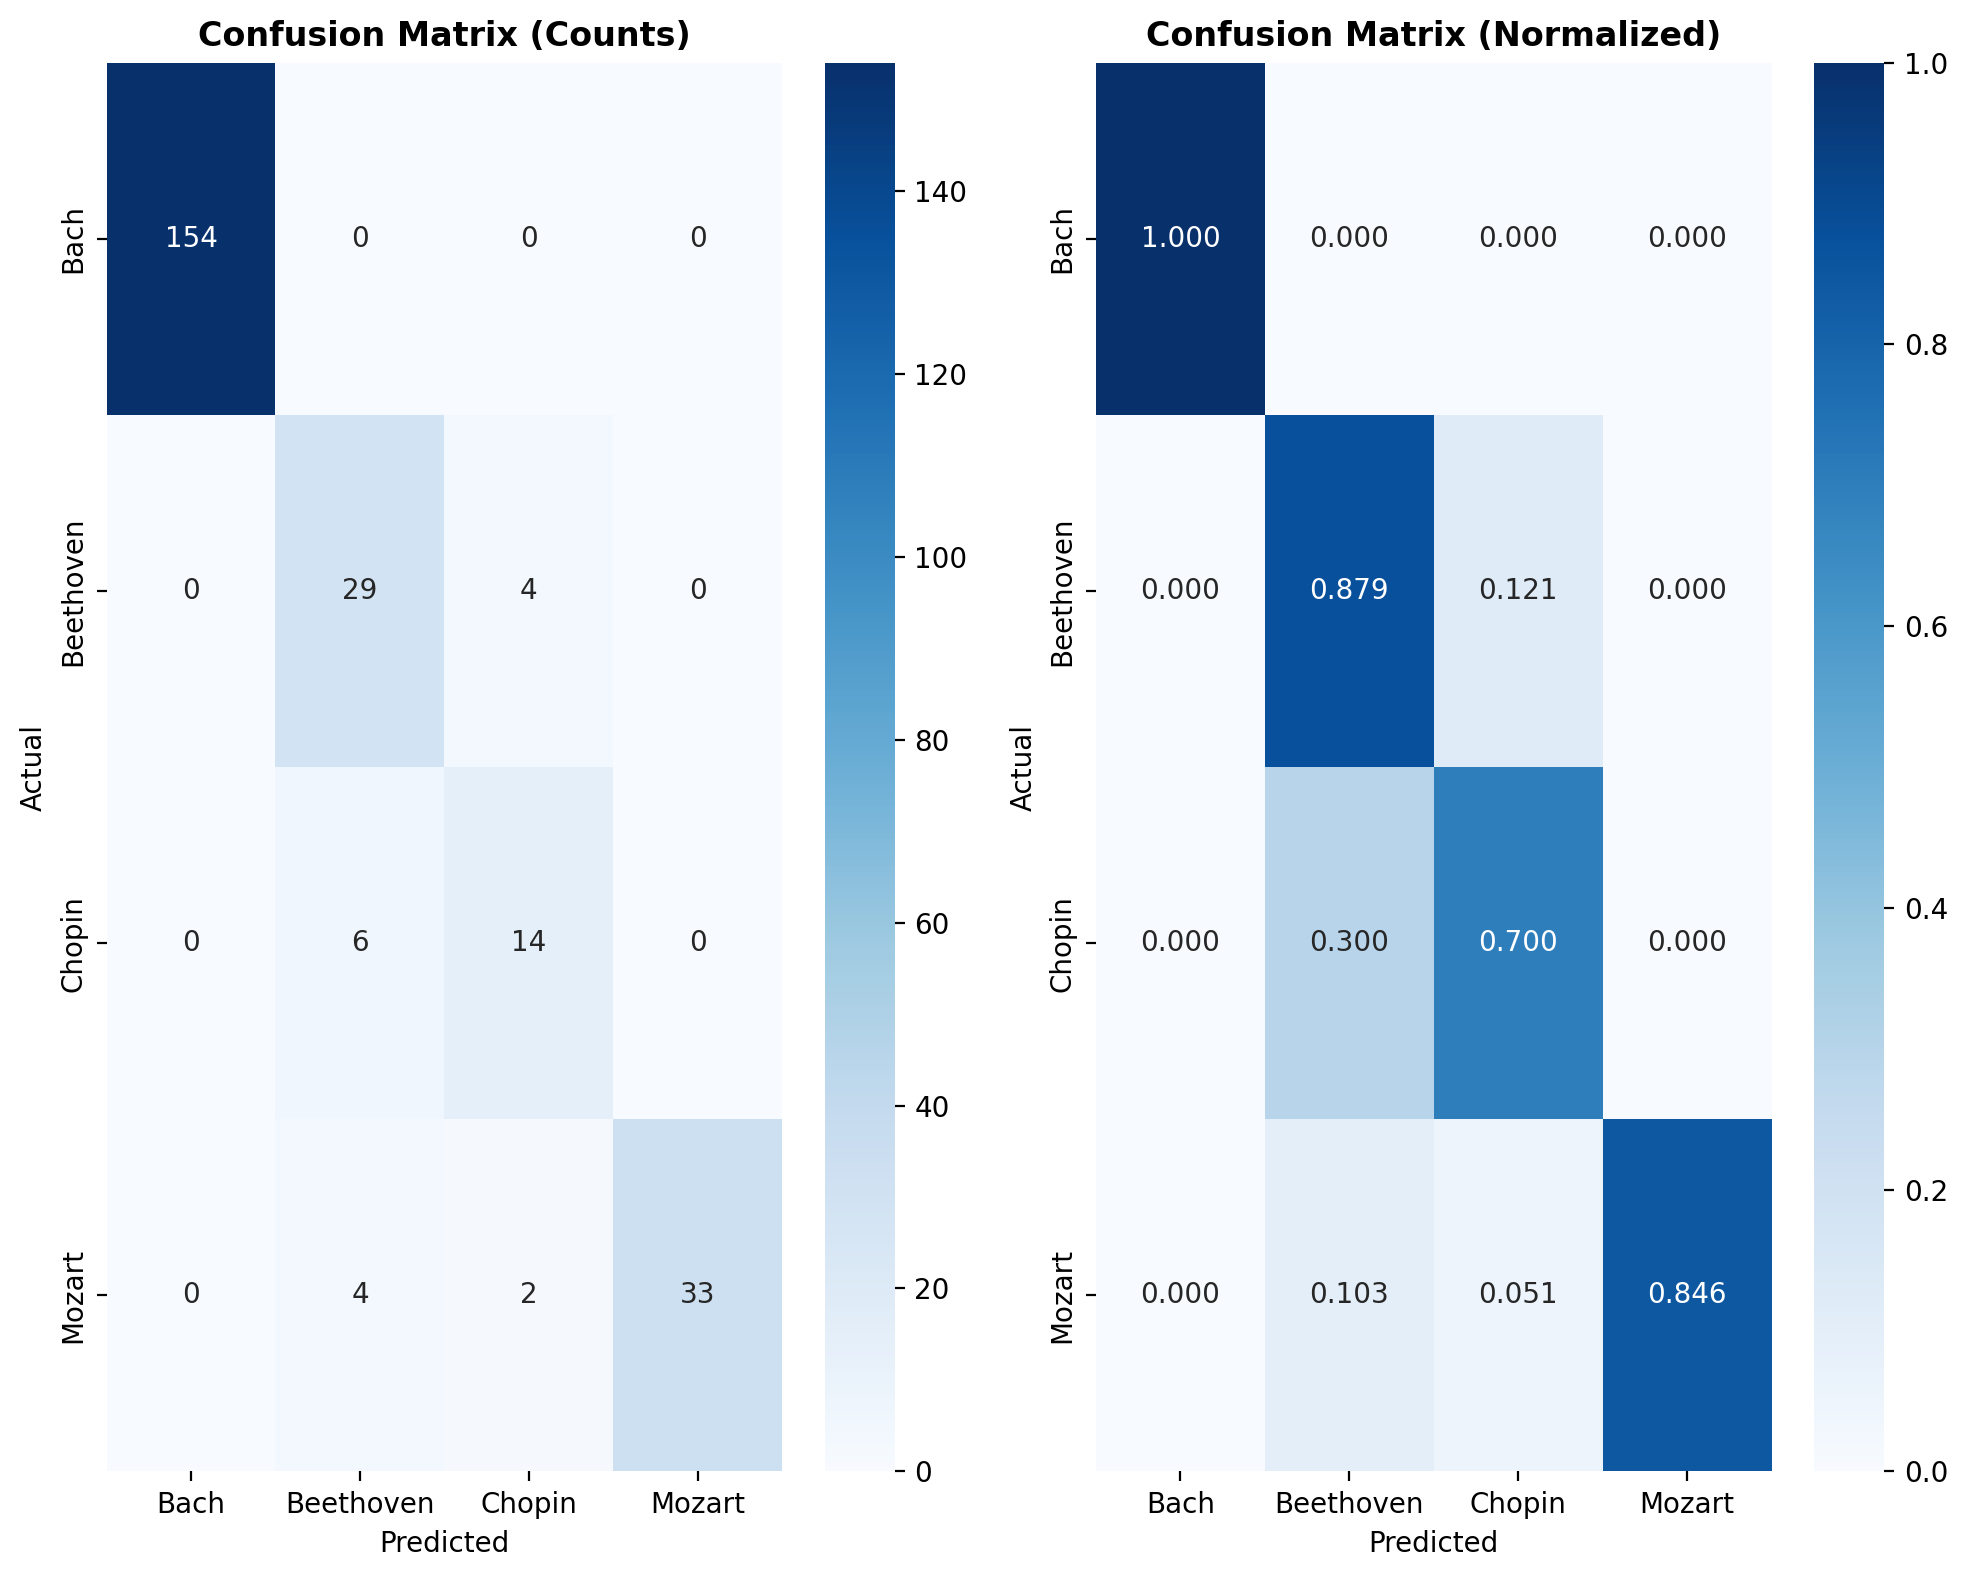

Generating ROC curves...


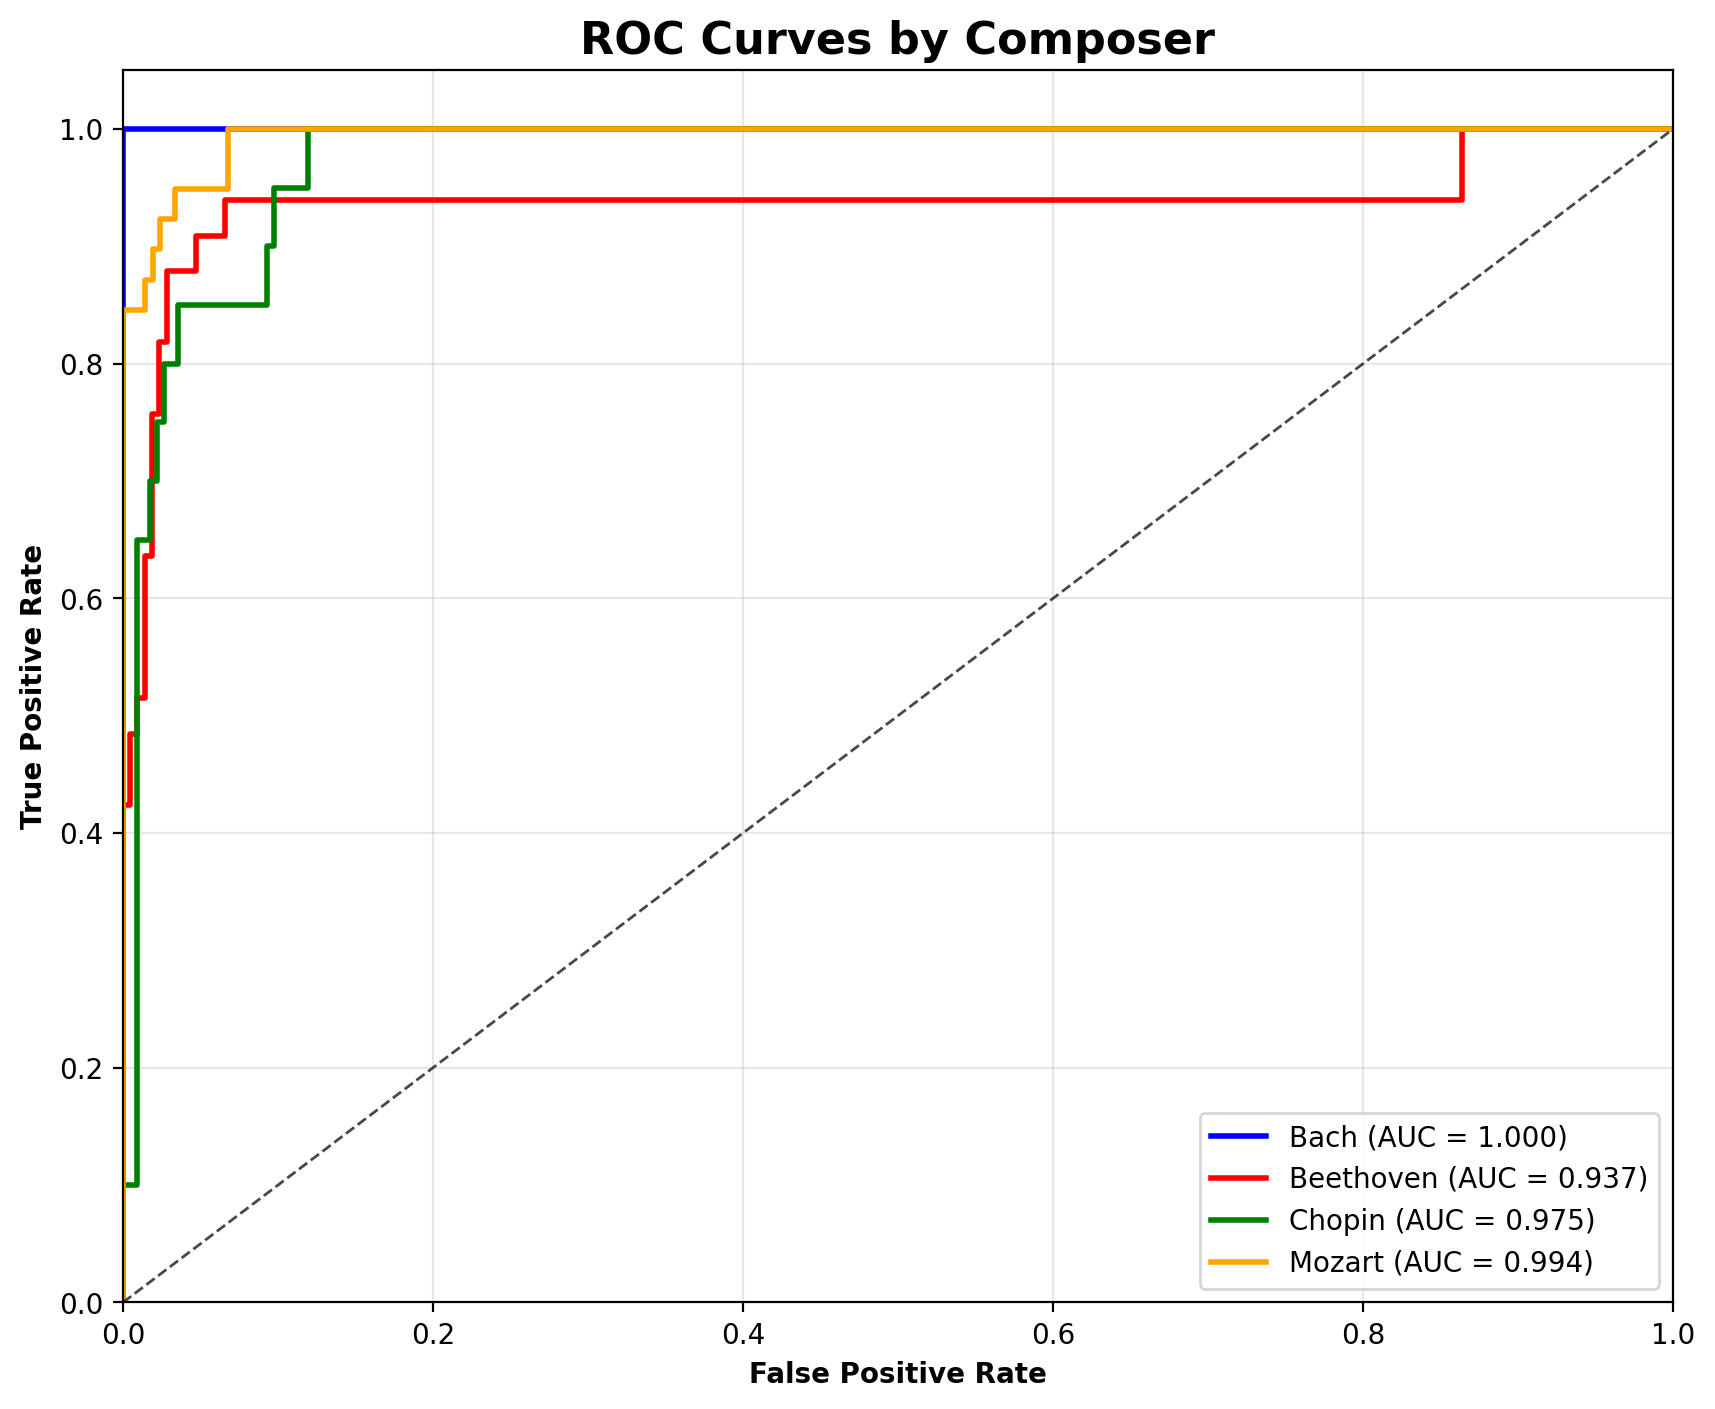

Generating performance comparison...


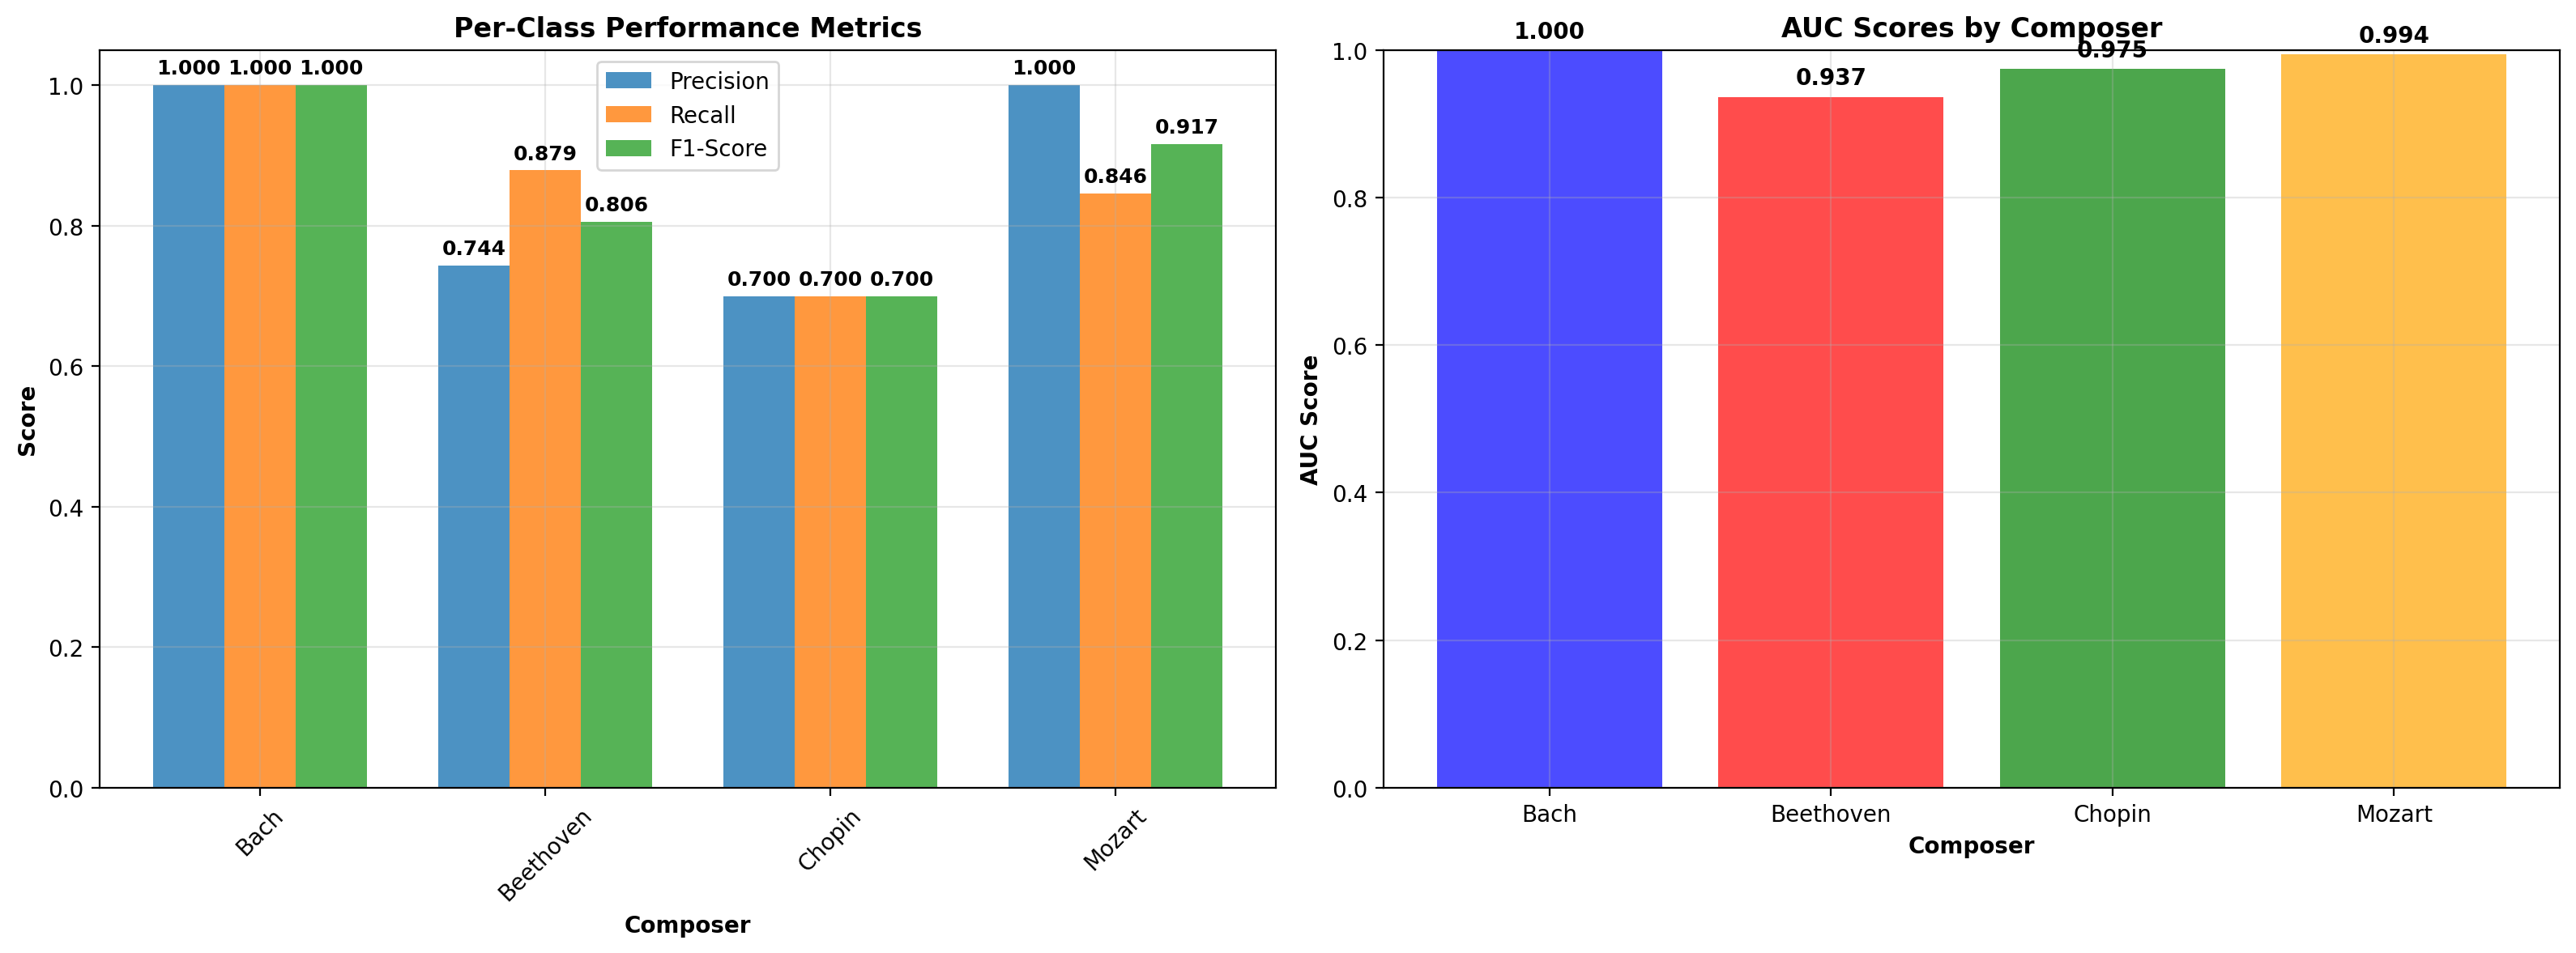

Visualization completed successfully!


In [33]:
# Visualization of Results
print("\nRESULTS VISUALIZATION")


try:
    # Plot confusion matrix
    print("Generating confusion matrix...")
    plt.figure(figsize=(10, 8))

    # Normalized confusion matrix
    cm = test_metrics['confusion_matrix']
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=TARGET_COMPOSERS, yticklabels=TARGET_COMPOSERS)
    plt.title('Confusion Matrix (Counts)', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.subplot(1, 2, 2)
    sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=TARGET_COMPOSERS, yticklabels=TARGET_COMPOSERS)
    plt.title('Confusion Matrix (Normalized)', fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Plot ROC curves
    print("Generating ROC curves...")
    plt.figure(figsize=(10, 8))

    colors = ['blue', 'red', 'green', 'orange', 'purple']
    for i, (composer, data) in enumerate(test_metrics['roc_data'].items()):
        color = colors[i % len(colors)]
        plt.plot(data['fpr'], data['tpr'], color=color, linewidth=2,
                label=f'{composer} (AUC = {data["auc"]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontweight='bold')
    plt.ylabel('True Positive Rate', fontweight='bold')
    plt.title('ROC Curves by Composer', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Performance comparison chart
    print("Generating performance comparison...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Per-class metrics
    composers = [c for c in TARGET_COMPOSERS if c in test_metrics['classification_report']]
    metrics_names = ['precision', 'recall', 'f1-score']
    x = np.arange(len(composers))
    width = 0.25

    for i, metric in enumerate(metrics_names):
        values = [test_metrics['classification_report'][comp][metric] for comp in composers]
        bars = axes[0].bar(x + i*width, values, width, label=metric.title(), alpha=0.8)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    axes[0].set_xlabel('Composer', fontweight='bold')
    axes[0].set_ylabel('Score', fontweight='bold')
    axes[0].set_title('Per-Class Performance Metrics', fontweight='bold')
    axes[0].set_xticks(x + width)
    axes[0].set_xticklabels(composers, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # AUC comparison
    auc_scores = [test_metrics['roc_data'][comp]['auc'] for comp in composers]
    bars = axes[1].bar(composers, auc_scores, color=['blue', 'red', 'green', 'orange'][:len(composers)], alpha=0.7)
    axes[1].set_xlabel('Composer', fontweight='bold')
    axes[1].set_ylabel('AUC Score', fontweight='bold')
    axes[1].set_title('AUC Scores by Composer', fontweight='bold')
    axes[1].set_ylim([0, 1])
    axes[1].grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, score in zip(bars, auc_scores):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("Visualization completed successfully!")

except Exception as e:
    print(f"Error during visualization: {e}")

In [34]:
try:

    # Display final summary
    print("\nPIPELINE EXECUTION SUMMARY")
    print(f"Model built with {pipeline.model.count_params():,} parameters")
    print(f"Training completed in {len(pipeline.history.history['accuracy'])} epochs")
    print(f"Best validation accuracy: {max(pipeline.history.history['val_accuracy']):.4f}")
    print(f"Test accuracy: {test_metrics['accuracy']:.4f}")
    print("Model artifacts saved for deployment")

    print("\nFinal Performance Metrics:")
    print(f"- Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"- Precision: {test_metrics['precision']:.4f}")
    print(f"- Recall: {test_metrics['recall']:.4f}")
    print(f"- F1-Score: {test_metrics['f1_score']:.4f}")

except Exception as e:
    print(f"Error during model saving: {e}")


PIPELINE EXECUTION SUMMARY
Model built with 937,092 parameters
Training completed in 40 epochs
Best validation accuracy: 0.9522
Test accuracy: 0.9350
Model artifacts saved for deployment

Final Performance Metrics:
- Accuracy: 0.9350
- Precision: 0.9412
- Recall: 0.9350
- F1-Score: 0.9363


<a id='modelprediction'></a>

# 10. Model Prediction: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


In [35]:
# Model Prediction and Analysis
print("\nMODEL PREDICTION AND ANALYSIS")

try:
    # Sample predictions on test set
    print("Making sample predictions...")

    # Select random test samples
    num_samples = min(10, len(data_splits['y_test_encoded']))
    sample_indices = np.random.choice(
        len(data_splits['y_test_encoded']),
        size=num_samples,
        replace=False
    )

    # Make predictions
    X_test_list = [
        data_splits['X_test']['musical'],
        data_splits['X_test']['harmonic'],
        data_splits['X_test']['sequences']
    ]

    y_pred_prob = pipeline.model.predict(X_test_list, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    print("\nSample Predictions Results:")

    print(f"{'Index':<6} {'True':<12} {'Predicted':<12} {'Confidence':<12} {'Correct':<8}")


    correct_predictions = 0
    for idx in sample_indices:
        true_label = TARGET_COMPOSERS[data_splits['y_test_encoded'][idx]]
        pred_label = TARGET_COMPOSERS[y_pred[idx]]
        confidence = y_pred_prob[idx, y_pred[idx]]
        is_correct = true_label == pred_label

        if is_correct:
            correct_predictions += 1

        status = "CORRECT" if is_correct else "WRONG"
        print(f"{idx:<6} {true_label:<12} {pred_label:<12} {confidence:<12.4f} {status:<8}")


    sample_accuracy = correct_predictions / len(sample_indices)
    print(f"Sample Accuracy: {correct_predictions}/{len(sample_indices)} ({sample_accuracy:.1%})")

    # Detailed analysis for first few samples
    print("\nDetailed Top-3 Predictions:")
    for i, idx in enumerate(sample_indices[:3]):
        true_label = TARGET_COMPOSERS[data_splits['y_test_encoded'][idx]]

        # Get top 3 predictions
        top_3_idx = np.argsort(y_pred_prob[idx])[-3:][::-1]

        print(f"\nSample {idx} (True: {true_label}):")
        for j, pred_idx in enumerate(top_3_idx, 1):
            composer = TARGET_COMPOSERS[pred_idx]
            prob = y_pred_prob[idx, pred_idx]
            print(f"  {j}. {composer}: {prob:.4f}")

    print("\nPrediction analysis completed!")

except Exception as e:
    print(f"Error during prediction analysis: {e}")


MODEL PREDICTION AND ANALYSIS
Making sample predictions...

Sample Predictions Results:
Index  True         Predicted    Confidence   Correct 
216    Mozart       Mozart       0.9373       CORRECT 
214    Bach         Bach         0.9511       CORRECT 
61     Bach         Bach         0.9390       CORRECT 
177    Bach         Bach         0.8431       CORRECT 
164    Bach         Bach         0.9028       CORRECT 
38     Bach         Bach         0.9804       CORRECT 
127    Mozart       Mozart       0.9589       CORRECT 
8      Beethoven    Beethoven    0.5644       CORRECT 
215    Bach         Bach         0.8630       CORRECT 
160    Bach         Bach         0.9057       CORRECT 
Sample Accuracy: 10/10 (100.0%)

Detailed Top-3 Predictions:

Sample 216 (True: Mozart):
  1. Mozart: 0.9373
  2. Bach: 0.0361
  3. Beethoven: 0.0168

Sample 214 (True: Bach):
  1. Bach: 0.9511
  2. Chopin: 0.0323
  3. Beethoven: 0.0137

Sample 61 (True: Bach):
  1. Bach: 0.9390
  2. Chopin: 0.0323
  3. B

<a id='modeloptimization'></a>

# 11. Model Optimization: <a href="#Index" style="font-size:25px;">&#8679;</a>

---



HYPERPARAMETER TUNING
Starting hyperparameter tuning...
Parameter combinations to test: 32
Starting hyperparameter tuning with 8 trials...
Testing 8 parameter combinations...


Hyperparameter Search: 100%|██████████| 8/8 [09:30<00:00, 71.32s/it]


Hyperparameter tuning completed!
Best validation accuracy: 0.9426
Best parameters: {'lstm_units': 128, 'cnn_filters': 128, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005}

Hyperparameter tuning completed!
Best validation accuracy: 0.9426
Best parameters: {'lstm_units': 128, 'cnn_filters': 128, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005}

Top 3 Parameter Configurations:
1. Val Acc: 0.9426
Parameters: {'lstm_units': 128, 'cnn_filters': 128, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.0005}

2. Val Acc: 0.9378
Parameters: {'lstm_units': 256, 'cnn_filters': 128, 'dense_units': 512, 'dropout_rate': 0.2, 'learning_rate': 0.001}

3. Val Acc: 0.9330
Parameters: {'lstm_units': 128, 'cnn_filters': 128, 'dense_units': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001}

Training final model with best parameters...


Training:  62%|██████▎   | 25/40 [02:05<01:15,  5.01s/it, loss=2.8025, acc=0.8935, val_acc=0.8852, lr=0.000000]



Final model training completed!
Test accuracy with best params: 0.9024
Improvement over default: -0.0325


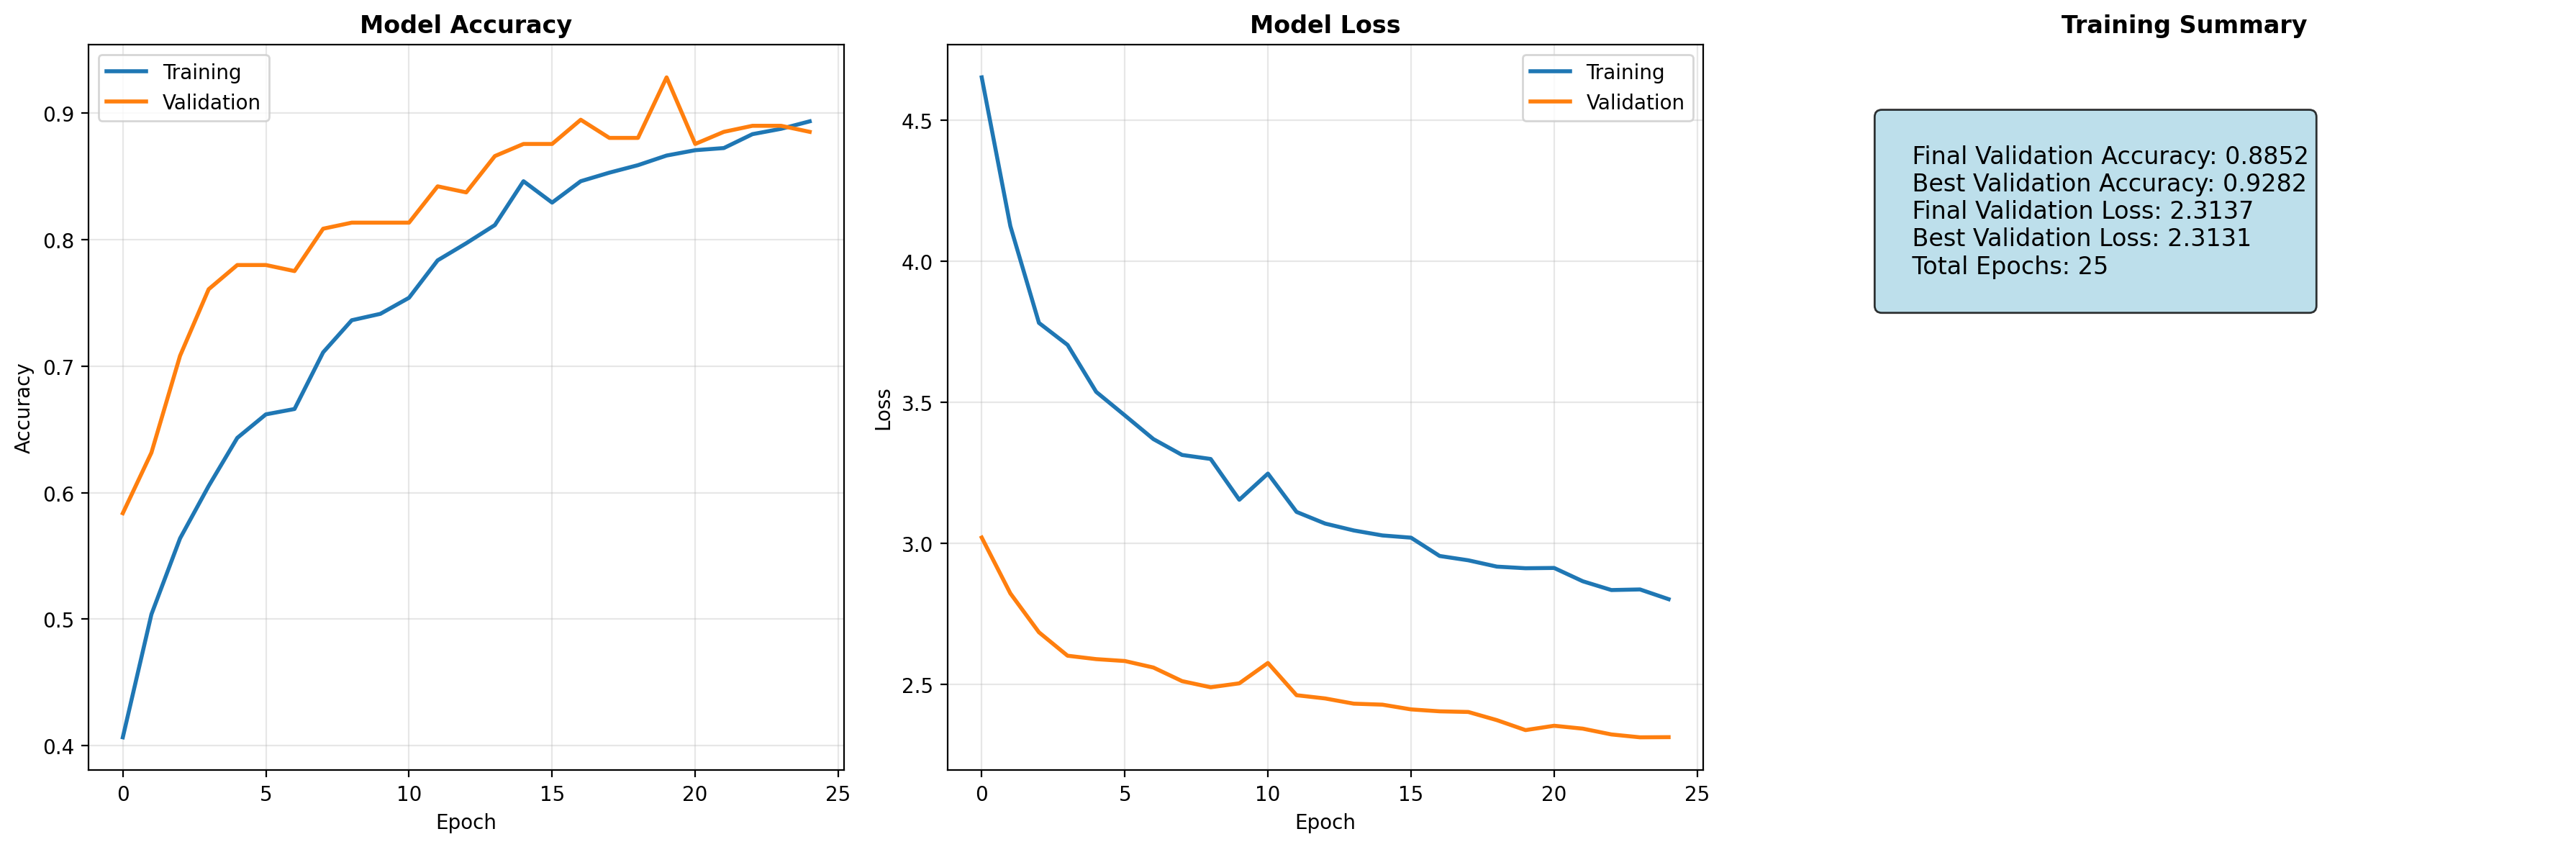

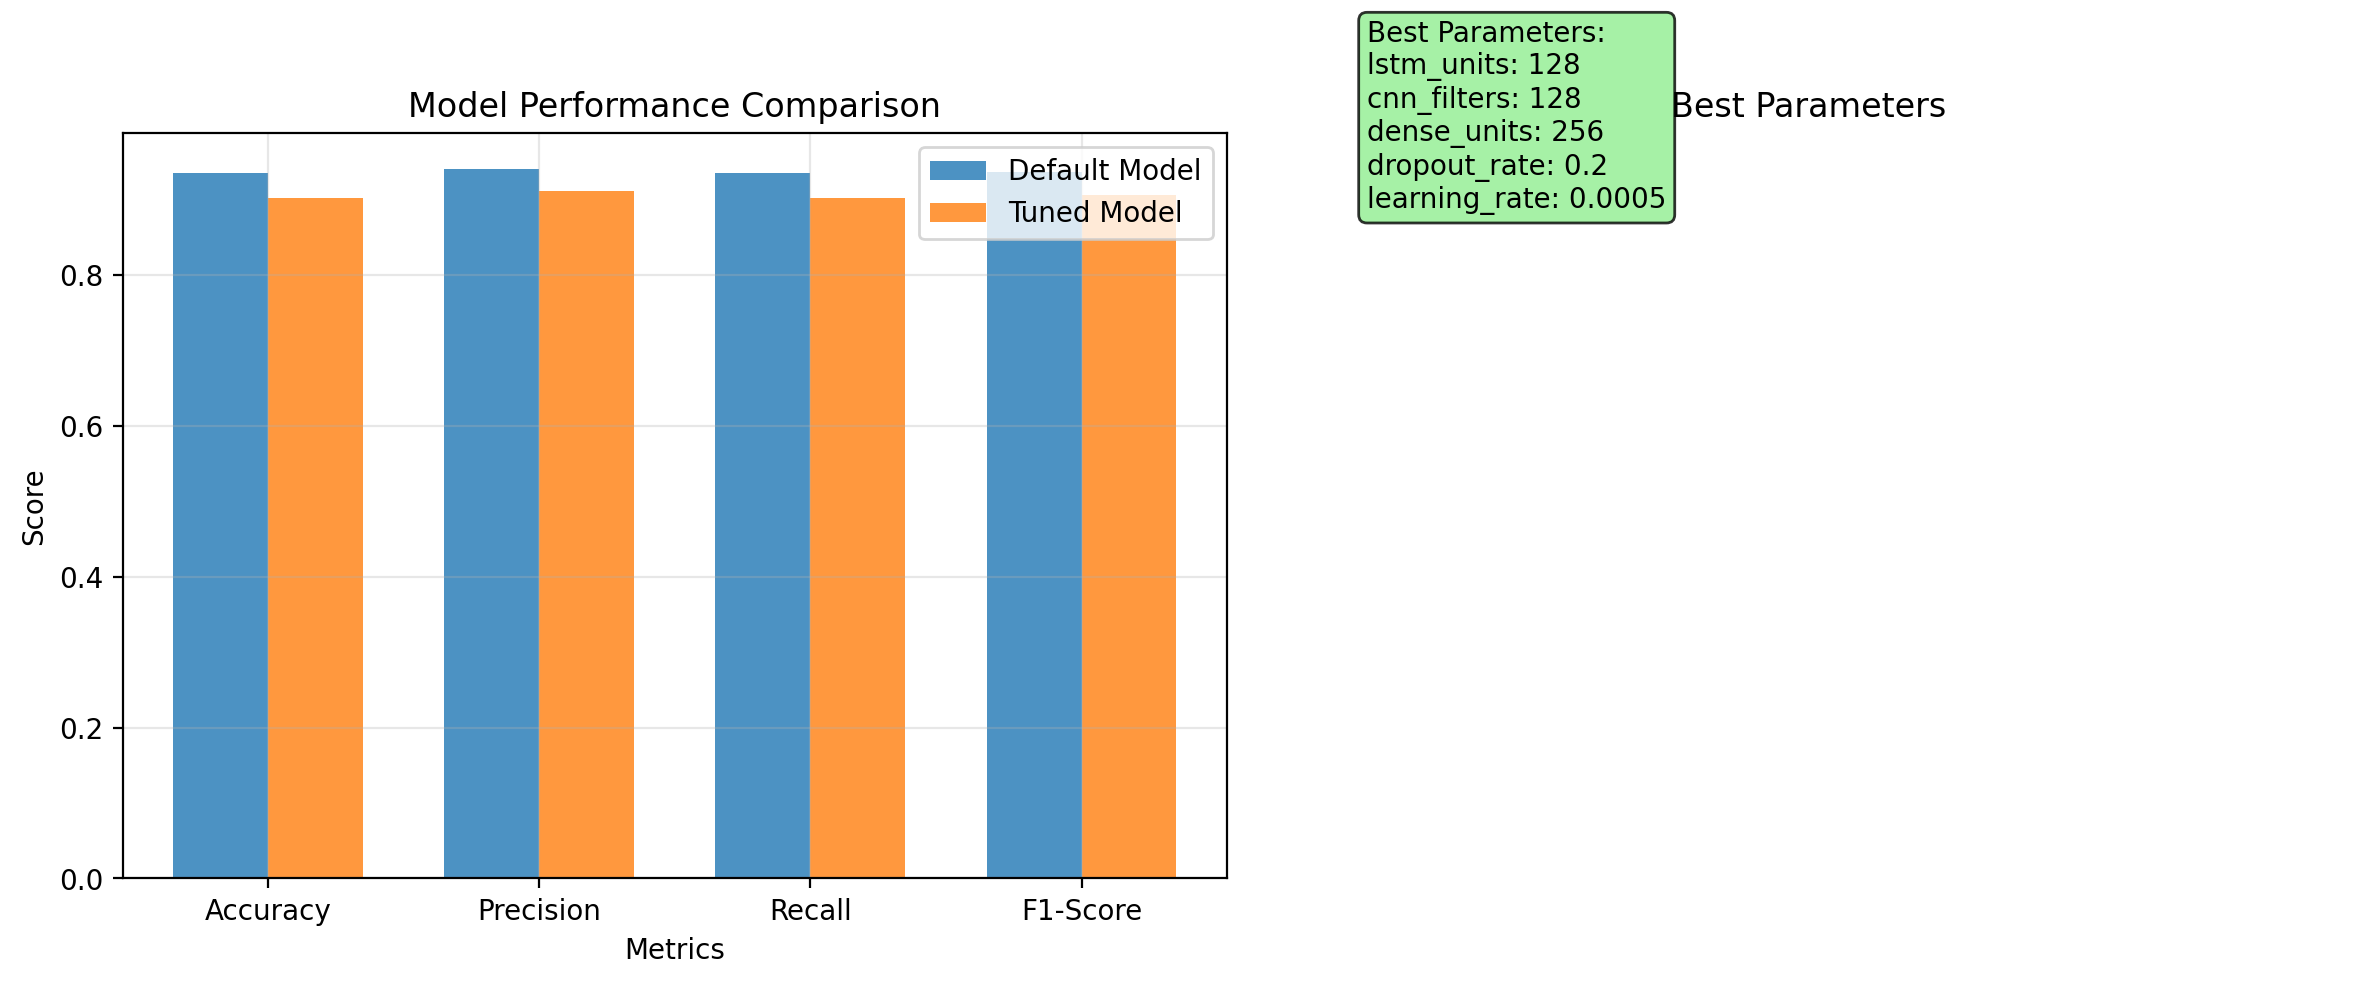

In [41]:

# Hyperparameter Tuning
print("\nHYPERPARAMETER TUNING")
print("Starting hyperparameter tuning...")

try:
    # Define a smaller parameter grid for faster tuning
    param_grid = {
        'lstm_units': [128, 256],           # Reduce choices
        'cnn_filters': [64, 128],
        'dense_units': [256, 512],
        'dropout_rate': [0.2, 0.3],         # Fewer dropout options
        'learning_rate': [0.0005, 0.001]    # Focus on likely best values
    }

    print(f"Parameter combinations to test: {np.prod([len(v) for v in param_grid.values()])}")

    # Use fewer epochs for tuning
    tuning_pipeline = ComposerClassificationPipeline(
        target_composers=TARGET_COMPOSERS,
        model_config=ModelConfig(),
        training_config=TrainingConfig(epochs=10, patience=3)  # Fewer epochs/patience
    )

    # Prepare data for tuning
    tuning_data_splits = tuning_pipeline.prepare_data(
        musical_df=musical_data,
        harmonic_df=harmonic_data,
        note_sequences=note_sequences,
        sequence_labels=np.array(sequence_labels_mapped)
    )

    # Perform hyperparameter search with fewer trials
    best_params, best_score, all_results = tuning_pipeline.tune_hyperparameters(
        X_train=tuning_data_splits['X_train'],
        y_train=tuning_data_splits['y_train'],
        X_val=tuning_data_splits['X_val'],
        y_val=tuning_data_splits['y_val'],
        param_grid=param_grid,
        max_trials=8  # Limit to 8 random combinations
    )

    print("\nHyperparameter tuning completed!")
    print(f"Best validation accuracy: {best_score:.4f}")
    print(f"Best parameters: {best_params}")

    # Display top 3 configurations
    print("\nTop 3 Parameter Configurations:")
    for i, result in enumerate(all_results[:3], 1):
        print(f"{i}. Val Acc: {result['val_accuracy']:.4f}")
        print(f"Parameters: {result['params']}")
        print()

    # Train final model with best parameters and full training config
    print("Training final model with best parameters...")

    best_model_config = create_model_config(**best_params)
    final_pipeline = ComposerClassificationPipeline(
        target_composers=TARGET_COMPOSERS,
        model_config=best_model_config,
        training_config=training_config
    )

    final_data_splits = final_pipeline.prepare_data(
        musical_df=musical_data,
        harmonic_df=harmonic_data,
        note_sequences=note_sequences,
        sequence_labels=np.array(sequence_labels_mapped)
    )

    final_model = final_pipeline.build_model()
    final_history = final_pipeline.train(final_data_splits)
    final_metrics = final_pipeline.evaluate(final_data_splits)

    print("\nFinal model training completed!")
    print(f"Test accuracy with best params: {final_metrics['accuracy']:.4f}")
    print(f"Improvement over default: {final_metrics['accuracy'] - test_metrics['accuracy']:.4f}")

    # Plot training history for tuned model
    plot_training_history(final_history, figsize=(18, 6))

    # Compare performance
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    metrics_comparison = {
        'Default Model': [test_metrics['accuracy'], test_metrics['precision'],
                test_metrics['recall'], test_metrics['f1_score']],
        'Tuned Model': [final_metrics['accuracy'], final_metrics['precision'],
                final_metrics['recall'], final_metrics['f1_score']]
    }

    x = np.arange(4)
    width = 0.35
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    plt.bar(x - width/2, metrics_comparison['Default Model'], width,
            label='Default Model', alpha=0.8)
    plt.bar(x + width/2, metrics_comparison['Tuned Model'], width,
            label='Tuned Model', alpha=0.8)

    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metric_names)
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)

    # Hyperparameter importance visualization
    param_importance = {}
    for result in all_results[:10]:  # Top 10 results
        for param, value in result['params'].items():
            if param not in param_importance:
                param_importance[param] = []
        param_importance[param].append((value, result['val_accuracy']))

    # Plot best parameter values
    best_param_text = "\n".join([f"{k}: {v}" for k, v in best_params.items()])
    plt.text(0.1, 0.9, f"Best Parameters:\n{best_param_text}",
        transform=plt.gca().transAxes, fontsize=10,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    plt.axis('off')
    plt.title('Best Parameters')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")

<a id='deployment'></a>

# 12. Deployment: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


In [37]:
try:

    # Save the tuned model
    final_pipeline.save_artifacts(
        modelfilepath=MODEL_PATH,
        artifacts_filepath=MODEL_ARTIFACTS_PATH,
        history_filepath=MODEL_HISTORY_PATH
    )
    print("Tuned model artifacts saved successfully.")
    print(f"Model saved to: {MODEL_PATH}.keras")
    print(f"Artifacts saved to: {MODEL_ARTIFACTS_PATH}")
    print(f"Training history saved to: {MODEL_HISTORY_PATH}")
except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")

Tuned model artifacts saved successfully.
Model saved to: data/model/composer_classification_model.keras.keras
Artifacts saved to: data/model/composer_classification_model_artifacts.pkl
Training history saved to: data/model/composer_classification_model_history.pkl


In [38]:
#streamlit run ./app.py

<a id='conclusion'></a>

# 12. Conclusion: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


<a id='recommendations'></a>

# 13. Recommendations: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


<a id='nextsteps'></a>

# 14. Next Steps: <a href="#Index" style="font-size:25px;">&#8679;</a>

---


<a id='references'></a>

# 15. References: <a href="#Index" style="font-size:25px;">&#8679;</a>

---
